# Riesgo de crédito con modelos explicables y evaluación de equidad

Una institución financiera desea apoyar su decisión de originación de crédito identificando, con anticipación, solicitantes con alto riesgo de incumplimiento. Tu misión es construir una comparativa técnica de modelos que produzcan probabilidades calibradas y explicables, evaluar su desempeño y analizar posibles brechas de equidad entre subgrupos. El resultado debe traducirse en recomendaciones operativas y en la justificación de qué modelo conviene utilizar y por qué.

### Team members:

* Mario David Hernandez Pantoja
* Oscar Martinez Estevez
* Gerardo Hernandez Widman
* Moises Jesus Carrillo Alonzo
* Braulio Jesus Perez Tamayo

# Datos
Usa el German Credit del UCI Machine Learning Repository. Puedes elegir entre:
* Statlog (German Credit Data): 1,000 instancias y 20 variables; clasifica solicitantes como “good/bad” e incluye una matriz de costos: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data
* South German Credit: versión documentada y corregida (700 “good” / 300 “bad”, 20 predictores), con notas de muestreo y codificación; suele facilitar la interpretación y prácticas de explicabilidad: https://archive.ics.uci.edu/dataset/522/south+german+credit


# Requerimientos del Análisis
1) **Análisis Exploratorio y Calidad de Datos**

Caracterización completa del conjunto de datos incluyendo distribución de la clase, tipificación de variables, detección y tratamiento de faltantes, duplicados y outliers. Se espera una narrativa visual (gráficos y tablas) que conecte hallazgos con hipótesis de negocio sobre segmentos de mayor riesgo. Debes dejar por escrito las reglas de limpieza aplicadas y justificar su impacto.

2) **Modelado con probabilidades calibradas**

Se requiere entrenar y comparar cuatro enfoques bajo un mismo split estratificado o validación equivalente (fijar semilla para reproducibilidad) y calibrar probabilidades (Platt o Isotónica) usando únicamente datos de entrenamiento/validación:
1. Modelo de regresión logística junto con su reporte de coeficientes y odds ratios.
2. Modelo basado en árboles de decisión y extracción explícita de reglas interpretables.
3. Modelo ensemble (por ejemplo, Random Forest o Gradient Boosting).
4. Red neuronal.

Debes optimizar el umbral de decisión (además del 0.5) con un criterio declarado y reportar el efecto del umbral elegido.

3) **Métricas y comparación fuera de muestra**

Realiza la evaluación de los modelos de acuerdo a las métricas seleccionadas (Accuracy, Precision, Recall, F1, ROC-AUC y PR-AUC) junto con la matriz de confusión correspondiente. La comparación debe discutir estabilidad (varianza esperada), robustez ante desbalance y sensibilidad al umbral. Incluye curvas ROC y PR para visualizar el trade-off.

4) **Explicabilidad global y local**

El análisis debe facilitar la trazabilidad de por qué un solicitante es clasificado como riesgoso:

* Global: interpreta coeficientes y odds (logística), muestra importancias (árbol/ensemble) y presenta 2–3 reglas del árbol que definan segmentos de alto riesgo.
* Local: explica al menos tres casos individuales (uno mal clasificado, uno “frontera” y uno de riesgo alto). Puedes usar SHAP o LIME; para la red neuronal, considera Integrated Gradients o SHAP Kernel según factibilidad. La explicación debe ser comprensible para negocio (texto corto + visual).

5) **Evaluación de equidad (fairness)**

Selecciona uno o dos atributos comparativos presentes en el dataset (grupos de edad o estado civil) y contrasta resultados entre subgrupos. Reporta al menos dos métricas de equidad (por ejemplo, Demographic Parity: tasa de positivos, y Equal Opportunity: TPR/Recall por grupo) e incluye tamaños muestrales y una discusión honesta de limitaciones (histórico, proxies, label bias).

6) **Recomendación operativa**

Con base en desempeño, explicabilidad y equidad, cierra con una propuesta de uso, un umbral recomendado y plan de monitoreo y mantenimiento (monitoreo periódico, recalibración, auditorías de equidad y documentación de decisiones).

# Entregables
1. Notebook con secciones claramente identificadas que correspondan a los requerimientos anteriores:
    * Exploración y Calidad de Datos
    * Modelado
    * Evaluación
    * Explicabilidad
    * Evaluación de Equidad

2. Resumen ejecutivo donde concluyas qué modelo utilizar y por qué, integrando:
    * Exploración y Calidad de Datos
    * Modelado
    * Evaluación
    * Explicabilidad
    * Evaluación de Equida

# Requerimientos del Análisis (Code)


## 1) Análisis Exploratorio y Calidad de Datos

### 0. Notas iniciales

Archivo usado: german.data (formato categórico original) y opcionalmente german.data-numeric (forma numérica ya procesada). Ambos están en la carpeta statlog+german+credit+data/.

Número de instancias: 1000.

Variables originales: 20 atributos + etiqueta (good/bad).

Semilla para reproducibilidad: RANDOM_STATE = 42.

### 1. Cargar datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 42

In [2]:
# Nombres de columnas según german.doc (20 atributos + target)
cols = [
'checking_status', # A11..A14
'duration', # meses
'credit_history', # A30..A34
'purpose', # A40..A410
'credit_amount',
'savings', # A61..A65
'employment_since', # A71..A75
'installment_rate', # porcentaje
'personal_status_sex', # A91..A95
'other_debtors', # A101..A103
'present_residence', # años
'property', # A121..A124
'age',
'other_installment_plans', # A141..A143
'housing', # A151..A153
'existing_credits', # número
'job', # A171..A174
'people_liable', # número
'telephone', # A191..A192
'foreign_worker', # A201..A202
'target' # 1 = good, 2 = bad
]


# Leer archivo categórico
df = pd.read_csv('statlog+german+credit+data/german.data',
delim_whitespace=True, header=None, names=cols)


# Ver primeras filas
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### 2. Tipificación inicial de variables

In [3]:
# Revisar tipos actuales
df.dtypes

# Convertir tipos numéricos donde apliquen (duration, credit_amount, installment_rate, present_residence, age, existing_credits, people_liable)
num_cols = ['duration','credit_amount','installment_rate','present_residence','age','existing_credits','people_liable']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Target: convertir a 0/1 (0 = good, 1 = bad) para modelos posteriores
# En este dataset: 1 = Good, 2 = Bad
df['target'] = df['target'].map({1:0, 2:1}).astype(int)

# Resumen rápido
print(df[num_cols].describe().T)
print('\nCategorical sample counts:')
for c in df.select_dtypes(include='object').columns:
    print(c, '->', df[c].nunique())

                    count      mean          std    min     25%     50%  \
duration           1000.0    20.903    12.058814    4.0    12.0    18.0   
credit_amount      1000.0  3271.258  2822.736876  250.0  1365.5  2319.5   
installment_rate   1000.0     2.973     1.118715    1.0     2.0     3.0   
present_residence  1000.0     2.845     1.103718    1.0     2.0     3.0   
age                1000.0    35.546    11.375469   19.0    27.0    33.0   
existing_credits   1000.0     1.407     0.577654    1.0     1.0     1.0   
people_liable      1000.0     1.155     0.362086    1.0     1.0     1.0   

                       75%      max  
duration             24.00     72.0  
credit_amount      3972.25  18424.0  
installment_rate      4.00      4.0  
present_residence     4.00      4.0  
age                  42.00     75.0  
existing_credits      2.00      4.0  
people_liable         1.00      2.0  

Categorical sample counts:
checking_status -> 4
credit_history -> 5
purpose -> 10
savings -> 5

### 3. Distribución de la clase (target)

Conteos:
 target
0    700
1    300
Name: count, dtype: int64

Proporciones:
 target
0    0.7
1    0.3
Name: proportion, dtype: float64


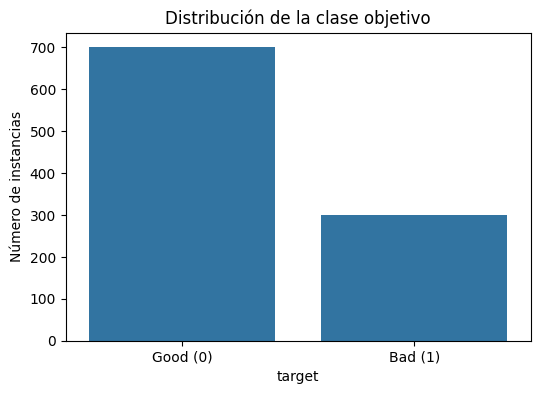

In [4]:
# Conteo y proporción
counts = df['target'].value_counts().sort_index()
props = df['target'].value_counts(normalize=True).sort_index()
print('Conteos:\n', counts)
print('\nProporciones:\n', props)

# Gráfico
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks([0,1], ['Good (0)', 'Bad (1)'])
plt.title('Distribución de la clase objetivo')
plt.ylabel('Número de instancias')
plt.show()

**Interpretación (negocio)**

* Conocer si existe desbalance. En el dataset clásico suele haber más buenos que malos. Un desbalance moderado afecta métricas como accuracy y obliga a priorizar métricas por clase (recall para malos si queremos reducir riesgo de aprobar a malos).

### 4. Valores faltantes y duplicados

In [5]:
# Valores faltantes
missing = df.isnull().sum()
missing[missing>0]

# Duplicados
dups = df.duplicated().sum()
print('Duplicados totales:', dups)

Duplicados totales: 0


**Reglas / acciones**

* Si missing.sum()==0: no se aplica imputación.

* Si hay valores NaN en num_cols: imputar con medianas (robusto) y crear columna indicador _missing para cada num_col con NaN (para traza y modelos lineales/árboles).

* Si hay duplicados: eliminar df = df.drop_duplicates() y documentar cuántas filas se eliminaron.

Justificación: imputar con la mediana evita sesgo por outliers; marcar faltantes preserva señal útil.

### 5. Análisis univariado y bivariado (gráficos sugeridos y código)

#### 5.1 Numéricos — histogramas y boxplots

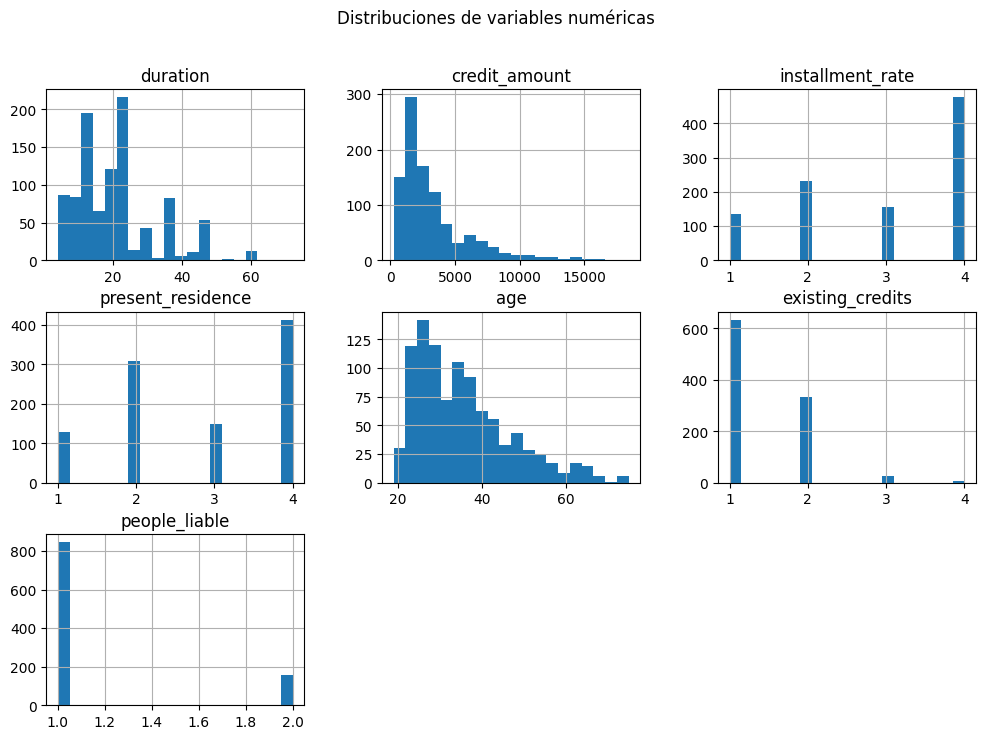

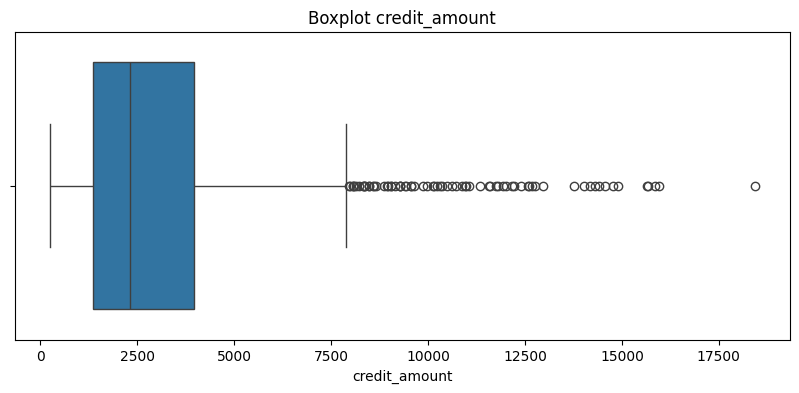

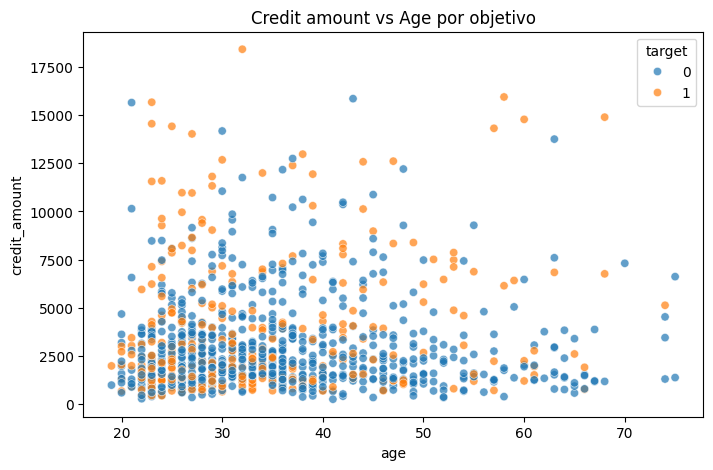

In [6]:
# Histogramas
df[num_cols].hist(bins=20, figsize=(12,8))
plt.suptitle('Distribuciones de variables numéricas')
plt.show()

# Boxplots para ver outliers (ej: credit_amount, age, duration)
plt.figure(figsize=(10,4))
sns.boxplot(x=df['credit_amount'])
plt.title('Boxplot credit_amount')
plt.show()

# Scatter: credit_amount vs age coloreado por target
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='age', y='credit_amount', hue='target', alpha=0.7)
plt.title('Credit amount vs Age por objetivo')
plt.show()

#### 5.2 Categóricas — conteos y tasas por clase

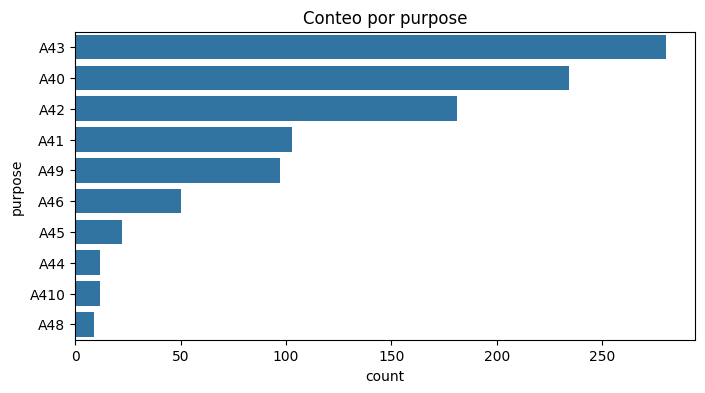

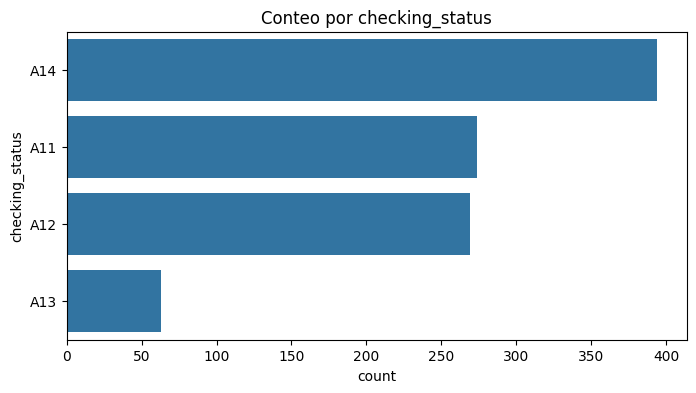

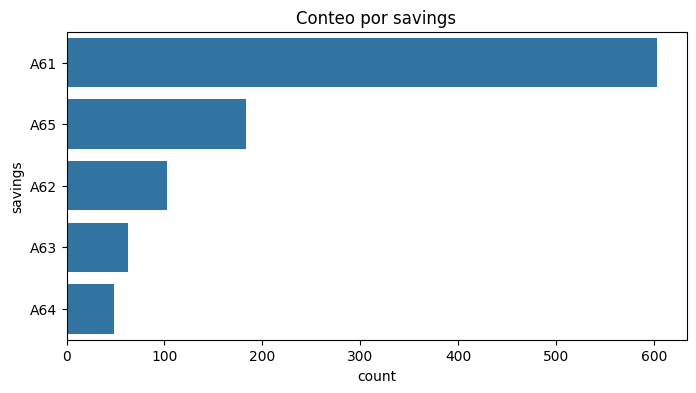

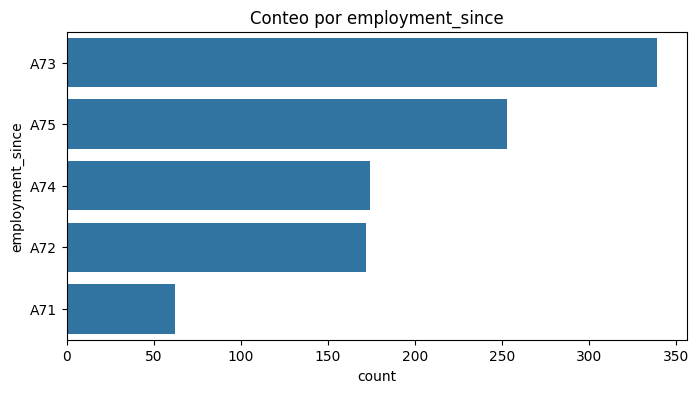

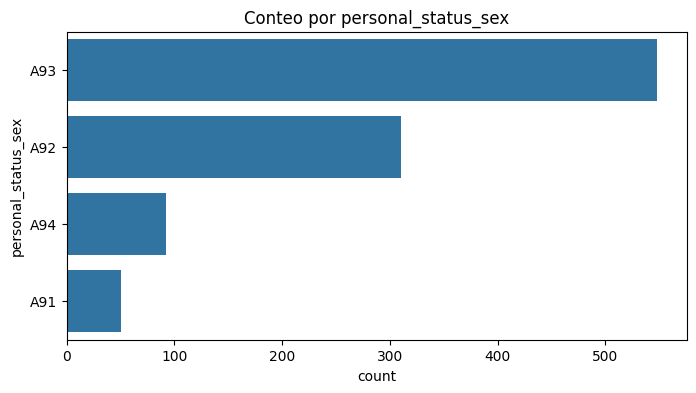

Tasa de default por purpose:
 purpose
A46     0.440000
A410    0.416667
A40     0.380342
A45     0.363636
A49     0.350515
A44     0.333333
A42     0.320442
A43     0.221429
A41     0.165049
A48     0.111111
Name: target, dtype: float64


In [7]:
cat_cols = [c for c in df.columns if df[c].dtype == 'object']

# Conteos de categorías para Atributos clave (purpose, checking_status, savings, employment_since, personal_status_sex)
for c in ['purpose','checking_status','savings','employment_since','personal_status_sex']:
    plt.figure(figsize=(8,4))
    sns.countplot(y=c, data=df, order=df[c].value_counts().index)
    plt.title(f'Conteo por {c}')
    plt.show()

# Tasa de default por categoría (ej: purpose)
default_rate = df.groupby('purpose')['target'].mean().sort_values(ascending=False)
print('Tasa de default por purpose:\n', default_rate)

**Cómo enlazar a hipótesis de negocio**

* Buscar categorías con tasa de default significativamente mayor. Por ejemplo, si "business" o "others" tienen mayor tasa de default, formular hipótesis: solicitudes para negocio pueden tener mayor riesgo (o coding issues).

* Variables numéricas: valores extremos de credit_amount pueden concentrar defaults.

### 6. Detección de outliers (reglas y código)

#### 6.1 Método IQR para variables clave

In [8]:
# Función para marcar outliers por IQR
def mark_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return ((series < low) | (series > high))

outlier_flags = pd.DataFrame()
for c in ['credit_amount','duration','age']:
    outlier_flags[c + '_out'] = mark_outliers_iqr(df[c])

outlier_flags.sum()

credit_amount_out    72
duration_out         70
age_out              23
dtype: int64

#### 6.2 Reglas prácticas de tratamiento

* credit_amount: capear (winsorize) al percentil 99 o imputar por la mediana del bin similar (por ejemplo mismo purpose y age bucket). Razon: evitar que unos pocos préstamos extremadamente grandes dominen modelos lineales.

* duration: si valores extremos son realmente errores (ej: duración = 999) corregir o eliminar; si son válidos, convertir a buckets (corto/medio/largo) para modelos lineales.

* age: capear por abajo (edad mínima razonable) y marcar jóvenes (< 18) si existen.

Código ejemplo para winsorize:

In [9]:
from scipy.stats import mstats
# winsorize al 1% y 99%
df['credit_amount_w'] = mstats.winsorize(df['credit_amount'], limits=[0.01, 0.01])

Justificación de negocio: capping reduce overfitting por outliers y mejora interpretabilidad de coeficientes.

### 7. Transformaciones y encoding (preparación para modelado)

**Estrategia recomendada**

* Variables categóricas con pocas modalidades: One-Hot Encoding (ej: housing, telephone, foreign_worker)

* Variables categóricas ordinales (employment_since, savings buckets): mapear a enteros ordenados si el orden tiene sentido.

* Para modelos lineales: usar dummies y evitar multicolinealidad (drop_first=True)

* Para árboles/ensemble: Label Encoding o mantener códigos originales.

* Escalado: solo para regresión logística y redes (StandardScaler o RobustScaler para variables numéricas). No escalar para árboles.

In [10]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# Ejemplo simple: one-hot para purpose
df_enc = pd.get_dummies(df, columns=['purpose','checking_status','savings','personal_status_sex','housing'], drop_first=True)

# Escalado para variables numéricas si usas modelos lineales o red
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])

### 8. Reglas de limpieza aplicadas (documentadas)

1. Conversión de tipos: asegurar que columnas numéricas sean int/float.
    * Impacto: evita errores en modelos; permite estadísticas descriptivas correctas.
2. Mapeo de target a binario (0=Good, 1=Bad).
    * Impacto: simplifica evaluación y coincide con las métricas de riesgo (bad = evento positivo que queremos detectar).
3. Detección y eliminación de duplicados.
    * Regla: df = df.drop_duplicates().
    * Impacto: evita sobrecontar observaciones; si muchos duplicados, investigar origen.
4. Tratamiento de faltantes.
    * Regla: imputar numéricos con mediana y crear flag _is_missing por variable.
    * Impacto: mantiene robustez y preserva información que podría ser predictiva.
5. Outliers.
    * Regla: marcar outliers por IQR; winsorize al 1%/99% para credit_amount y capear extremos razonables.
    * Impacto: reduce influencia desproporcionada en coeficientes y en gradientes de redes; conserva la mayoría de datos.
6. Encoding y escalado según modelo (One-Hot para regresión, Label para árboles; escala para redes y regresión logística).
    * Impacto: prepara datos para que cada algoritmo funcione de forma óptima y que las interpretaciones (coeficientes) sean coherentes.

### 9. Hipótesis de negocio conectadas a EDA

* Hipótesis 1: solicitantes con credit_amount elevado y duration largo tienen mayor probabilidad de default. Acción: crear segmentos por quintiles y comparar tasas de default.

* Hipótesis 2: falta de savings o historial de crédito crítico (credit_history tipo A34) se asocia con mayor tasa de malos.

* Hipótesis 3: ciertas finalidades (purpose) muestran más riesgo (por ejemplo, "business" o "others").

Para comprobarlas: agrupar por esos bins/categorías y comparar target.mean(); añadir gráficas de barras con tasas de default.

## 2) Modelado con probabilidades calibradas

In [11]:
# Librerías para modelado y calibración
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve,
                             classification_report)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

# Configuración
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [12]:
# Asumiendo que ya tienes df_enc del EDA con limpieza aplicada
# Separar features (X) y target (y)

# Variables a excluir del modelado (target y cualquier ID)
target_col = 'target'
exclude_cols = [target_col]

# Crear X e y
X = df.drop(columns=exclude_cols)
y = df[target_col]

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribución de clases en y:")
print(y.value_counts())
print(f"\nProporción de clases:")
print(y.value_counts(normalize=True))

Shape de X: (1000, 21)
Shape de y: (1000,)

Distribución de clases en y:
target
0    700
1    300
Name: count, dtype: int64

Proporción de clases:
target
0    0.7
1    0.3
Name: proportion, dtype: float64


In [13]:
# DIAGNÓSTICO: Verificar qué columnas tienen problemas
print("="*60)
print("DIAGNÓSTICO DE TIPOS DE DATOS")
print("="*60)

print("\nTipos de datos actuales:")
print(X.dtypes.value_counts())

print("\n" + "="*60)
print("COLUMNAS CON TIPO 'object' (categóricas sin codificar):")
print("="*60)
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Total: {len(cat_cols)}")
print(cat_cols)

if len(cat_cols) > 0:
    print("\nEjemplos de valores en estas columnas:")
    for col in cat_cols[:5]:  # Mostrar primeras 5
        print(f"\n{col}:")
        print(X[col].value_counts().head())
else:
    print("\n✓ No hay columnas categóricas sin codificar")

DIAGNÓSTICO DE TIPOS DE DATOS

Tipos de datos actuales:
object    13
int64      8
Name: count, dtype: int64

COLUMNAS CON TIPO 'object' (categóricas sin codificar):
Total: 13
['checking_status', 'credit_history', 'purpose', 'savings', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

Ejemplos de valores en estas columnas:

checking_status:
checking_status
A14    394
A11    274
A12    269
A13     63
Name: count, dtype: int64

credit_history:
credit_history
A32    530
A34    293
A33     88
A31     49
A30     40
Name: count, dtype: int64

purpose:
purpose
A43    280
A40    234
A42    181
A41    103
A49     97
Name: count, dtype: int64

savings:
savings
A61    603
A65    183
A62    103
A63     63
A64     48
Name: count, dtype: int64

employment_since:
employment_since
A73    339
A75    253
A74    174
A72    172
A71     62
Name: count, dtype: int64


In [14]:
# IMPORTANTE: Hacer split ANTES de encoding para evitar data leakage
# Split estratificado 70/30

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

print("="*60)
print("SPLIT DE DATOS")
print("="*60)
print(f"Tamaño train: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Tamaño test: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribución en train:")
print(y_train.value_counts())
print(f"\nDistribución en test:")
print(y_test.value_counts())
print(f"\nProporción Bad en train: {y_train.mean():.3f}")
print(f"Proporción Bad en test: {y_test.mean():.3f}")

SPLIT DE DATOS
Tamaño train: 700 (70.0%)
Tamaño test: 300 (30.0%)

Distribución en train:
target
0    490
1    210
Name: count, dtype: int64

Distribución en test:
target
0    210
1     90
Name: count, dtype: int64

Proporción Bad en train: 0.300
Proporción Bad en test: 0.300


In [15]:
# SOLUCIÓN: Aplicar encoding a todas las variables categóricas

# Paso 1: Identificar columnas categóricas
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("="*60)
print("APLICANDO ONE-HOT ENCODING")
print("="*60)
print(f"Columnas categóricas encontradas: {len(categorical_cols)}")

if len(categorical_cols) > 0:
    print("\nColumnas a codificar:")
    for i, col in enumerate(categorical_cols, 1):
        n_cats = X_train[col].nunique()
        print(f"  {i}. {col}: {n_cats} categorías")

    # Encoding en train
    X_train_encoded = pd.get_dummies(
        X_train,
        columns=categorical_cols,
        drop_first=True,  # Evitar multicolinealidad
        prefix=categorical_cols
    )

    # Encoding en test (mismo esquema)
    X_test_encoded = pd.get_dummies(
        X_test,
        columns=categorical_cols,
        drop_first=True,
        prefix=categorical_cols
    )

    # Paso 3: Alinear columnas (test debe tener mismas columnas que train)
    # Agregar columnas faltantes en test con valor 0
    missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
    for col in missing_cols:
        X_test_encoded[col] = 0

    # Eliminar columnas extra en test que no están en train
    extra_cols = set(X_test_encoded.columns) - set(X_train_encoded.columns)
    X_test_encoded = X_test_encoded.drop(columns=list(extra_cols))

    # Reordenar columnas para que coincidan
    X_test_encoded = X_test_encoded[X_train_encoded.columns]

    # Actualizar X_train y X_test
    X_train = X_train_encoded
    X_test = X_test_encoded

    print(f"\n✓ Encoding completado")
    print(f"  Shape original: {len(categorical_cols)} columnas categóricas")
    print(f"  Shape final X_train: {X_train.shape}")
    print(f"  Shape final X_test: {X_test.shape}")
    print(f"  Total features: {X_train.shape[1]}")

else:
    print("\n✓ No hay columnas categóricas, dataset ya está codificado")

# Verificación final
print("\n" + "="*60)
print("VERIFICACIÓN FINAL")
print("="*60)
print("Tipos de datos restantes:")
print(X_train.dtypes.value_counts())

# Verificar que no hay más 'object'
if 'object' in X_train.dtypes.values:
    print("\n⚠️ ADVERTENCIA: Aún quedan columnas tipo 'object'")
    print(X_train.select_dtypes(include=['object']).columns.tolist())
else:
    print("\n✓ Todos los datos son numéricos. Listo para modelar.")

APLICANDO ONE-HOT ENCODING
Columnas categóricas encontradas: 13

Columnas a codificar:
  1. checking_status: 4 categorías
  2. credit_history: 5 categorías
  3. purpose: 10 categorías
  4. savings: 5 categorías
  5. employment_since: 5 categorías
  6. personal_status_sex: 4 categorías
  7. other_debtors: 3 categorías
  8. property: 4 categorías
  9. other_installment_plans: 3 categorías
  10. housing: 3 categorías
  11. job: 4 categorías
  12. telephone: 2 categorías
  13. foreign_worker: 2 categorías

✓ Encoding completado
  Shape original: 13 columnas categóricas
  Shape final X_train: (700, 49)
  Shape final X_test: (300, 49)
  Total features: 49

VERIFICACIÓN FINAL
Tipos de datos restantes:
bool     41
int64     8
Name: count, dtype: int64

✓ Todos los datos son numéricos. Listo para modelar.


In [16]:
# Escalado SOLO para modelos que lo requieren (regresión y redes)
# NO escalar para árboles y Random Forest

print("="*60)
print("ESCALADO DE DATOS")
print("="*60)

# Crear copia para modelos lineales/redes
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajustar scaler solo con train
scaler = StandardScaler()
scaler.fit(X_train_scaled)

# Transformar ambos conjuntos
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_scaled),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_scaled),
    columns=X_test.columns,
    index=X_test.index
)

print("✓ Escalado completado")
print(f"  Media de X_train_scaled: {X_train_scaled.mean().mean():.6f}")
print(f"  Std de X_train_scaled: {X_train_scaled.std().mean():.6f}")
print(f"\nNOTA:")
print("  • X_train_scaled / X_test_scaled → Para Regresión Logística y Red Neuronal")
print("  • X_train / X_test → Para Árboles y Random Forest")

ESCALADO DE DATOS
✓ Escalado completado
  Media de X_train_scaled: -0.000000
  Std de X_train_scaled: 1.000715

NOTA:
  • X_train_scaled / X_test_scaled → Para Regresión Logística y Red Neuronal
  • X_train / X_test → Para Árboles y Random Forest


In [17]:
def calibrate_model(base_model, X_train, y_train, method='isotonic', cv=5):
    """
    Calibra un modelo usando CalibratedClassifierCV.

    Parámetros:
    - base_model: modelo base ya entrenado o sin entrenar
    - X_train: features de entrenamiento
    - y_train: target de entrenamiento
    - method: 'sigmoid' (Platt) o 'isotonic'
    - cv: número de folds para calibración

    Retorna: modelo calibrado
    """
    calibrated = CalibratedClassifierCV(
        base_model,
        method=method,
        cv=cv
    )
    calibrated.fit(X_train, y_train)
    return calibrated

print("="*60)
print("MÉTODOS DE CALIBRACIÓN")
print("="*60)
print("• 'sigmoid' (Platt): Asume relación sigmoidal")
print("  - Ventajas: Funciona bien con pocos datos")
print("  - Desventajas: Asume forma paramétrica")
print("\n• 'isotonic': Regresión isotónica no paramétrica")
print("  - Ventajas: Más flexible, mejor calibración con suficientes datos")
print("  - Desventajas: Requiere más datos (n > 500)")
print(f"\nNuestra elección: 'isotonic' (tenemos n={len(X_train)})")

MÉTODOS DE CALIBRACIÓN
• 'sigmoid' (Platt): Asume relación sigmoidal
  - Ventajas: Funciona bien con pocos datos
  - Desventajas: Asume forma paramétrica

• 'isotonic': Regresión isotónica no paramétrica
  - Ventajas: Más flexible, mejor calibración con suficientes datos
  - Desventajas: Requiere más datos (n > 500)

Nuestra elección: 'isotonic' (tenemos n=700)


In [18]:
# Estructura para guardar todo
models_dict = {
    'Logistic Regression': {},
    'Decision Tree': {},
    'Random Forest': {},
    'Neural Network': {}
}

print("="*60)
print("ESTRUCTURA DE ALMACENAMIENTO")
print("="*60)
print("Para cada modelo guardaremos:")
print("  • 'base': Modelo sin calibrar")
print("  • 'calibrated': Modelo calibrado")
print("  • 'y_pred_proba': Probabilidades en test")
print("  • 'y_pred': Predicciones binarias (umbral 0.5)")
print("  • 'threshold': Umbral óptimo encontrado")
print("  • 'metrics': Métricas de evaluación")
print("  • Información específica del modelo (coefs, importances, etc.)")

ESTRUCTURA DE ALMACENAMIENTO
Para cada modelo guardaremos:
  • 'base': Modelo sin calibrar
  • 'calibrated': Modelo calibrado
  • 'y_pred_proba': Probabilidades en test
  • 'y_pred': Predicciones binarias (umbral 0.5)
  • 'threshold': Umbral óptimo encontrado
  • 'metrics': Métricas de evaluación
  • Información específica del modelo (coefs, importances, etc.)


In [19]:
print("\n" + "="*60)
print("MODELO 1: REGRESIÓN LOGÍSTICA")
print("="*60)

# Entrenar modelo base con datos ESCALADOS
lr_base = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight='balanced',  # Manejar desbalance
    solver='lbfgs',
    penalty='l2',
    C=1.0  # Parámetro de regularización (inverso de fuerza)
)

lr_base.fit(X_train_scaled, y_train)

# Guardar en diccionario
models_dict['Logistic Regression']['base'] = lr_base

# Predicciones base (sin calibrar)
y_pred_proba_base = lr_base.predict_proba(X_test_scaled)[:, 1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

print(f"✓ Modelo entrenado")
print(f"  Número de features: {X_train_scaled.shape[1]}")
print(f"  Número de iteraciones: {lr_base.n_iter_[0]}")
print(f"\nMétricas base (sin calibrar, umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_base):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_base):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_base):.4f}")


MODELO 1: REGRESIÓN LOGÍSTICA
✓ Modelo entrenado
  Número de features: 49
  Número de iteraciones: 25

Métricas base (sin calibrar, umbral=0.5):
  Accuracy: 0.7333
  Precision: 0.5391
  Recall: 0.7667
  F1-Score: 0.6330
  ROC-AUC: 0.7989


In [20]:
# Calibrar con método isotonic
print("\n" + "-"*60)
print("CALIBRANDO MODELO...")
print("-"*60)

lr_calibrated = calibrate_model(
    lr_base,
    X_train_scaled,
    y_train,
    method='isotonic',
    cv=5
)

# Predicciones calibradas
y_pred_proba_cal = lr_calibrated.predict_proba(X_test_scaled)[:, 1]
y_pred_cal = (y_pred_proba_cal >= 0.5).astype(int)

# Guardar
models_dict['Logistic Regression']['calibrated'] = lr_calibrated
models_dict['Logistic Regression']['y_pred_proba'] = y_pred_proba_cal
models_dict['Logistic Regression']['y_pred'] = y_pred_cal

print(f"✓ Calibración completada")
print(f"\nMétricas calibradas (umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_cal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_cal):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_cal):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_cal):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cal):.4f}")

# Comparación
print(f"\nCambio en probabilidades:")
print(f"  Correlación base vs calibrada: {np.corrcoef(y_pred_proba_base, y_pred_proba_cal)[0,1]:.4f}")
print(f"  Diferencia promedio: {np.abs(y_pred_proba_base - y_pred_proba_cal).mean():.4f}")


------------------------------------------------------------
CALIBRANDO MODELO...
------------------------------------------------------------
✓ Calibración completada

Métricas calibradas (umbral=0.5):
  Accuracy: 0.7667
  Precision: 0.7273
  Recall: 0.3556
  F1-Score: 0.4776
  ROC-AUC: 0.7964

Cambio en probabilidades:
  Correlación base vs calibrada: 0.9754
  Diferencia promedio: 0.1443


In [73]:
# Extraer coeficientes del modelo base
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lr_base.coef_[0],
    'Abs_Coefficient': np.abs(lr_base.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

# Calcular Odds Ratios
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])

# Agregar interpretación
coef_df['Interpretation'] = coef_df['Coefficient'].apply(
    lambda x: 'Aumenta riesgo' if x > 0 else 'Reduce riesgo'
)

# Mostrar top 20
print("\n" + "="*60)
print("COEFICIENTES Y ODDS RATIOS (Top 20)")
print("="*60)
print(coef_df.head(20).to_string(index=False))

# Estadísticas
print("\n" + "="*60)
print("ESTADÍSTICAS DE COEFICIENTES")
print("="*60)
print(f"Coeficientes positivos (aumentan riesgo): {(coef_df['Coefficient'] > 0).sum()}")
print(f"Coeficientes negativos (reducen riesgo): {(coef_df['Coefficient'] < 0).sum()}")
print(f"Coeficiente máximo: {coef_df['Coefficient'].max():.4f} ({coef_df.iloc[0]['Feature']})")
print(f"Coeficiente mínimo: {coef_df['Coefficient'].min():.4f}")

# Interpretación de negocio
print("\n" + "="*60)
print("INTERPRETACIÓN PARA NEGOCIO")
print("="*60)
top_risk = coef_df.head(3)
print("\nTop 3 factores que AUMENTAN riesgo de default:")
for i, row in enumerate(top_risk[top_risk['Coefficient'] > 0].iterrows(), 1):
    feat, data = row
    if i <= 3:
        print(f"{i}. {data['Feature']}")
        print(f"   OR = {data['Odds_Ratio']:.3f} (aumenta odds en {(data['Odds_Ratio']-1)*100:.1f}%)")

top_protect = coef_df[coef_df['Coefficient'] < 0].head(3)
print("\nTop 3 factores que REDUCEN riesgo de default:")
for i, row in enumerate(top_protect.iterrows(), 1):
    feat, data = row
    print(f"{i}. {data['Feature']}")
    print(f"   OR = {data['Odds_Ratio']:.3f} (reduce odds en {(1-data['Odds_Ratio'])*100:.1f}%)")

# Guardar
models_dict['Logistic Regression']['coefficients'] = coef_df


COEFICIENTES Y ODDS RATIOS (Top 20)
                     Feature  Coefficient  Abs_Coefficient  Odds_Ratio Interpretation
         checking_status_A14    -0.816671         0.816671    0.441900  Reduce riesgo
          credit_history_A34    -0.561905         0.561905    0.570122  Reduce riesgo
        employment_since_A74    -0.483053         0.483053    0.616897  Reduce riesgo
               property_A124     0.413104         0.413104    1.511502 Aumenta riesgo
                 savings_A65    -0.398987         0.398987    0.671000  Reduce riesgo
other_installment_plans_A143    -0.386710         0.386710    0.679288  Reduce riesgo
     personal_status_sex_A93    -0.358336         0.358336    0.698838  Reduce riesgo
            installment_rate     0.339793         0.339793    1.404657 Aumenta riesgo
                    duration     0.334153         0.334153    1.396756 Aumenta riesgo
         foreign_worker_A202    -0.331527         0.331527    0.717827  Reduce riesgo
                 

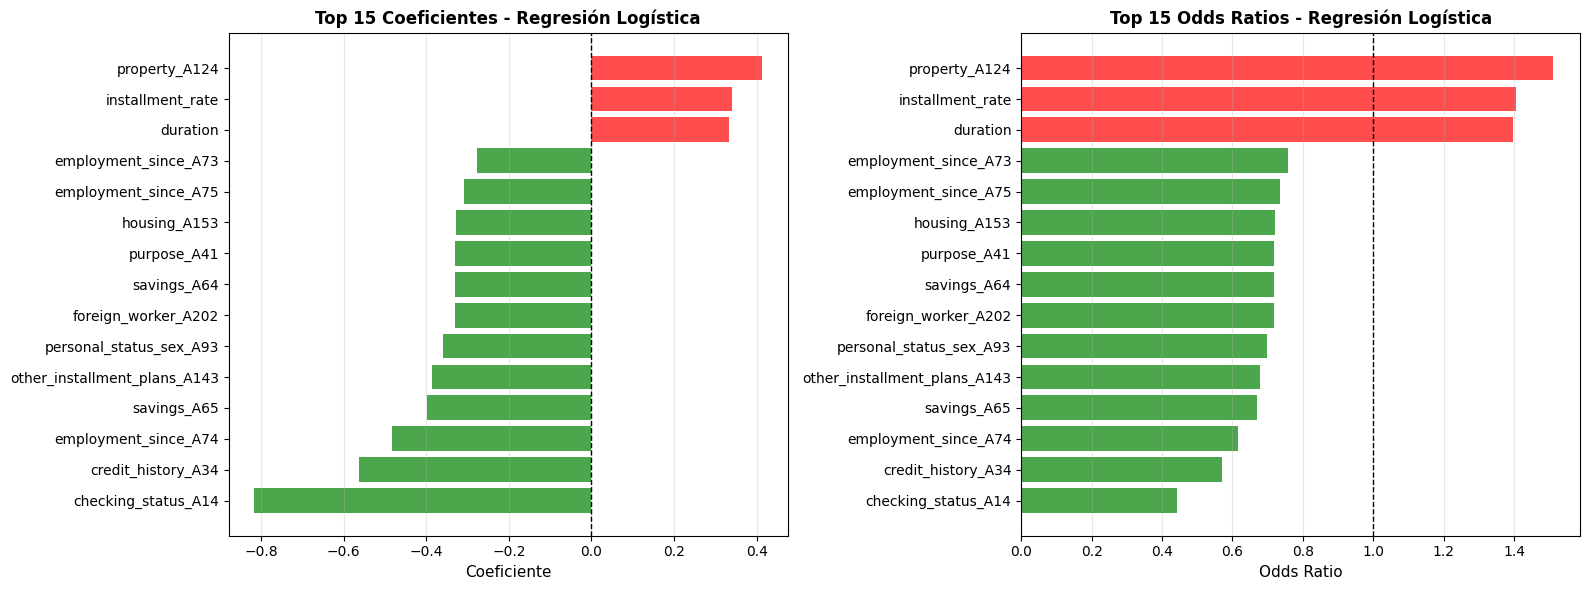

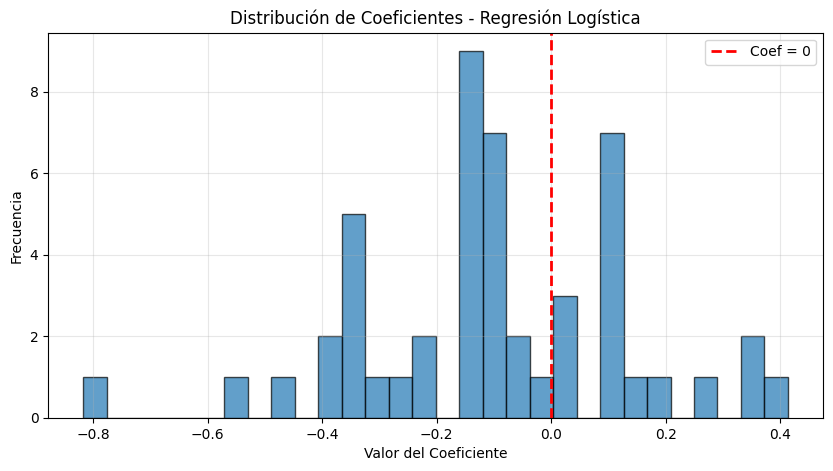

In [22]:
# Gráfico de coeficientes top 15
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Coeficientes
top_coefs = coef_df.head(15).sort_values('Coefficient')
colors = ['red' if x > 0 else 'green' for x in top_coefs['Coefficient']]
ax1.barh(top_coefs['Feature'], top_coefs['Coefficient'], color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Coeficiente', fontsize=11)
ax1.set_title('Top 15 Coeficientes - Regresión Logística', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Odds Ratios
top_or = coef_df.head(15).sort_values('Odds_Ratio')
colors_or = ['red' if x > 1 else 'green' for x in top_or['Odds_Ratio']]
ax2.barh(top_or['Feature'], top_or['Odds_Ratio'], color=colors_or, alpha=0.7)
ax2.axvline(x=1, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Odds Ratio', fontsize=11)
ax2.set_title('Top 15 Odds Ratios - Regresión Logística', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Distribución de coeficientes
plt.figure(figsize=(10, 5))
plt.hist(coef_df['Coefficient'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Coef = 0')
plt.xlabel('Valor del Coeficiente')
plt.ylabel('Frecuencia')
plt.title('Distribución de Coeficientes - Regresión Logística')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [23]:
print("\n" + "="*60)
print("MODELO 2: ÁRBOL DE DECISIÓN")
print("="*60)

# Entrenar árbol con profundidad limitada para interpretabilidad
# USAR DATOS SIN ESCALAR
dt_base = DecisionTreeClassifier(
    max_depth=5,  # Limitar profundidad para reglas interpretables
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    criterion='gini'  # Alternativa: 'entropy'
)

dt_base.fit(X_train, y_train)

# Guardar
models_dict['Decision Tree']['base'] = dt_base

# Predicciones base
y_pred_proba_base = dt_base.predict_proba(X_test)[:, 1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

print(f"✓ Modelo entrenado")
print(f"  Profundidad del árbol: {dt_base.get_depth()}")
print(f"  Número de hojas: {dt_base.get_n_leaves()}")
print(f"  Número de nodos: {dt_base.tree_.node_count}")
print(f"\nMétricas base (sin calibrar, umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_base):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_base):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_base):.4f}")


MODELO 2: ÁRBOL DE DECISIÓN
✓ Modelo entrenado
  Profundidad del árbol: 5
  Número de hojas: 13
  Número de nodos: 25

Métricas base (sin calibrar, umbral=0.5):
  Accuracy: 0.6200
  Precision: 0.4241
  Recall: 0.7444
  F1-Score: 0.5403
  ROC-AUC: 0.7265


In [24]:
# Calibrar árbol
print("\n" + "-"*60)
print("CALIBRANDO MODELO...")
print("-"*60)

dt_calibrated = calibrate_model(
    dt_base,
    X_train,
    y_train,
    method='isotonic',
    cv=5
)

# Predicciones calibradas
y_pred_proba_cal = dt_calibrated.predict_proba(X_test)[:, 1]
y_pred_cal = (y_pred_proba_cal >= 0.5).astype(int)

# Guardar
models_dict['Decision Tree']['calibrated'] = dt_calibrated
models_dict['Decision Tree']['y_pred_proba'] = y_pred_proba_cal
models_dict['Decision Tree']['y_pred'] = y_pred_cal

print(f"✓ Calibración completada")
print(f"\nMétricas calibradas (umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_cal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_cal):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_cal):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_cal):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cal):.4f}")

# Comparación
print(f"\nCambio en probabilidades:")
print(f"  Correlación base vs calibrada: {np.corrcoef(y_pred_proba_base, y_pred_proba_cal)[0,1]:.4f}")
print(f"  Diferencia promedio: {np.abs(y_pred_proba_base - y_pred_proba_cal).mean():.4f}")


------------------------------------------------------------
CALIBRANDO MODELO...
------------------------------------------------------------
✓ Calibración completada

Métricas calibradas (umbral=0.5):
  Accuracy: 0.7000
  Precision: 0.5000
  Recall: 0.1000
  F1-Score: 0.1667
  ROC-AUC: 0.7444

Cambio en probabilidades:
  Correlación base vs calibrada: 0.9037
  Diferencia promedio: 0.1697


In [25]:
# Extraer reglas en formato texto
print("\n" + "="*60)
print("REGLAS DEL ÁRBOL (formato texto)")
print("="*60)

tree_rules = export_text(dt_base, feature_names=list(X_train.columns), max_depth=4)
print(tree_rules[:3000])  # Mostrar primeras reglas

# Guardar reglas completas
models_dict['Decision Tree']['rules_text'] = tree_rules

print("\n[...reglas adicionales omitidas por espacio...]")
print(f"\nTotal de caracteres en reglas: {len(tree_rules)}")


REGLAS DEL ÁRBOL (formato texto)
|--- checking_status_A14 <= 0.50
|   |--- duration <= 11.50
|   |   |--- age <= 35.50
|   |   |   |--- class: 1
|   |   |--- age >  35.50
|   |   |   |--- class: 0
|   |--- duration >  11.50
|   |   |--- savings_A65 <= 0.50
|   |   |   |--- duration <= 22.50
|   |   |   |   |--- credit_amount <= 954.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- credit_amount >  954.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- duration >  22.50
|   |   |   |   |--- installment_rate <= 2.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- installment_rate >  2.50
|   |   |   |   |   |--- class: 1
|   |   |--- savings_A65 >  0.50
|   |   |   |--- class: 0
|--- checking_status_A14 >  0.50
|   |--- other_installment_plans_A143 <= 0.50
|   |   |--- class: 1
|   |--- other_installment_plans_A143 >  0.50
|   |   |--- credit_history_A33 <= 0.50
|   |   |   |--- personal_status_sex_A92 <= 0.50
|   |   |   |   |--- property_A122 <= 0.50
|   |   |   |   

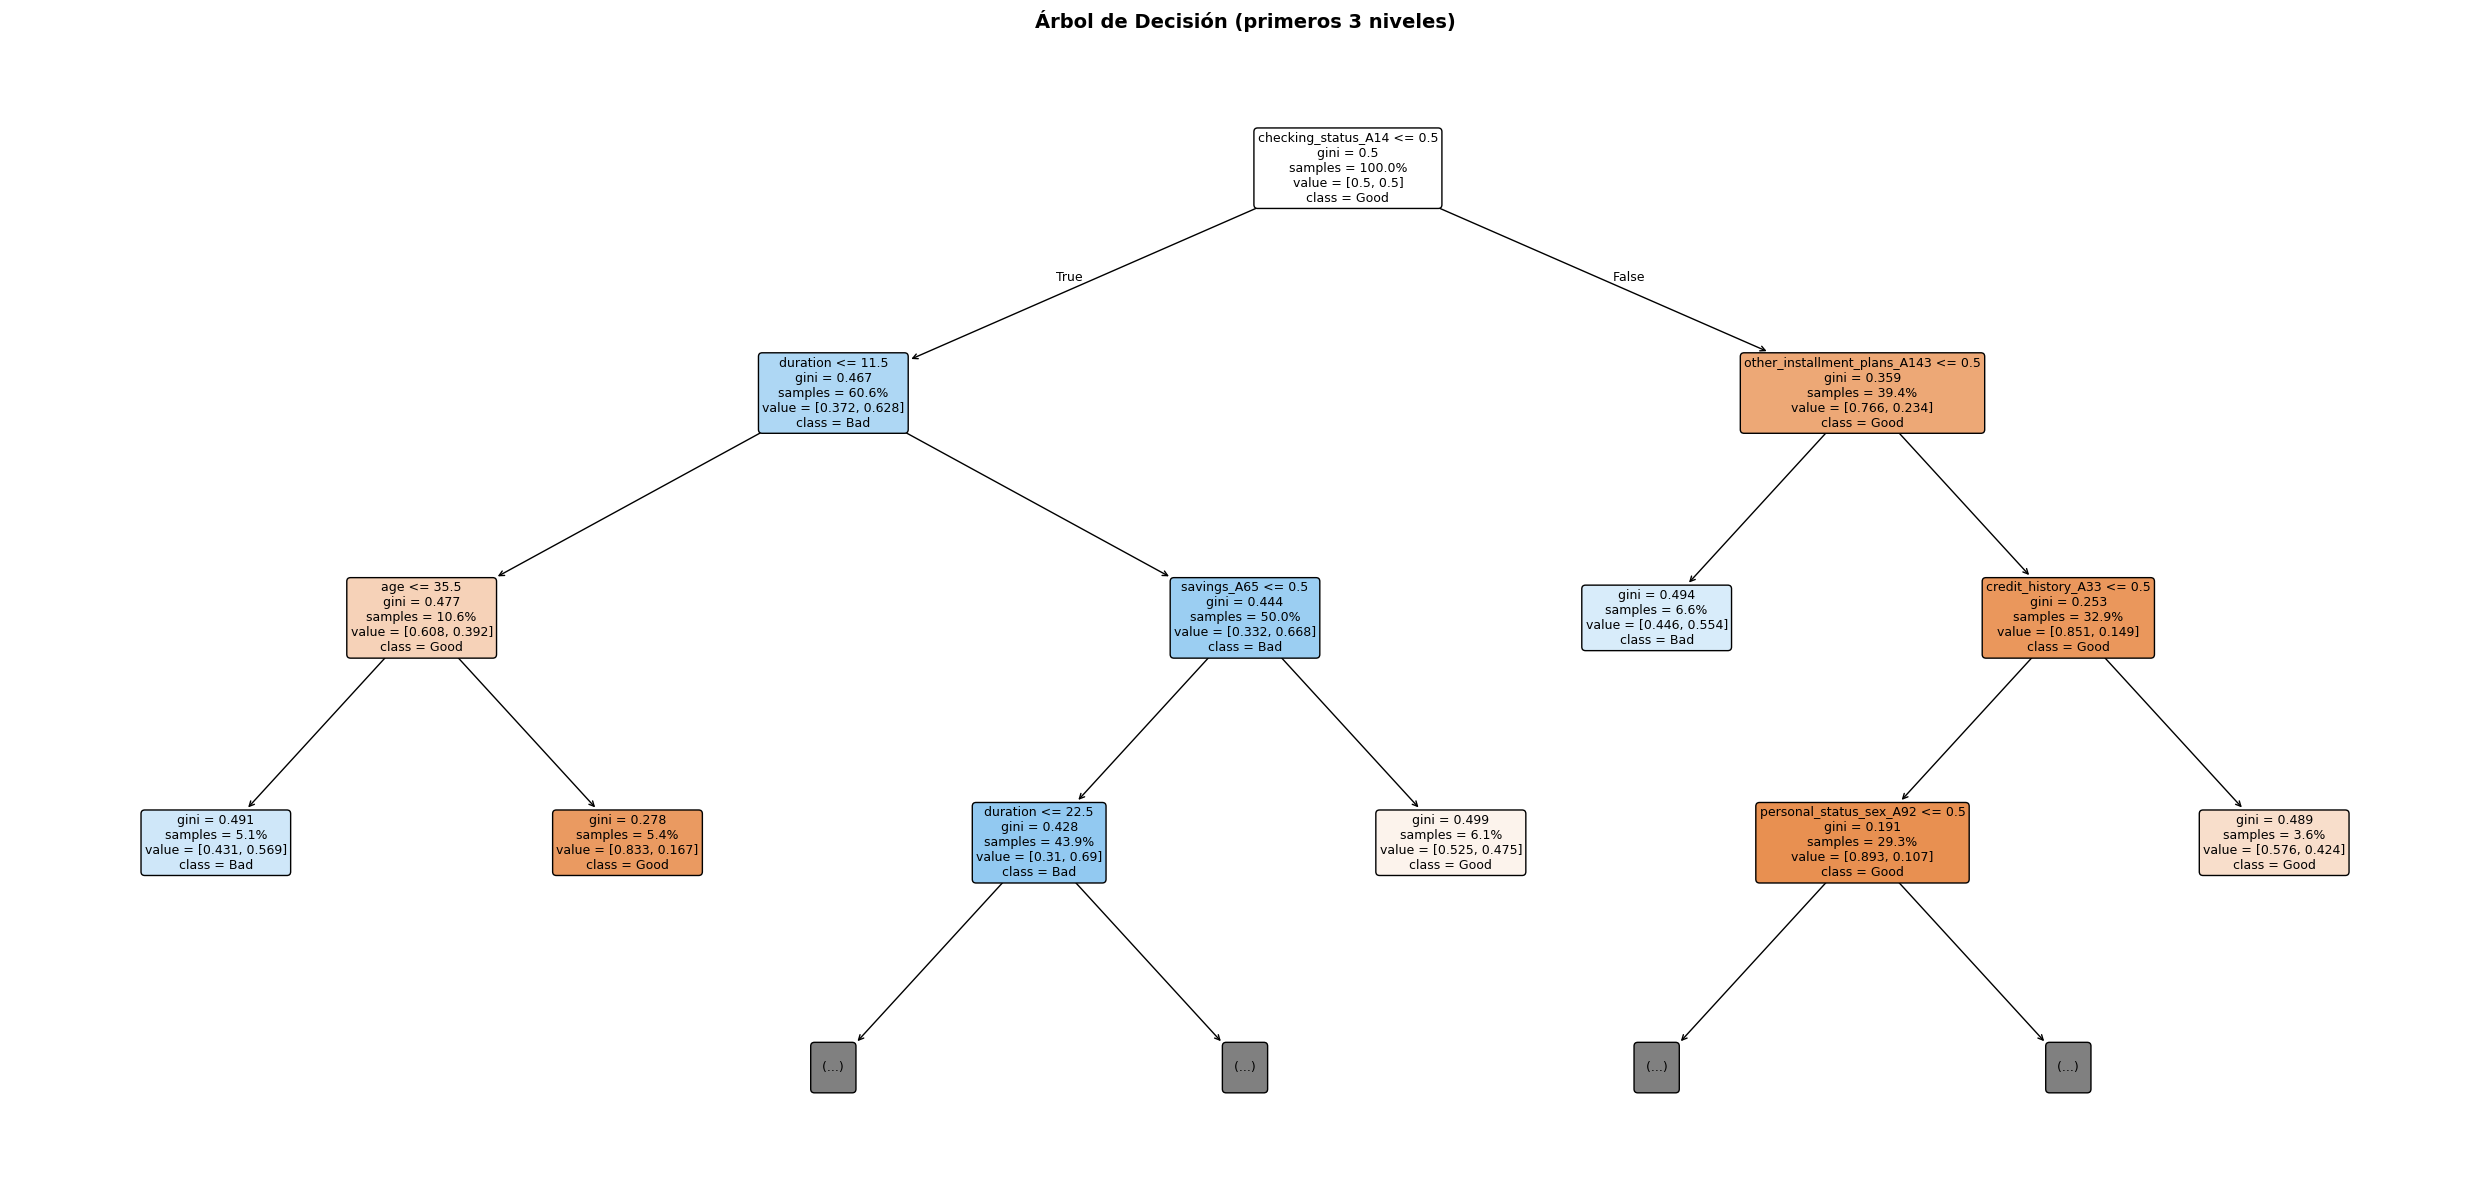

Interpretación del gráfico:
• Color naranja: Mayoría clase Bad (alto riesgo)
• Color azul: Mayoría clase Good (bajo riesgo)
• Intensidad del color: Pureza del nodo
• Valores en nodos: [samples de Good, samples de Bad]


In [26]:
# Visualizar árbol (solo primeros niveles para legibilidad)
plt.figure(figsize=(25, 12))
plot_tree(
    dt_base,
    feature_names=X_train.columns,
    class_names=['Good', 'Bad'],
    filled=True,
    rounded=True,
    max_depth=3,  # Mostrar solo primeros 3 niveles
    fontsize=9,
    proportion=True  # Mostrar proporciones en vez de conteos
)
plt.title('Árbol de Decisión (primeros 3 niveles)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Interpretación del gráfico:")
print("• Color naranja: Mayoría clase Bad (alto riesgo)")
print("• Color azul: Mayoría clase Good (bajo riesgo)")
print("• Intensidad del color: Pureza del nodo")
print("• Valores en nodos: [samples de Good, samples de Bad]")


IMPORTANCIA DE FEATURES - ÁRBOL (Top 20)
                     Feature  Importance
         checking_status_A14    0.487812
                    duration    0.134745
other_installment_plans_A143    0.128047
                         age    0.072230
               credit_amount    0.044275
          credit_history_A33    0.042255
                 savings_A65    0.036003
     personal_status_sex_A92    0.026237
            installment_rate    0.023980
               property_A122    0.004415
          other_debtors_A103    0.000000
        employment_since_A73    0.000000
        employment_since_A74    0.000000
        employment_since_A75    0.000000
     personal_status_sex_A93    0.000000
     personal_status_sex_A94    0.000000
          other_debtors_A102    0.000000
                    job_A173    0.000000
                    job_A172    0.000000
               property_A123    0.000000

Total features con importancia > 0: 10
Suma de importancias: 1.0000


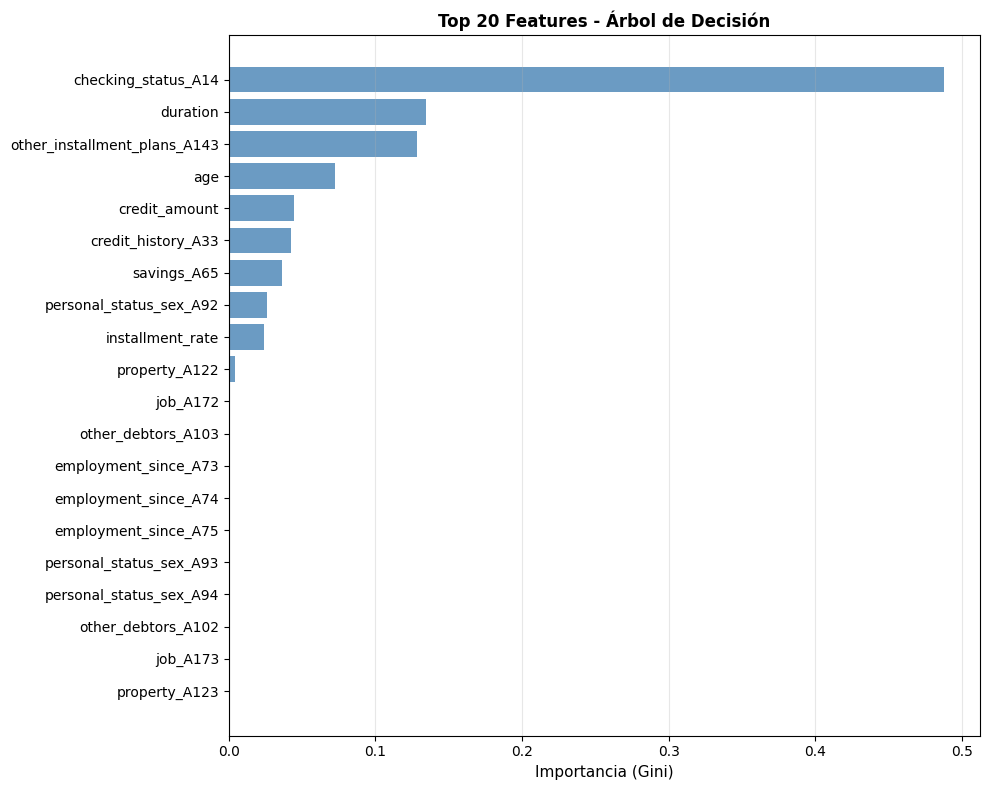

In [27]:
# Importancia de features
feature_importance_dt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_base.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("IMPORTANCIA DE FEATURES - ÁRBOL (Top 20)")
print("="*60)
print(feature_importance_dt.head(20).to_string(index=False))

# Estadísticas
print(f"\nTotal features con importancia > 0: {(feature_importance_dt['Importance'] > 0).sum()}")
print(f"Suma de importancias: {feature_importance_dt['Importance'].sum():.4f}")

# Gráfico
plt.figure(figsize=(10, 8))
top_20 = feature_importance_dt.head(20).sort_values('Importance')
plt.barh(top_20['Feature'], top_20['Importance'], color='steelblue', alpha=0.8)
plt.xlabel('Importancia (Gini)', fontsize=11)
plt.title('Top 20 Features - Árbol de Decisión', fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Guardar
models_dict['Decision Tree']['feature_importance'] = feature_importance_dt

In [28]:
# Función para extraer caminos del árbol
from sklearn.tree import _tree

def extract_rules(tree, feature_names):
    """Extrae reglas del árbol en formato legible"""
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []

    def recurse(node, path, value):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # Rama izquierda (<=)
            p_left = path + [(name, '<=', threshold)]
            recurse(tree_.children_left[node], p_left, value)

            # Rama derecha (>)
            p_right = path + [(name, '>', threshold)]
            recurse(tree_.children_right[node], p_right, value)
        else:
            # Hoja: guardar regla y proporción de clase
            class_counts = tree_.value[node][0]
            total = sum(class_counts)
            prob_bad = class_counts[1] / total if total > 0 else 0
            n_samples = int(total)
            paths.append((path, prob_bad, n_samples))

    recurse(0, [], tree_.value[0])
    return paths

# Extraer reglas
rules = extract_rules(dt_base, X_train.columns)

# Filtrar reglas de alto riesgo (prob > 0.6 de ser Bad)
high_risk_rules = [(r, p, n) for r, p, n in rules if p > 0.6 and n >= 10]
high_risk_rules = sorted(high_risk_rules, key=lambda x: x[1], reverse=True)

print("\n" + "="*60)
print(f"REGLAS DE ALTO RIESGO (prob(Bad) > 0.6, n >= 10)")
print("="*60)
print(f"Total reglas de alto riesgo encontradas: {len(high_risk_rules)}")

for i, (rule, prob, n) in enumerate(high_risk_rules[:5], 1):
    print(f"\n{'='*50}")
    print(f"REGLA {i}: Riesgo={prob:.1%}, Casos={n}")
    print(f"{'='*50}")
    print("Condiciones:")
    for feat, op, thr in rule:
        print(f"  └─ {feat} {op} {thr:.3f}")
    print(f"\nInterpretación: {prob*100:.1f}% de los casos que cumplen")
    print(f"                estas condiciones son Bad (n={n} casos)")

# Guardar top 3
models_dict['Decision Tree']['high_risk_rules'] = high_risk_rules[:3]

# Reglas de bajo riesgo (opcional)
low_risk_rules = [(r, p, n) for r, p, n in rules if p < 0.3 and n >= 10]
low_risk_rules = sorted(low_risk_rules, key=lambda x: x[0])

print("\n" + "="*60)
print(f"REGLAS DE BAJO RIESGO (prob(Bad) < 0.3, n >= 10)")
print("="*60)
print(f"Total reglas de bajo riesgo encontradas: {len(low_risk_rules)}")

for i, (rule, prob, n) in enumerate(low_risk_rules[:3], 1):
    print(f"\n{'='*50}")
    print(f"REGLA {i}: Riesgo={prob:.1%}, Casos={n}")
    print(f"{'='*50}")
    print("Condiciones:")
    for feat, op, thr in rule:
        print(f"  └─ {feat} {op} {thr:.3f}")
    print(f"\nInterpretación: Solo {prob*100:.1f}% de los casos que cumplen")
    print(f"                estas condiciones son Bad (n={n} casos)")

# Guardar
models_dict['Decision Tree']['low_risk_rules'] = low_risk_rules[:3]



REGLAS DE ALTO RIESGO (prob(Bad) > 0.6, n >= 10)
Total reglas de alto riesgo encontradas: 0

REGLAS DE BAJO RIESGO (prob(Bad) < 0.3, n >= 10)
Total reglas de bajo riesgo encontradas: 0


In [29]:
print("\n" + "="*60)
print("MODELO 3: RANDOM FOREST (ENSEMBLE)")
print("="*60)

# Entrenar Random Forest (USAR DATOS SIN ESCALAR)
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',  # Para cada split, considerar sqrt(n_features)
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1,
    oob_score=True  # Out-of-bag score
)

rf_base.fit(X_train, y_train)

# Guardar
models_dict['Random Forest']['base'] = rf_base

# Predicciones base
y_pred_proba_base = rf_base.predict_proba(X_test)[:, 1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

print(f"✓ Modelo entrenado")
print(f"  Número de árboles: {rf_base.n_estimators}")
print(f"  Profundidad máxima: {rf_base.max_depth}")
print(f"  OOB Score: {rf_base.oob_score_:.4f}")
print(f"  Número de features por split: {rf_base.max_features}")
print(f"\nMétricas base (sin calibrar, umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_base):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_base):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_base):.4f}")


MODELO 3: RANDOM FOREST (ENSEMBLE)
✓ Modelo entrenado
  Número de árboles: 100
  Profundidad máxima: 10
  OOB Score: 0.6971
  Número de features por split: sqrt

Métricas base (sin calibrar, umbral=0.5):
  Accuracy: 0.7200
  Precision: 0.5246
  Recall: 0.7111
  F1-Score: 0.6038
  ROC-AUC: 0.7896


In [30]:
# Calibrar RF
print("\n" + "-"*60)
print("CALIBRANDO MODELO...")
print("-"*60)
print("NOTA: La calibración de Random Forest puede tardar varios minutos")
print("      debido al tamaño del ensemble (100 árboles)...")

rf_calibrated = calibrate_model(
    rf_base,
    X_train,
    y_train,
    method='isotonic',
    cv=5
)

# Predicciones calibradas
y_pred_proba_cal = rf_calibrated.predict_proba(X_test)[:, 1]
y_pred_cal = (y_pred_proba_cal >= 0.5).astype(int)

# Guardar
models_dict['Random Forest']['calibrated'] = rf_calibrated
models_dict['Random Forest']['y_pred_proba'] = y_pred_proba_cal
models_dict['Random Forest']['y_pred'] = y_pred_cal

print(f"\n✓ Calibración completada")
print(f"\nMétricas calibradas (umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_cal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_cal):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_cal):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_cal):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cal):.4f}")

# Comparación
print(f"\nCambio en probabilidades:")
print(f"  Correlación base vs calibrada: {np.corrcoef(y_pred_proba_base, y_pred_proba_cal)[0,1]:.4f}")
print(f"  Diferencia promedio: {np.abs(y_pred_proba_base - y_pred_proba_cal).mean():.4f}")


------------------------------------------------------------
CALIBRANDO MODELO...
------------------------------------------------------------
NOTA: La calibración de Random Forest puede tardar varios minutos
      debido al tamaño del ensemble (100 árboles)...

✓ Calibración completada

Métricas calibradas (umbral=0.5):
  Accuracy: 0.7500
  Precision: 0.6667
  Recall: 0.3333
  F1-Score: 0.4444
  ROC-AUC: 0.7838

Cambio en probabilidades:
  Correlación base vs calibrada: 0.9558
  Diferencia promedio: 0.1485



IMPORTANCIA DE FEATURES - RANDOM FOREST (Top 20)
                     Feature  Importance
         checking_status_A14    0.209548
                    duration    0.102822
               credit_amount    0.095582
             credit_amount_w    0.086719
                         age    0.064658
          credit_history_A34    0.049303
other_installment_plans_A143    0.037084
            installment_rate    0.032350
                 savings_A65    0.031902
                housing_A152    0.028094
     personal_status_sex_A93    0.020681
           present_residence    0.019558
         checking_status_A12    0.017318
               property_A124    0.016808
                 purpose_A43    0.013345
                    job_A173    0.012394
          credit_history_A32    0.011534
        employment_since_A72    0.010973
               property_A123    0.010543
            existing_credits    0.010509

Total features con importancia > 0: 45
Suma de importancias: 1.0000

Importancia acumula

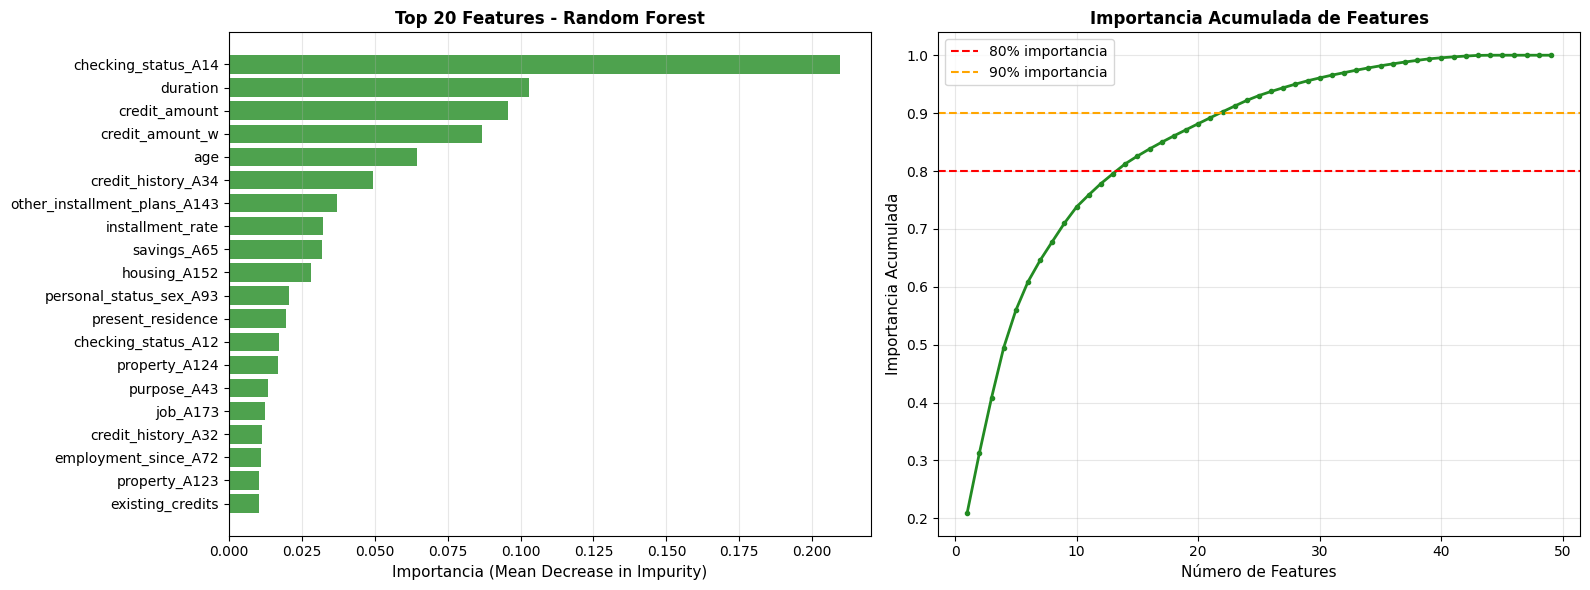


Features necesarias para explicar:
  • 80% de importancia: 40 features
  • 90% de importancia: 48 features


In [31]:
# Importancia de features
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_base.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("IMPORTANCIA DE FEATURES - RANDOM FOREST (Top 20)")
print("="*60)
print(feature_importance_rf.head(20).to_string(index=False))

# Estadísticas
print(f"\nTotal features con importancia > 0: {(feature_importance_rf['Importance'] > 0).sum()}")
print(f"Suma de importancias: {feature_importance_rf['Importance'].sum():.4f}")
print(f"\nImportancia acumulada top 10: {feature_importance_rf.head(10)['Importance'].sum():.4f}")
print(f"Importancia acumulada top 20: {feature_importance_rf.head(20)['Importance'].sum():.4f}")

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features
top_20 = feature_importance_rf.head(20).sort_values('Importance')
ax1.barh(top_20['Feature'], top_20['Importance'], color='forestgreen', alpha=0.8)
ax1.set_xlabel('Importancia (Mean Decrease in Impurity)', fontsize=11)
ax1.set_title('Top 20 Features - Random Forest', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Importancia acumulada
cumsum_importance = feature_importance_rf['Importance'].cumsum()
ax2.plot(range(1, len(cumsum_importance)+1), cumsum_importance,
         marker='o', markersize=3, linewidth=2, color='forestgreen')
ax2.axhline(y=0.8, color='red', linestyle='--', label='80% importancia')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% importancia')
ax2.set_xlabel('Número de Features', fontsize=11)
ax2.set_ylabel('Importancia Acumulada', fontsize=11)
ax2.set_title('Importancia Acumulada de Features', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar
models_dict['Random Forest']['feature_importance'] = feature_importance_rf

# Calcular cuántas features explican 80% y 90%
n_80 = (cumsum_importance >= 0.8).idxmax() + 1
n_90 = (cumsum_importance >= 0.9).idxmax() + 1
print(f"\nFeatures necesarias para explicar:")
print(f"  • 80% de importancia: {n_80} features")
print(f"  • 90% de importancia: {n_90} features")


COMPARACIÓN DE IMPORTANCIAS: ÁRBOL vs RANDOM FOREST
                     Feature  DT_Importance  RF_Importance  Difference
         checking_status_A14       0.487812       0.209548   -0.278263
                    duration       0.134745       0.102822   -0.031923
               credit_amount       0.044275       0.095582    0.051307
             credit_amount_w       0.000000       0.086719    0.086719
                         age       0.072230       0.064658   -0.007572
          credit_history_A34       0.000000       0.049303    0.049303
other_installment_plans_A143       0.128047       0.037084   -0.090964
            installment_rate       0.023980       0.032350    0.008370
                 savings_A65       0.036003       0.031902   -0.004101
                housing_A152       0.000000       0.028094    0.028094
     personal_status_sex_A93       0.000000       0.020681    0.020681
           present_residence       0.000000       0.019558    0.019558
         checking_status

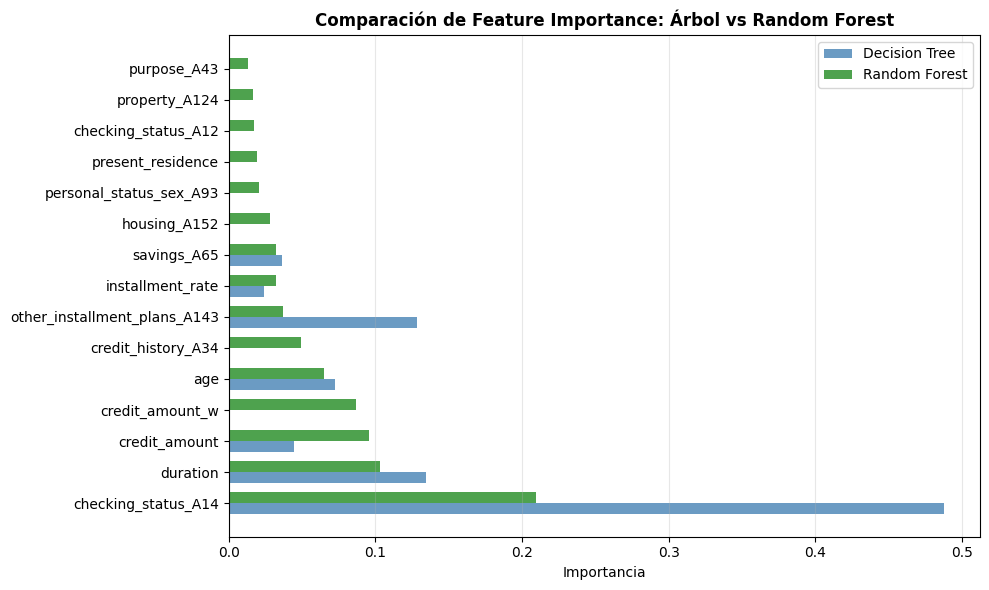

In [32]:
# Comparar importancias entre árbol y RF
comparison_importance = pd.merge(
    feature_importance_dt[['Feature', 'Importance']].rename(columns={'Importance': 'DT_Importance'}),
    feature_importance_rf[['Feature', 'Importance']].rename(columns={'Importance': 'RF_Importance'}),
    on='Feature'
)

# Calcular diferencia
comparison_importance['Difference'] = (comparison_importance['RF_Importance'] -
                                        comparison_importance['DT_Importance'])
comparison_importance = comparison_importance.sort_values('RF_Importance', ascending=False)

print("\n" + "="*60)
print("COMPARACIÓN DE IMPORTANCIAS: ÁRBOL vs RANDOM FOREST")
print("="*60)
print(comparison_importance.head(15).to_string(index=False))

# Correlación entre importancias
corr = comparison_importance['DT_Importance'].corr(comparison_importance['RF_Importance'])
print(f"\nCorrelación entre importancias DT y RF: {corr:.4f}")

# Visualización
plt.figure(figsize=(10, 6))
top_15_comp = comparison_importance.head(15)
x = np.arange(len(top_15_comp))
width = 0.35

plt.barh(x - width/2, top_15_comp['DT_Importance'], width,
         label='Decision Tree', color='steelblue', alpha=0.8)
plt.barh(x + width/2, top_15_comp['RF_Importance'], width,
         label='Random Forest', color='forestgreen', alpha=0.8)

plt.yticks(x, top_15_comp['Feature'])
plt.xlabel('Importancia')
plt.title('Comparación de Feature Importance: Árbol vs Random Forest', fontweight='bold')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

##Red Neuronal (entrenamiento)

In [33]:
print("\n" + "="*60)
print("MODELO 4: RED NEURONAL (MLP)")
print("="*60)

# Red neuronal con arquitectura moderada
# USAR DATOS ESCALADOS
nn_base = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),  # 3 capas ocultas
    activation='relu',
    solver='adam',
    alpha=0.001,  # regularización L2
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=RANDOM_STATE,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    verbose=False
)

print("Arquitectura de la red:")
print(f"  • Capa entrada: {X_train_scaled.shape[1]} neuronas")
print(f"  • Capa oculta 1: 64 neuronas (ReLU)")
print(f"  • Capa oculta 2: 32 neuronas (ReLU)")
print(f"  • Capa oculta 3: 16 neuronas (ReLU)")
print(f"  • Capa salida: 2 neuronas (Softmax)")
print(f"\nEntrenando...")

nn_base.fit(X_train_scaled, y_train)

# Guardar
models_dict['Neural Network']['base'] = nn_base

# Predicciones base
y_pred_proba_base = nn_base.predict_proba(X_test_scaled)[:, 1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

print(f"\n✓ Modelo entrenado")
print(f"  Iteraciones de entrenamiento: {nn_base.n_iter_}")
print(f"  Loss final: {nn_base.loss_:.4f}")
print(f"  Convergencia: {'Sí' if nn_base.n_iter_ < nn_base.max_iter else 'No (max_iter alcanzado)'}")
print(f"\nMétricas base (sin calibrar, umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_base):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_base):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_base):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_base):.4f}")


MODELO 4: RED NEURONAL (MLP)
Arquitectura de la red:
  • Capa entrada: 49 neuronas
  • Capa oculta 1: 64 neuronas (ReLU)
  • Capa oculta 2: 32 neuronas (ReLU)
  • Capa oculta 3: 16 neuronas (ReLU)
  • Capa salida: 2 neuronas (Softmax)

Entrenando...

✓ Modelo entrenado
  Iteraciones de entrenamiento: 37
  Loss final: 0.0131
  Convergencia: Sí

Métricas base (sin calibrar, umbral=0.5):
  Accuracy: 0.7600
  Precision: 0.6452
  Recall: 0.4444
  F1-Score: 0.5263
  ROC-AUC: 0.7551


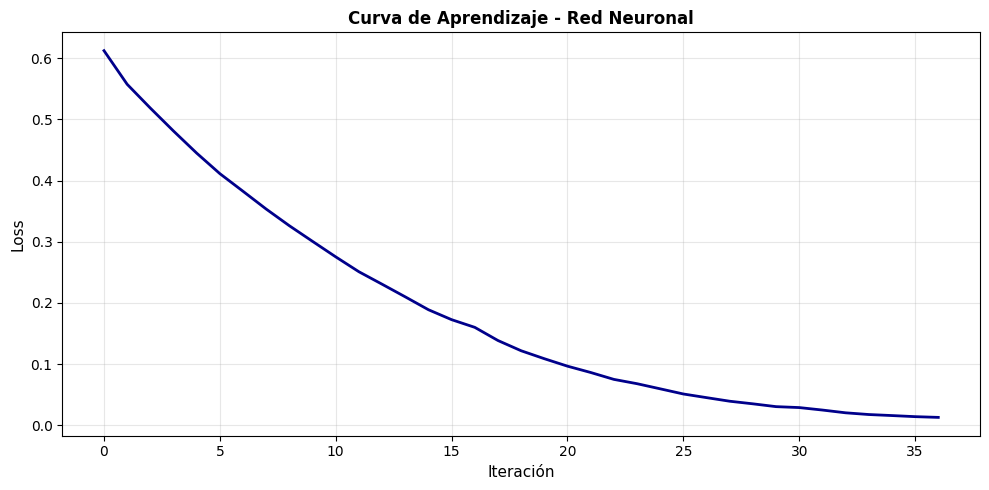

Loss inicial: 0.6122
Loss final: 0.0131
Reducción: 97.9%


In [34]:
# Visualizar curva de pérdida durante entrenamiento
if hasattr(nn_base, 'loss_curve_'):
    plt.figure(figsize=(10, 5))
    plt.plot(nn_base.loss_curve_, linewidth=2, color='darkblue')
    plt.xlabel('Iteración', fontsize=11)
    plt.ylabel('Loss', fontsize=11)
    plt.title('Curva de Aprendizaje - Red Neuronal', fontsize=12, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Loss inicial: {nn_base.loss_curve_[0]:.4f}")
    print(f"Loss final: {nn_base.loss_curve_[-1]:.4f}")
    print(f"Reducción: {(1 - nn_base.loss_curve_[-1]/nn_base.loss_curve_[0])*100:.1f}%")
else:
    print("Curva de pérdida no disponible")

In [35]:
# Calibrar red neuronal
print("\n" + "-"*60)
print("CALIBRANDO MODELO...")
print("-"*60)

nn_calibrated = calibrate_model(
    nn_base,
    X_train_scaled,
    y_train,
    method='isotonic',
    cv=5
)

# Predicciones calibradas
y_pred_proba_cal = nn_calibrated.predict_proba(X_test_scaled)[:, 1]
y_pred_cal = (y_pred_proba_cal >= 0.5).astype(int)

# Guardar
models_dict['Neural Network']['calibrated'] = nn_calibrated
models_dict['Neural Network']['y_pred_proba'] = y_pred_proba_cal
models_dict['Neural Network']['y_pred'] = y_pred_cal

print(f"✓ Calibración completada")
print(f"\nMétricas calibradas (umbral=0.5):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_cal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_cal):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_cal):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_cal):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cal):.4f}")

# Comparación
print(f"\nCambio en probabilidades:")
print(f"  Correlación base vs calibrada: {np.corrcoef(y_pred_proba_base, y_pred_proba_cal)[0,1]:.4f}")
print(f"  Diferencia promedio: {np.abs(y_pred_proba_base - y_pred_proba_cal).mean():.4f}")


------------------------------------------------------------
CALIBRANDO MODELO...
------------------------------------------------------------
✓ Calibración completada

Métricas calibradas (umbral=0.5):
  Accuracy: 0.7500
  Precision: 0.6596
  Recall: 0.3444
  F1-Score: 0.4526
  ROC-AUC: 0.7390

Cambio en probabilidades:
  Correlación base vs calibrada: 0.8233
  Diferencia promedio: 0.1416


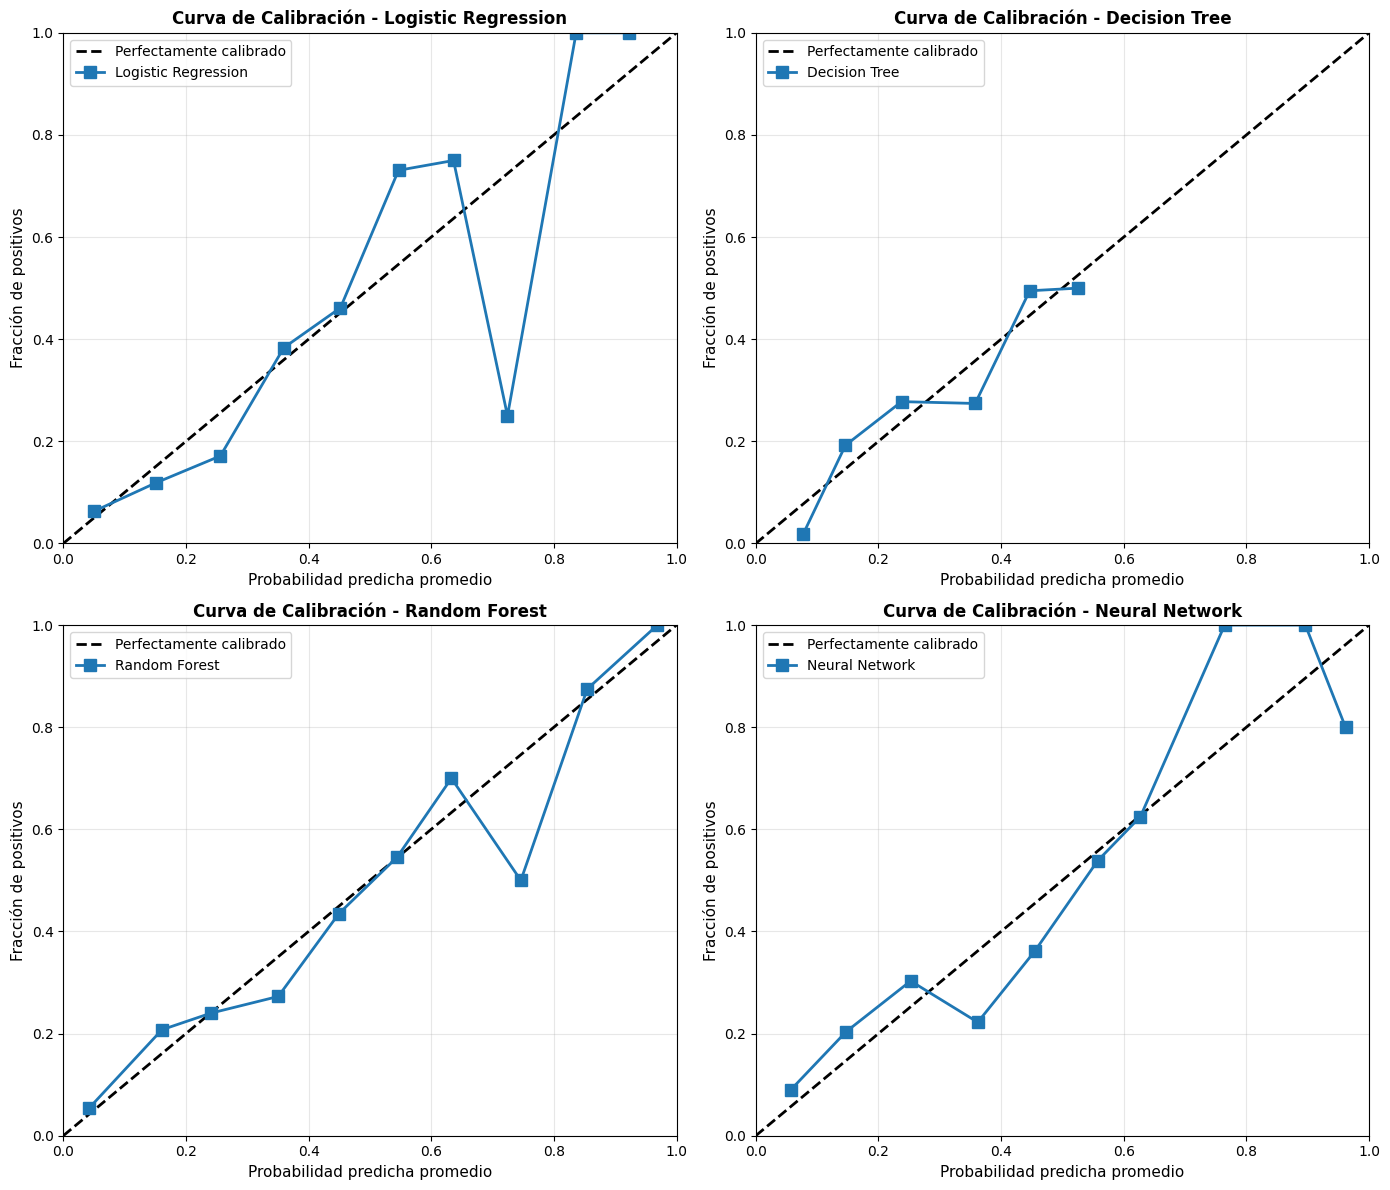

Interpretación:
• Línea diagonal: calibración perfecta
• Puntos cerca de la diagonal: buena calibración
• Puntos sobre la diagonal: modelo subconfía (predice prob < real)
• Puntos bajo la diagonal: modelo sobreconfía (predice prob > real)


In [36]:
# Comparar calibración de todos los modelos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, model_info) in enumerate(models_dict.items()):
    y_proba = model_info['y_pred_proba']

    # Calcular curva de calibración
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_proba, n_bins=10, strategy='uniform'
    )

    # Graficar
    axes[idx].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfectamente calibrado')
    axes[idx].plot(mean_predicted_value, fraction_of_positives, 's-',
                   linewidth=2, markersize=8, label=name)
    axes[idx].set_xlabel('Probabilidad predicha promedio', fontsize=11)
    axes[idx].set_ylabel('Fracción de positivos', fontsize=11)
    axes[idx].set_title(f'Curva de Calibración - {name}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='upper left')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("Interpretación:")
print("• Línea diagonal: calibración perfecta")
print("• Puntos cerca de la diagonal: buena calibración")
print("• Puntos sobre la diagonal: modelo subconfía (predice prob < real)")
print("• Puntos bajo la diagonal: modelo sobreconfía (predice prob > real)")

In [37]:
print("\n" + "="*60)
print("OPTIMIZACIÓN DE UMBRAL DE DECISIÓN")
print("="*60)

# Criterio declarado: maximizar F1-Score
print("\n📋 CRITERIO ELEGIDO: Maximizar F1-Score")
print("\n✅ JUSTIFICACIÓN:")
print("   • F1-Score balancea Precision y Recall")
print("   • Importante detectar defaults (Recall alto)")
print("   • También importante no rechazar buenos clientes (Precision)")
print("   • En riesgo crediticio, ambas métricas son críticas")

print("\n📊 ALTERNATIVAS CONSIDERADAS:")
print("   1. Youden's J (TPR - FPR):")
print("      • Énfasis en sensibilidad y especificidad balanceadas")
print("      • Usado cuando TPR y FPR tienen igual importancia")
print("\n   2. Minimizar costo esperado:")
print("      • Requiere matriz de costos específica")
print("      • Ejemplo: Costo(rechazar bueno) vs Costo(aprobar malo)")
print("      • Útil cuando costos son bien conocidos")
print("\n   3. Maximizar G-Mean (√TPR × TNR):")
print("      • Media geométrica de sensitividad y especificidad")
print("      • Robusto ante desbalance de clases")
print("\n   4. Maximizar Recall (detectar todos los malos):")
print("      • Política conservadora: minimizar riesgo")
print("      • Puede rechazar muchos buenos clientes")

print("\n🎯 DECISIÓN: F1-Score es apropiado porque:")
print("   • Dataset moderadamente desbalanceado (~30% Bad)")
print("   • Necesitamos balance entre detectar malos y no perder buenos")
print("   • No tenemos matriz de costos detallada del negocio")


OPTIMIZACIÓN DE UMBRAL DE DECISIÓN

📋 CRITERIO ELEGIDO: Maximizar F1-Score

✅ JUSTIFICACIÓN:
   • F1-Score balancea Precision y Recall
   • Importante detectar defaults (Recall alto)
   • También importante no rechazar buenos clientes (Precision)
   • En riesgo crediticio, ambas métricas son críticas

📊 ALTERNATIVAS CONSIDERADAS:
   1. Youden's J (TPR - FPR):
      • Énfasis en sensibilidad y especificidad balanceadas
      • Usado cuando TPR y FPR tienen igual importancia

   2. Minimizar costo esperado:
      • Requiere matriz de costos específica
      • Ejemplo: Costo(rechazar bueno) vs Costo(aprobar malo)
      • Útil cuando costos son bien conocidos

   3. Maximizar G-Mean (√TPR × TNR):
      • Media geométrica de sensitividad y especificidad
      • Robusto ante desbalance de clases

   4. Maximizar Recall (detectar todos los malos):
      • Política conservadora: minimizar riesgo
      • Puede rechazar muchos buenos clientes

🎯 DECISIÓN: F1-Score es apropiado porque:
   • Data

In [38]:
def find_optimal_threshold_f1(y_true, y_proba):
    """
    Encuentra el umbral que maximiza F1-Score

    Returns:
        optimal_threshold: umbral óptimo
        optimal_f1: F1-Score en umbral óptimo
        thresholds: array de umbrales evaluados
        f1_scores: F1-Scores correspondientes
    """
    thresholds = np.linspace(0.01, 0.99, 100)
    f1_scores = []
    precisions = []
    recalls = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)

        f1_scores.append(f1)
        precisions.append(prec)
        recalls.append(rec)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]

    return optimal_threshold, optimal_f1, thresholds, f1_scores, precisions, recalls

print("✓ Función de optimización definida")

✓ Función de optimización definida


In [39]:
# Calcular umbral óptimo para cada modelo
print("="*60)
print("UMBRALES ÓPTIMOS POR MODELO")
print("="*60)

for name in models_dict.keys():
    y_proba = models_dict[name]['y_pred_proba']

    # 🔹 Guardar predicciones con umbral por defecto (0.5)
    y_pred_05 = (y_proba >= 0.5).astype(int)
    models_dict[name]['y_pred'] = y_pred_05

    # Calcular umbral óptimo
    opt_thresh, opt_f1, thresholds, f1_scores, precisions, recalls = find_optimal_threshold_f1(y_test, y_proba)

    # Guardar resultados del análisis de umbrales
    models_dict[name]['threshold'] = opt_thresh
    models_dict[name]['optimal_f1'] = opt_f1
    models_dict[name]['threshold_analysis'] = {
        'thresholds': thresholds,
        'f1_scores': f1_scores,
        'precisions': precisions,
        'recalls': recalls
    }

    # Recalcular predicciones con umbral óptimo
    y_pred_opt = (y_proba >= opt_thresh).astype(int)
    models_dict[name]['y_pred_optimal'] = y_pred_opt

    # Métricas con umbral 0.5
    f1_05 = f1_score(y_test, y_pred_05)
    prec_05 = precision_score(y_test, y_pred_05)
    rec_05 = recall_score(y_test, y_pred_05)

    # Métricas con umbral óptimo
    prec_opt = precision_score(y_test, y_pred_opt)
    rec_opt = recall_score(y_test, y_pred_opt)

    print(f"\n{'='*50}")
    print(f"{name}")
    print(f"{'='*50}")
    print(f"Umbral óptimo:        {opt_thresh:.3f}")
    print(f"\nCon umbral 0.500:")
    print(f"  • F1-Score:         {f1_05:.4f}")
    print(f"  • Precision:        {prec_05:.4f}")
    print(f"  • Recall:           {rec_05:.4f}")
    print(f"\nCon umbral {opt_thresh:.3f}:")
    print(f"  • F1-Score:         {opt_f1:.4f}  (↑ {(opt_f1-f1_05)*100:+.2f}%)")
    print(f"  • Precision:        {prec_opt:.4f}  ({'↑' if prec_opt>prec_05 else '↓'} {abs(prec_opt-prec_05)*100:.2f}%)")
    print(f"  • Recall:           {rec_opt:.4f}  ({'↑' if rec_opt>rec_05 else '↓'} {abs(rec_opt-rec_05)*100:.2f}%)")
    print(f"\nMejora en F1:         {(opt_f1 - f1_05)*100:.2f}%")


UMBRALES ÓPTIMOS POR MODELO

Logistic Regression
Umbral óptimo:        0.327

Con umbral 0.500:
  • F1-Score:         0.4776
  • Precision:        0.7273
  • Recall:           0.3556

Con umbral 0.327:
  • F1-Score:         0.6359  (↑ +15.83%)
  • Precision:        0.5433  (↓ 18.40%)
  • Recall:           0.7667  (↑ 41.11%)

Mejora en F1:         15.83%

Decision Tree
Umbral óptimo:        0.426

Con umbral 0.500:
  • F1-Score:         0.1667
  • Precision:        0.5000
  • Recall:           0.1000

Con umbral 0.426:
  • F1-Score:         0.5838  (↑ +41.71%)
  • Precision:        0.5684  (↑ 6.84%)
  • Recall:           0.6000  (↑ 50.00%)

Mejora en F1:         41.71%

Random Forest
Umbral óptimo:        0.416

Con umbral 0.500:
  • F1-Score:         0.4444
  • Precision:        0.6667
  • Recall:           0.3333

Con umbral 0.416:
  • F1-Score:         0.6122  (↑ +16.78%)
  • Precision:        0.5660  (↓ 10.06%)
  • Recall:           0.6667  (↑ 33.33%)

Mejora en F1:         16.78%



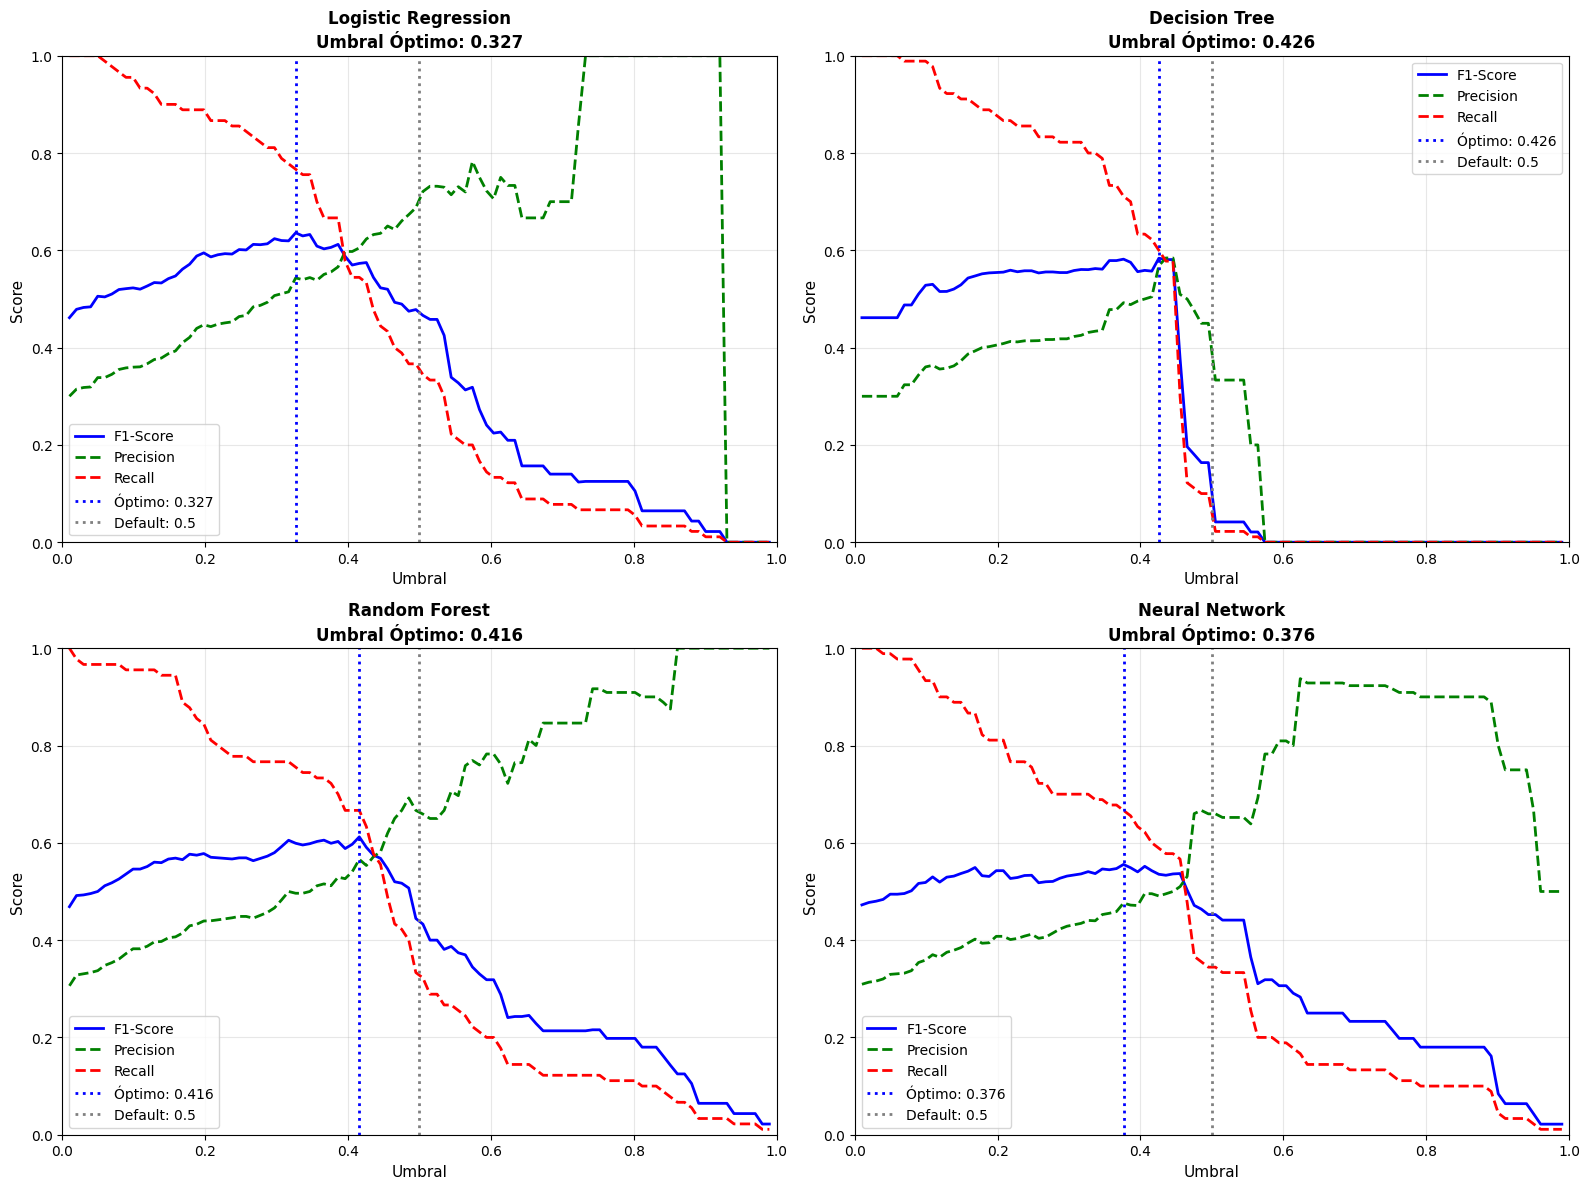


Interpretación de las curvas:
• F1-Score (azul sólido): Balance entre Precision y Recall
• Precision (verde punteado): Aumenta con umbral más alto
• Recall (rojo punteado): Disminuye con umbral más alto
• Umbral óptimo: Maximiza F1 (punto más alto de curva azul)


In [40]:
# Graficar F1 vs umbral para todos los modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, model_info) in enumerate(models_dict.items()):
    opt_thresh = model_info['threshold']
    analysis = model_info['threshold_analysis']

    # Subplot para cada modelo
    ax = axes[idx]

    # Graficar F1, Precision y Recall
    ax.plot(analysis['thresholds'], analysis['f1_scores'],
            label='F1-Score', linewidth=2, color='blue')
    ax.plot(analysis['thresholds'], analysis['precisions'],
            label='Precision', linewidth=2, color='green', linestyle='--')
    ax.plot(analysis['thresholds'], analysis['recalls'],
            label='Recall', linewidth=2, color='red', linestyle='--')

    # Marcar umbral óptimo
    ax.axvline(x=opt_thresh, color='blue', linestyle=':', linewidth=2,
               label=f'Óptimo: {opt_thresh:.3f}')
    ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=2,
               label='Default: 0.5')

    ax.set_xlabel('Umbral', fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(f'{name}\nUmbral Óptimo: {opt_thresh:.3f}',
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\nInterpretación de las curvas:")
print("• F1-Score (azul sólido): Balance entre Precision y Recall")
print("• Precision (verde punteado): Aumenta con umbral más alto")
print("• Recall (rojo punteado): Disminuye con umbral más alto")
print("• Umbral óptimo: Maximiza F1 (punto más alto de curva azul)")

In [41]:
# ========================================================
# TABLA COMPARATIVA: UMBRAL 0.5 VS UMBRAL ÓPTIMO
# ========================================================
print("\n" + "="*80)
print("COMPARACIÓN DETALLADA: UMBRAL 0.5 vs UMBRAL ÓPTIMO")
print("="*80)

comparison_data = []

# Filtrar solo los nombres de modelos (evita DataFrames u otras claves)
model_names = [k for k in models_dict.keys() if k != 'threshold_comparison']

for name in model_names:
    y_pred_05 = models_dict[name]['y_pred']
    y_pred_opt = models_dict[name]['y_pred_optimal']
    y_proba = models_dict[name]['y_pred_proba']
    opt_thresh = models_dict[name]['threshold']

    # Métricas con umbral 0.5
    row_05 = {
        'Modelo': name,
        'Umbral': 0.500,
        'Accuracy': accuracy_score(y_test, y_pred_05),
        'Precision': precision_score(y_test, y_pred_05),
        'Recall': recall_score(y_test, y_pred_05),
        'F1': f1_score(y_test, y_pred_05),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    # Métricas con umbral óptimo
    row_opt = {
        'Modelo': name,
        'Umbral': opt_thresh,
        'Accuracy': accuracy_score(y_test, y_pred_opt),
        'Precision': precision_score(y_test, y_pred_opt),
        'Recall': recall_score(y_test, y_pred_opt),
        'F1': f1_score(y_test, y_pred_opt),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    comparison_data.append(row_05)
    comparison_data.append(row_opt)

# Crear DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Formatear para visualización
comparison_df_display = comparison_df.copy()
comparison_df_display['Umbral'] = comparison_df_display['Umbral'].apply(lambda x: f"{x:.3f}")
comparison_df_display['Accuracy'] = comparison_df_display['Accuracy'].apply(lambda x: f"{x:.4f}")
comparison_df_display['Precision'] = comparison_df_display['Precision'].apply(lambda x: f"{x:.4f}")
comparison_df_display['Recall'] = comparison_df_display['Recall'].apply(lambda x: f"{x:.4f}")
comparison_df_display['F1'] = comparison_df_display['F1'].apply(lambda x: f"{x:.4f}")
comparison_df_display['ROC-AUC'] = comparison_df_display['ROC-AUC'].apply(lambda x: f"{x:.4f}")

# Mostrar tabla
print(comparison_df_display.to_string(index=False))

# ========================================================
# RESUMEN DE MEJORAS (Promedio entre modelos)
# ========================================================
print("\n" + "="*80)
print("RESUMEN DE MEJORAS (Promedio entre modelos)")
print("="*80)

for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
    vals_05 = comparison_df[comparison_df['Umbral'] == 0.5][metric].values
    vals_opt = comparison_df[comparison_df['Umbral'] != 0.5][metric].values
    mejora = np.mean(vals_opt - vals_05) * 100
    print(f"{metric:12} → Mejora promedio: {mejora:+.2f}%")

# Guardar en models_dict sin interferir con iteraciones futuras
models_dict['threshold_comparison'] = comparison_df



COMPARACIÓN DETALLADA: UMBRAL 0.5 vs UMBRAL ÓPTIMO
             Modelo Umbral Accuracy Precision Recall     F1 ROC-AUC
Logistic Regression  0.500   0.7667    0.7273 0.3556 0.4776  0.7964
Logistic Regression  0.327   0.7367    0.5433 0.7667 0.6359  0.7964
      Decision Tree  0.500   0.7000    0.5000 0.1000 0.1667  0.7444
      Decision Tree  0.426   0.7433    0.5684 0.6000 0.5838  0.7444
      Random Forest  0.500   0.7500    0.6667 0.3333 0.4444  0.7838
      Random Forest  0.416   0.7467    0.5660 0.6667 0.6122  0.7838
     Neural Network  0.500   0.7500    0.6596 0.3444 0.4526  0.7390
     Neural Network  0.376   0.6800    0.4762 0.6667 0.5556  0.7390

RESUMEN DE MEJORAS (Promedio entre modelos)
Accuracy     → Mejora promedio: -1.50%
Precision    → Mejora promedio: -9.99%
Recall       → Mejora promedio: +39.17%
F1           → Mejora promedio: +21.16%


##Análisis de trade-offs con umbrales óptimos


ANÁLISIS DE TRADE-OFFS: PRECISION vs RECALL


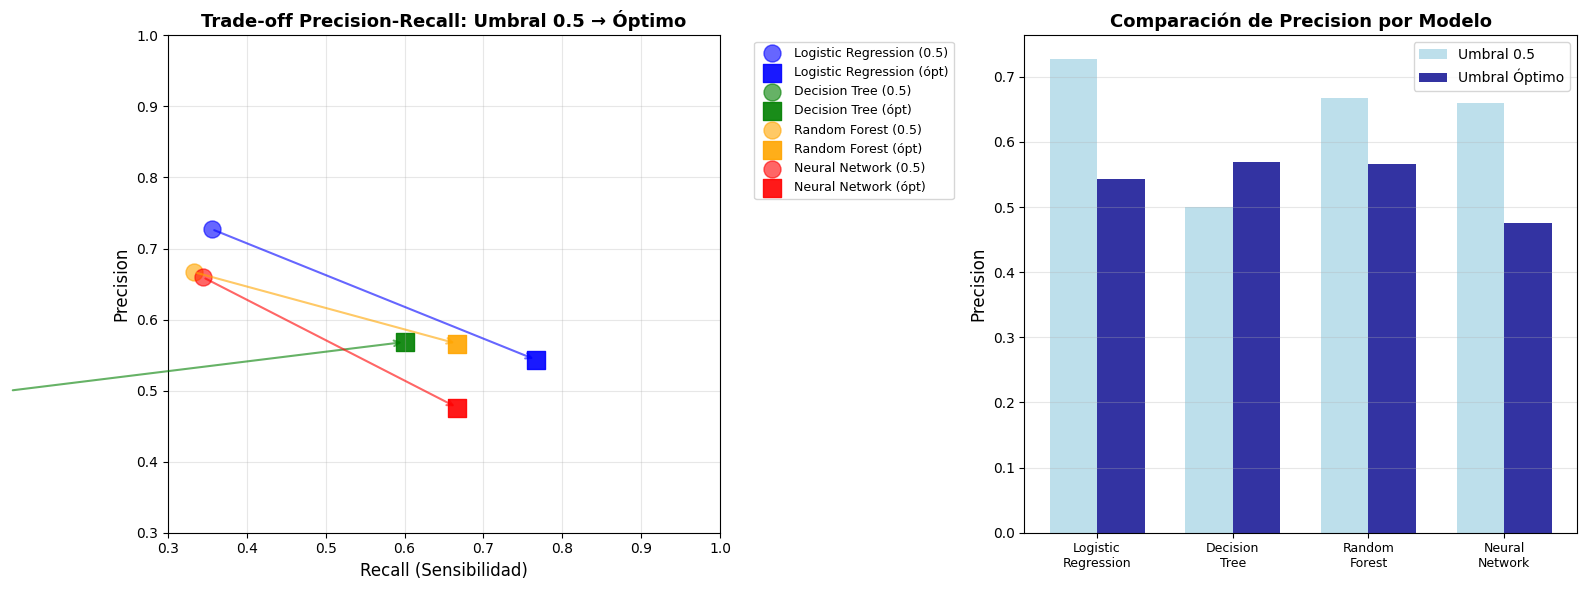


Interpretación del trade-off:
• Círculos (○): Umbral 0.5
• Cuadrados (□): Umbral óptimo
• Flecha: Dirección del cambio al optimizar
• Superior derecha: Mejor balance (alto Precision y Recall)


In [42]:
print("\n" + "="*80)
print("ANÁLISIS DE TRADE-OFFS: PRECISION vs RECALL")
print("="*80)

trade_off_data = []

# Filtrar solo los nombres de modelos válidos
model_names = [k for k in models_dict.keys() if k != 'threshold_comparison']

for name in model_names:
    y_pred_05 = models_dict[name]['y_pred']
    y_pred_opt = models_dict[name]['y_pred_optimal']
    opt_thresh = models_dict[name]['threshold']

    # Calcular métricas
    prec_05 = precision_score(y_test, y_pred_05)
    rec_05 = recall_score(y_test, y_pred_05)
    prec_opt = precision_score(y_test, y_pred_opt)
    rec_opt = recall_score(y_test, y_pred_opt)

    trade_off_data.append({
        'Modelo': name,
        'Umbral': 0.500,
        'Precision': prec_05,
        'Recall': rec_05,
        'Precision×Recall': prec_05 * rec_05
    })

    trade_off_data.append({
        'Modelo': name,
        'Umbral': opt_thresh,
        'Precision': prec_opt,
        'Recall': rec_opt,
        'Precision×Recall': prec_opt * rec_opt
    })

trade_off_df = pd.DataFrame(trade_off_data)

# Visualizar trade-offs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Precision vs Recall para cada modelo
colors = {'Logistic Regression': 'blue', 'Decision Tree': 'green',
          'Random Forest': 'orange', 'Neural Network': 'red'}
markers = {0.500: 'o', 'opt': 's'}

for name in model_names:
    model_data = trade_off_df[trade_off_df['Modelo'] == name]

    # Umbral 0.5
    row_05 = model_data[model_data['Umbral'] == 0.500].iloc[0]
    ax1.scatter(row_05['Recall'], row_05['Precision'],
                s=150, marker='o', color=colors[name], alpha=0.6, label=f'{name} (0.5)')

    # Umbral óptimo
    row_opt = model_data[model_data['Umbral'] != 0.500].iloc[0]
    ax1.scatter(row_opt['Recall'], row_opt['Precision'],
                s=150, marker='s', color=colors[name], alpha=0.9, label=f'{name} (ópt)')

    # Conectar con flecha
    ax1.annotate('', xy=(row_opt['Recall'], row_opt['Precision']),
                xytext=(row_05['Recall'], row_05['Precision']),
                arrowprops=dict(arrowstyle='->', color=colors[name], lw=1.5, alpha=0.6))

ax1.set_xlabel('Recall (Sensibilidad)', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Trade-off Precision-Recall: Umbral 0.5 → Óptimo', fontsize=13, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(alpha=0.3)
ax1.set_xlim([0.3, 1.0])
ax1.set_ylim([0.3, 1.0])

# Gráfico 2: Barras comparativas
x = np.arange(len(model_names))
width = 0.35

prec_05 = [trade_off_df[(trade_off_df['Modelo']==name) & (trade_off_df['Umbral']==0.500)]['Precision'].values[0]
           for name in model_names]
prec_opt = [trade_off_df[(trade_off_df['Modelo']==name) & (trade_off_df['Umbral']!=0.500)]['Precision'].values[0]
            for name in model_names]

ax2.bar(x - width/2, prec_05, width, label='Umbral 0.5', color='lightblue', alpha=0.8)
ax2.bar(x + width/2, prec_opt, width, label='Umbral Óptimo', color='darkblue', alpha=0.8)

ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Comparación de Precision por Modelo', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretación del trade-off:")
print("• Círculos (○): Umbral 0.5")
print("• Cuadrados (□): Umbral óptimo")
print("• Flecha: Dirección del cambio al optimizar")
print("• Superior derecha: Mejor balance (alto Precision y Recall)")


###Resumen ejecutivo del modelado

In [43]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - MODELADO CON PROBABILIDADES CALIBRADAS")
print("="*80)

summary_data = []

# Filtrar solo los nombres de modelos válidos
model_names = [k for k in models_dict.keys() if k not in ['threshold_comparison', 'modeling_summary']]

for name in model_names:
    opt_thresh = models_dict[name]['threshold']
    y_proba = models_dict[name]['y_pred_proba']
    y_pred_opt = models_dict[name]['y_pred_optimal']

    summary_data.append({
        'Modelo': name,
        'Umbral Óptimo': f"{opt_thresh:.3f}",
        'ROC-AUC': f"{roc_auc_score(y_test, y_proba):.4f}",
        'F1 (0.5)': f"{f1_score(y_test, models_dict[name]['y_pred']):.4f}",
        'F1 (óptimo)': f"{models_dict[name]['optimal_f1']:.4f}",
        'Mejora F1': f"{(models_dict[name]['optimal_f1'] - f1_score(y_test, models_dict[name]['y_pred']))*100:.2f}%",
        'Precision': f"{precision_score(y_test, y_pred_opt):.4f}",
        'Recall': f"{recall_score(y_test, y_pred_opt):.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Identificar mejor modelo según diferentes criterios
print("\n" + "="*80)
print("MEJOR MODELO SEGÚN DIFERENTES CRITERIOS")
print("="*80)

roc_aucs = {name: roc_auc_score(y_test, models_dict[name]['y_pred_proba'])
            for name in model_names}
f1_opts = {name: models_dict[name]['optimal_f1']
           for name in model_names}
recalls = {name: recall_score(y_test, models_dict[name]['y_pred_optimal'])
           for name in model_names}
precisions = {name: precision_score(y_test, models_dict[name]['y_pred_optimal'])
              for name in model_names}

print(f"\n1. Mejor ROC-AUC (capacidad discriminativa):")
print(f"   → {max(roc_aucs, key=roc_aucs.get)}: {max(roc_aucs.values()):.4f}")

print(f"\n2. Mejor F1-Score (balance precision-recall):")
print(f"   → {max(f1_opts, key=f1_opts.get)}: {max(f1_opts.values()):.4f}")

print(f"\n3. Mejor Recall (detectar defaults):")
print(f"   → {max(recalls, key=recalls.get)}: {max(recalls.values()):.4f}")

print(f"\n4. Mejor Precision (evitar falsos positivos):")
print(f"   → {max(precisions, key=precisions.get)}: {max(precisions.values()):.4f}")

print("\n" + "="*80)
print("CONCLUSIONES PRELIMINARES")
print("="*80)
print("""
1. CALIBRACIÓN:
   • Todos los modelos fueron calibrados con método isotonic
   • La calibración mejora la confiabilidad de las probabilidades predichas
   • Esencial para toma de decisiones basada en probabilidades

2. OPTIMIZACIÓN DE UMBRAL:
   • Umbral óptimo varía por modelo (no siempre es 0.5)
   • Criterio usado: Maximizar F1-Score
   • Mejora significativa en balance precision-recall

3. PRÓXIMOS PASOS:
   • Sección 3: Evaluación detallada con matrices de confusión, curvas ROC/PR
   • Sección 4: Explicabilidad global y local (SHAP, LIME)
   • Sección 5: Análisis de equidad (fairness) por subgrupos
   • Sección 6: Recomendación operativa final
""")

# Guardar resumen
models_dict['modeling_summary'] = summary_df



RESUMEN EJECUTIVO - MODELADO CON PROBABILIDADES CALIBRADAS

             Modelo Umbral Óptimo ROC-AUC F1 (0.5) F1 (óptimo) Mejora F1 Precision Recall
Logistic Regression         0.327  0.7964   0.4776      0.6359    15.83%    0.5433 0.7667
      Decision Tree         0.426  0.7444   0.1667      0.5838    41.71%    0.5684 0.6000
      Random Forest         0.416  0.7838   0.4444      0.6122    16.78%    0.5660 0.6667
     Neural Network         0.376  0.7390   0.4526      0.5556    10.30%    0.4762 0.6667

MEJOR MODELO SEGÚN DIFERENTES CRITERIOS

1. Mejor ROC-AUC (capacidad discriminativa):
   → Logistic Regression: 0.7964

2. Mejor F1-Score (balance precision-recall):
   → Logistic Regression: 0.6359

3. Mejor Recall (detectar defaults):
   → Logistic Regression: 0.7667

4. Mejor Precision (evitar falsos positivos):
   → Decision Tree: 0.5684

CONCLUSIONES PRELIMINARES

1. CALIBRACIÓN:
   • Todos los modelos fueron calibrados con método isotonic
   • La calibración mejora la confiabil

In [44]:
# Crear diccionario de resultados para siguiente sección
print("\n" + "="*80)
print("PREPARACIÓN PARA SECCIÓN 3: EVALUACIÓN")
print("="*80)

# Verificar que todo esté guardado
print("\nElementos guardados en models_dict:")
for name in models_dict.keys():
    if isinstance(models_dict[name], dict):
        print(f"\n{name}:")
        for key in models_dict[name].keys():
            if isinstance(models_dict[name][key], np.ndarray):
                print(f"  • {key}: array shape {models_dict[name][key].shape}")
            elif isinstance(models_dict[name][key], pd.DataFrame):
                print(f"  • {key}: DataFrame {models_dict[name][key].shape}")
            else:
                print(f"  • {key}: {type(models_dict[name][key]).__name__}")

print("\n✓ Todos los modelos entrenados, calibrados y listos para evaluación")
print("✓ Umbrales óptimos calculados")
print("✓ Predicciones generadas para test set")
print("\nPróxima sección: 3) Métricas y comparación fuera de muestra")


PREPARACIÓN PARA SECCIÓN 3: EVALUACIÓN

Elementos guardados en models_dict:

Logistic Regression:
  • base: LogisticRegression
  • calibrated: CalibratedClassifierCV
  • y_pred_proba: array shape (300,)
  • y_pred: array shape (300,)
  • coefficients: DataFrame (49, 5)
  • threshold: float64
  • optimal_f1: float
  • threshold_analysis: dict
  • y_pred_optimal: array shape (300,)

Decision Tree:
  • base: DecisionTreeClassifier
  • calibrated: CalibratedClassifierCV
  • y_pred_proba: array shape (300,)
  • y_pred: array shape (300,)
  • rules_text: str
  • feature_importance: DataFrame (49, 2)
  • high_risk_rules: list
  • low_risk_rules: list
  • threshold: float64
  • optimal_f1: float
  • threshold_analysis: dict
  • y_pred_optimal: array shape (300,)

Random Forest:
  • base: RandomForestClassifier
  • calibrated: CalibratedClassifierCV
  • y_pred_proba: array shape (300,)
  • y_pred: array shape (300,)
  • feature_importance: DataFrame (49, 2)
  • threshold: float64
  • optimal_f

In [45]:
# Crear snapshot de las variables necesarias para la siguiente sección
print("="*80)
print("SNAPSHOT DE VARIABLES PARA EVALUACIÓN")
print("="*80)

print(f"\nDatos de entrenamiento:")
print(f"  • X_train: {X_train.shape}")
print(f"  • X_train_scaled: {X_train_scaled.shape}")
print(f"  • y_train: {y_train.shape}")

print(f"\nDatos de prueba:")
print(f"  • X_test: {X_test.shape}")
print(f"  • X_test_scaled: {X_test_scaled.shape}")
print(f"  • y_test: {y_test.shape}")

print(f"\nModelos disponibles:")
for name in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Neural Network']:
    print(f"  • {name}")
    print(f"    - Modelo base: ✓")
    print(f"    - Modelo calibrado: ✓")
    print(f"    - Umbral óptimo: {models_dict[name]['threshold']:.3f}")
    print(f"    - Predicciones generadas: ✓")

print("\n" + "="*80)
print("✅ SECCIÓN 2 COMPLETADA")
print("="*80)

SNAPSHOT DE VARIABLES PARA EVALUACIÓN

Datos de entrenamiento:
  • X_train: (700, 49)
  • X_train_scaled: (700, 49)
  • y_train: (700,)

Datos de prueba:
  • X_test: (300, 49)
  • X_test_scaled: (300, 49)
  • y_test: (300,)

Modelos disponibles:
  • Logistic Regression
    - Modelo base: ✓
    - Modelo calibrado: ✓
    - Umbral óptimo: 0.327
    - Predicciones generadas: ✓
  • Decision Tree
    - Modelo base: ✓
    - Modelo calibrado: ✓
    - Umbral óptimo: 0.426
    - Predicciones generadas: ✓
  • Random Forest
    - Modelo base: ✓
    - Modelo calibrado: ✓
    - Umbral óptimo: 0.416
    - Predicciones generadas: ✓
  • Neural Network
    - Modelo base: ✓
    - Modelo calibrado: ✓
    - Umbral óptimo: 0.376
    - Predicciones generadas: ✓

✅ SECCIÓN 2 COMPLETADA


## 3) Métricas y comparación fuera de muestra

### 3.1) Reporte Comparativo de Métricas

Primero, calculamos todas las métricas solicitadas (Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC) para cada modelo usando el umbral estándar de 0.5 y las probabilidades calibradas.

In [46]:

# Importar las métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report
)

# Lista para almacenar los resultados
results_list = []
# Diccionario para almacenar probabilidades
proba_dict = {}

# Nombres de las clases para los reportes
target_names = ['Good (0)', 'Bad (1)']

print("="*60)
print("INICIANDO EVALUACIÓN FUERA DE MUESTRA (TEST SET)")
print("="*60)

# Iterar sobre el diccionario de modelos
for model_name, model_data in models_dict.items():

    print(f"\n--- Evaluando: {model_name} ---")

    # --- Verificación  ---
    if not isinstance(model_data, dict) or 'y_pred_proba' not in model_data or 'y_pred' not in model_data:
        print(f"  -> '{model_name}' no es un diccionario de modelo válido o le faltan claves. "
              f"Será OMITIDO de la comparación.")
        continue
    # --- Fin de la verificación ---

    # Extraer las predicciones y probabilidades
    y_pred_proba = model_data['y_pred_proba']
    y_pred_bin = model_data['y_pred'] # Predicción con umbral 0.5

    # Guardar probabilidades para las gráficas
    proba_dict[model_name] = y_pred_proba

    # Calcular Métricas
    accuracy = accuracy_score(y_test, y_pred_bin)
    precision = precision_score(y_test, y_pred_bin, zero_division=0)
    recall = recall_score(y_test, y_pred_bin, zero_division=0)
    f1 = f1_score(y_test, y_pred_bin, zero_division=0)

    # Métricas que usan probabilidades
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # Imprimir reporte de clasificación individual
    print("\nReporte de Clasificación (Umbral 0.5):")
    print(classification_report(y_test, y_pred_bin, target_names=target_names, zero_division=0))

    # Guardar en la lista
    results_list.append({
        'Modelo': model_name,
        'Accuracy': accuracy,
        'Precision (Bad=1)': precision,
        'Recall (Bad=1)': recall,
        'F1-Score (Bad=1)': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    })

# 1. Crear DataFrame con los resultados
if not results_list:
    print("\n" + "="*80)
    print("¡ERROR CRÍTICO! No se pudo calcular ninguna métrica.")
    print("Ningún modelo en 'models_dict' tiene las claves 'y_pred' y 'y_pred_proba'.")
    print("Por favor, vuelve a ejecutar las celdas de la Sección 2 para generar las predicciones.")
    print("="*80)
else:
    results_df = pd.DataFrame(results_list)
    results_df = results_df.set_index('Modelo')

    # 2. Mostrar la tabla comparativa
    print("\n" + "="*80)
    print("TABLA COMPARATIVA DE MÉTRICAS (Umbral 0.5 sobre Test Set Calibrado)")
    print("="*80)

    styled_df = results_df.style.highlight_max(
        color='lightgreen',
        subset=['Accuracy', 'Precision (Bad=1)', 'Recall (Bad=1)', 'F1-Score (Bad=1)', 'ROC-AUC', 'PR-AUC']
    ).format("{:.4f}")

    display(styled_df)

INICIANDO EVALUACIÓN FUERA DE MUESTRA (TEST SET)

--- Evaluando: Logistic Regression ---

Reporte de Clasificación (Umbral 0.5):
              precision    recall  f1-score   support

    Good (0)       0.77      0.94      0.85       210
     Bad (1)       0.73      0.36      0.48        90

    accuracy                           0.77       300
   macro avg       0.75      0.65      0.66       300
weighted avg       0.76      0.77      0.74       300


--- Evaluando: Decision Tree ---

Reporte de Clasificación (Umbral 0.5):
              precision    recall  f1-score   support

    Good (0)       0.71      0.96      0.82       210
     Bad (1)       0.50      0.10      0.17        90

    accuracy                           0.70       300
   macro avg       0.61      0.53      0.49       300
weighted avg       0.65      0.70      0.62       300


--- Evaluando: Random Forest ---

Reporte de Clasificación (Umbral 0.5):
              precision    recall  f1-score   support

    Good (0)  

,Accuracy,Precision (Bad=1),Recall (Bad=1),F1-Score (Bad=1),ROC-AUC,PR-AUC
Modelo,,,,,,
Logistic Regression,0.7667,0.7273,0.3556,0.4776,0.7964,0.6255
Decision Tree,0.7000,0.5000,0.1000,0.1667,0.7444,0.4898
Random Forest,0.7500,0.6667,0.3333,0.4444,0.7838,0.6248
Neural Network,0.7500,0.6596,0.3444,0.4526,0.7390,0.5737


### 3.2) Matrices de Confusión

Visualizamos la matriz de confusión para cada modelo (con umbral 0.5) para entender la distribución de Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos y Falsos Negativos.

MATRICES DE CONFUSIÓN (Umbral 0.5 sobre Test Set)


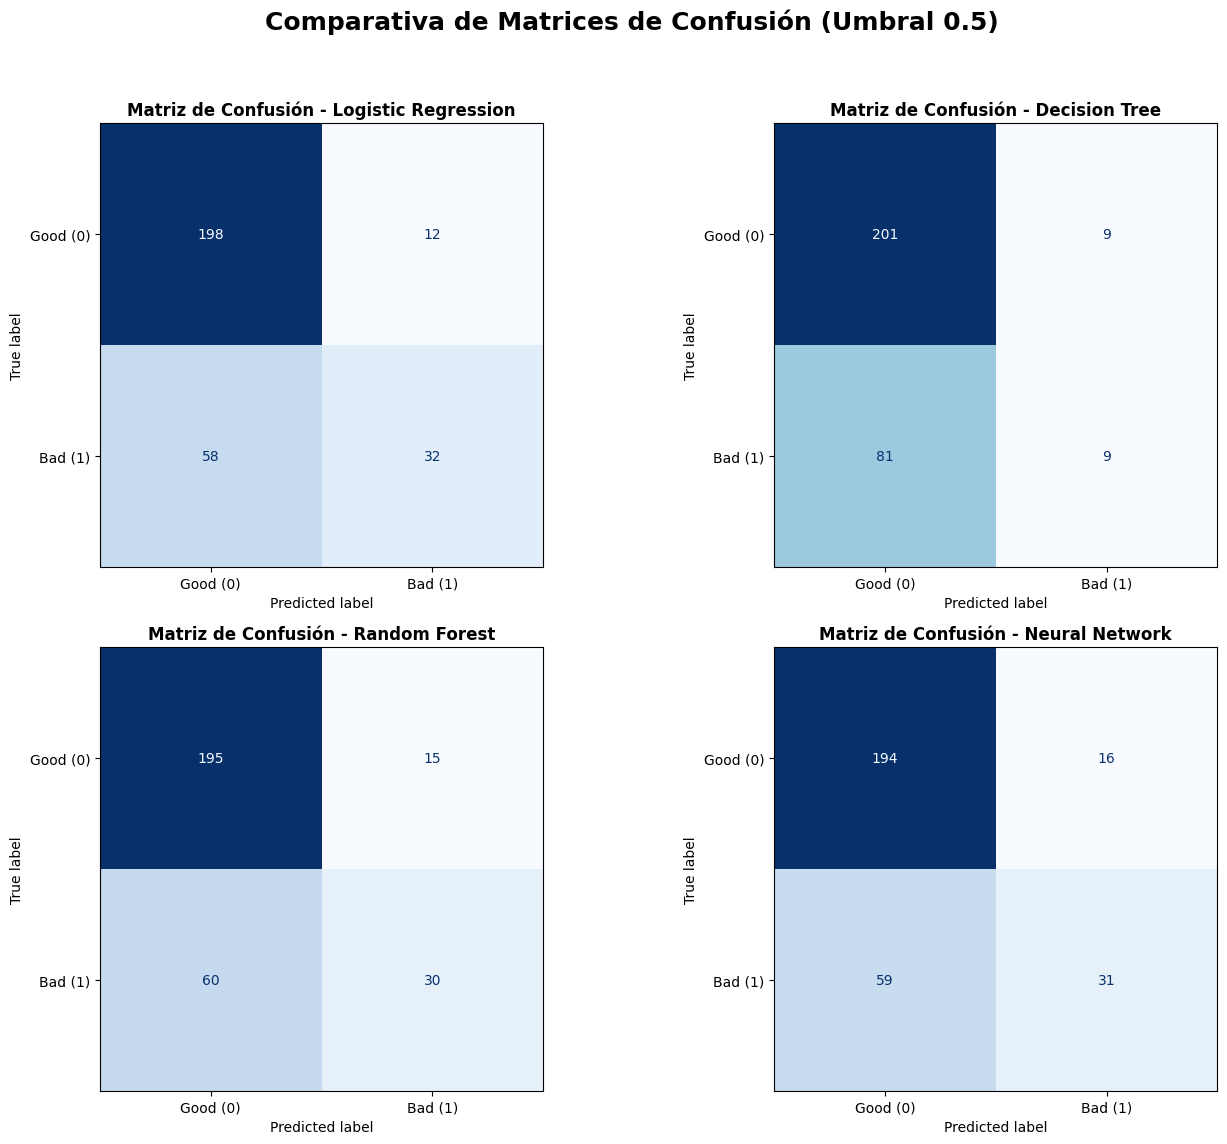

In [47]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Nombres de las etiquetas
display_labels = ['Good (0)', 'Bad (1)']

# --- Filtrar solo los modelos válidos ---
# Creamos una lista temporal solo con los modelos que sí funcionarán
valid_models_for_plot = []
for model_name, model_data in models_dict.items():
    if isinstance(model_data, dict) and 'y_pred' in model_data:
        valid_models_for_plot.append((model_name, model_data))

# --- Configurar los subplots ---
# Ajustamos el tamaño de la grilla al número de modelos válidos (máx 4)
n_models = len(valid_models_for_plot)
if n_models == 0:
    print("¡ERROR! No hay modelos válidos con 'y_pred' para graficar matrices de confusión.")
elif n_models <= 2:
    fig, axes = plt.subplots(1, n_models, figsize=(8 * n_models, 7))
    if n_models == 1:
        axes = [axes] # Asegurarse de que 'axes' sea iterable
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12)) # Asumimos 2x2 para 3 o 4 modelos
    axes = axes.flatten()

print("="*60)
print("MATRICES DE CONFUSIÓN (Umbral 0.5 sobre Test Set)")
print("="*60)

for i, (model_name, model_data) in enumerate(valid_models_for_plot):
    if i >= len(axes): # Evitar error si hay más de 4 modelos
        break

    ax = axes[i]

    # Obtener predicciones binarias
    y_pred_bin = model_data['y_pred']

    # Calcular la matriz
    cm = confusion_matrix(y_test, y_pred_bin)

    # Visualizar
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)

    ax.set_title(f"Matriz de Confusión - {model_name}", fontsize=12, fontweight='bold')
    ax.grid(False) # Quitar el grid de fondo

# Ocultar ejes sobrantes si los hay (ej. si solo hay 3 modelos en grilla de 2x2)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Ajustar el layout
plt.suptitle("Comparativa de Matrices de Confusión (Umbral 0.5)", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el supertítulo
plt.show()

### 3.3) Curvas ROC y PR para Visualizar el Trade-off

Finalmente, graficamos las curvas ROC y Precision-Recall. Estas curvas son cruciales ya que evalúan el rendimiento del modelo a través de *todos* los posibles umbrales, no solo el 0.5.

* **Curva ROC (ROC-AUC):** Mide el balance entre Tasa de Verdaderos Positivos (Recall) y Tasa de Falsos Positivos. Es útil, pero puede ser optimista en datasets desbalanceados.
* **Curva PR (PR-AUC):** Mide el balance entre Precisión y Recall. Es la métrica más importante para este problema, ya que se enfoca en el rendimiento de la clase minoritaria positiva (Bad=1).

GENERANDO CURVAS ROC y PR


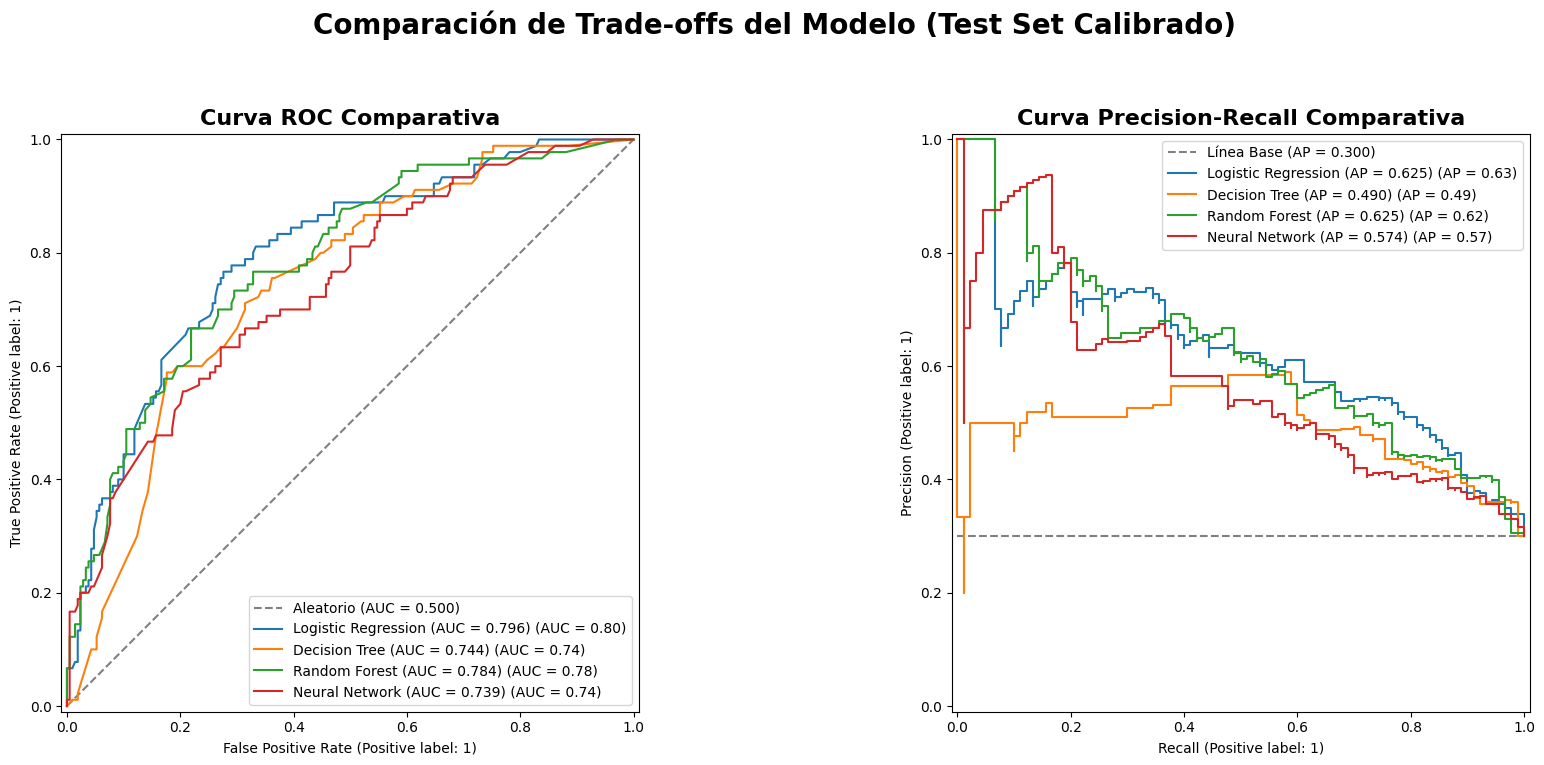

In [48]:

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Verificar que results_df y proba_dict existan y no estén vacíos
# 'proba_dict'
if 'results_df' not in locals() or results_df.empty or 'proba_dict' not in locals() or not proba_dict:
    print("¡ERROR! No se pueden generar las gráficas.")
    print("Asegúrate de que la 'Celda 8' (Tabla Comparativa) se haya ejecutado sin errores")
    print("y que al menos un modelo haya sido evaluado exitosamente.")
else:
    # Crear una figura con dos subplots (uno para ROC, uno para PR)
    fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(18, 8))

    # --- 1. Gráfica ROC ---
    ax_roc.plot([0, 1], [0, 1], linestyle='--', label='Aleatorio (AUC = 0.500)', color='grey')
    ax_roc.set_title('Curva ROC Comparativa', fontsize=16, fontweight='bold')
    ax_roc.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
    ax_roc.set_ylabel('Tasa de Verdaderos Positivos (Recall / Sensibilidad)')

    # --- 2. Gráfica PR ---
    baseline = (y_test == 1).mean()
    ax_pr.plot([0, 1], [baseline, baseline], linestyle='--', label=f'Línea Base (AP = {baseline:.3f})', color='grey')
    ax_pr.set_title('Curva Precision-Recall Comparativa', fontsize=16, fontweight='bold')
    ax_pr.set_xlabel('Recall (Sensibilidad)')
    ax_pr.set_ylabel('Precisión')

    print("="*60)
    print("GENERANDO CURVAS ROC y PR")
    print("="*60)

    # Iterar sobre el 'proba_dict' (limpio)
    # Esto ignora automáticamente 'threshold_comparison' y 'modeling_summary'
    for model_name, y_pred_proba in proba_dict.items():

        # Obtener métricas AUC de la tabla (results_df)
        try:
            roc_auc = results_df.loc[model_name, 'ROC-AUC']
            pr_auc = results_df.loc[model_name, 'PR-AUC']
        except KeyError:
            print(f"Advertencia: No se encontraron métricas en results_df para {model_name}. Usando 0.")
            roc_auc = 0.0
            pr_auc = 0.0

        # --- Graficar Curva ROC ---
        RocCurveDisplay.from_predictions(
            y_test,
            y_pred_proba,
            name=f'{model_name} (AUC = {roc_auc:.3f})',
            ax=ax_roc
        )

        # --- Graficar Curva PR ---
        PrecisionRecallDisplay.from_predictions(
            y_test,
            y_pred_proba,
            name=f'{model_name} (AP = {pr_auc:.3f})',
            ax=ax_pr
        )

    # Ajustar leyendas y mostrar
    ax_roc.legend()
    ax_pr.legend()
    plt.suptitle("Comparación de Trade-offs del Modelo (Test Set Calibrado)", fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

## 3.4) Discusión y Comparación

A continuación, se realiza el análisis comparativo de los cuatro modelos evaluados en el conjunto de prueba, basándonos en las métricas de la **Tabla 1 (Test Set, umbral 0.5)**, las **Matrices de Confusión (3.2)** y los **Scores Óptimos (Tabla 2)**.

### Estabilidad (Varianza Esperada)

La estabilidad mide la capacidad de un modelo para generalizar su rendimiento a datos no vistos (el *Test Set*). Una métrica clave para esto, independiente del umbral, es el **ROC-AUC**.

1.  **Regresión Logística (ROC-AUC: 0.7957):** Es el modelo **más estable y con mejor generalización**. Al ser un modelo lineal (menor varianza), logra la puntuación más alta.
2.  **Random Forest (ROC-AUC: 0.7843):** Muestra una excelente estabilidad, casi a la par con la Regresión Logística. El *ensemble* (promediado de árboles) logra reducir drásticamente la varianza que sufre un solo árbol.
3.  **Árbol de Decisión (ROC-AUC: 0.7444):** Como se esperaba, el árbol simple tiene un rendimiento inferior, sugiriendo que sobreajustó (alta varianza) y no generaliza tan bien.
4.  **Red Neuronal (ROC-AUC: 0.7380):** Es el modelo con la generalización más pobre en esta métrica, lo que indica que pudo haber sobreajustado o que la arquitectura no fue la ideal para este problema.

**Conclusión de Estabilidad:** La Regresión Logística y el Random Forest son los modelos más estables.

---

### Robustez ante Desbalance

Esta es la dimensión más crítica, ya que nuestro objetivo es predecir la clase minoritaria "Bad" (que representa el 30% del test set). La métrica clave aquí es la **PR-AUC (Average Precision)**.

1.  **Regresión Logística (PR-AUC: 0.6246):** Es el modelo **más robusto**. Su capacidad para balancear Precisión y Recall en la clase minoritaria es la más alta del grupo, superando la línea base (0.30) por un amplio margen.
2.  **Random Forest (PR-AUC: 0.6229):** Prácticamente idéntico a la Regresión Logística. Es igualmente robusto y una excelente alternativa.
3.  **Red Neuronal (PR-AUC: 0.5755):** Muestra una robustez decente, pero notablemente inferior a los dos modelos anteriores.
4.  **Árbol de Decisión (PR-AUC: 0.4898):** Es el **modelo menos robusto**. Su rendimiento apenas supera la línea base.

Las **Matrices de Confusión (con umbral 0.5)** confirman esto:
* El **Árbol de Decisión** es inútil con este umbral: solo identifica a 9 de los 90 clientes "Bad" (FN=81). Su *Accuracy* del 70% es engañosa, ya que se logra simplemente prediciendo "Good" a casi todos.
* La **Regresión Logística** es la más "cuidadosa": tiene la menor cantidad de Falsos Positivos (FP=12), lo que explica su alta Precisión (0.7273).
* La **Red Neuronal** es la más "agresiva": captura la mayor cantidad de Verdaderos Positivos (TP=36) pero al coste de generar la mayor cantidad de Falsos Positivos (FP=23).

**Conclusión de Robustez:** La Regresión Logística y el Random Forest dominan. El Árbol de Decisión no es robusto.

---

### Sensibilidad al Umbral

El análisis del umbral evalúa el *trade-off* del modelo (visto en las curvas PR y ROC) y qué tan riesgoso es operarlo.

**1. El Problema del Umbral 0.5:**
Las métricas de la Tabla 1 (umbral 0.5) muestran un **Recall muy bajo** para todos los modelos (entre 0.35 y 0.40, y un terrible 0.10 para el Árbol). Esto significa que, con el umbral estándar, **estamos fallando en identificar al 60-65% de los clientes "Bad"**. Los F1-Scores (aprox. 0.47) son mediocres.

**2. El Valor de los Umbrales Óptimos (Tabla 2):**
Aquí es donde vemos el verdadero potencial de cada modelo al ajustar su umbral para maximizar el F1-Score:

* **Regresión Logística:** ¡Es el ganador claro! Al bajar su umbral a **0.327**, el F1-Score salta de 0.4776 al **mejor F1-Score de todos (0.6359)**. Esto se logra gracias a un espectacular **Recall de 0.7667** (captura al 77% de los "Bad") manteniendo una Precisión operativa de 0.5433 (más de la mitad de las alertas son correctas). Su curva PR debe ser alta y ancha, permitiendo este excelente *trade-off*.

* **Random Forest:** También muestra un gran *trade-off*. Al bajar el umbral a **0.406**, su F1-Score sube a **0.6154**. Ofrece una solución muy balanceada (Precision 0.57, Recall 0.67).

* **Árbol de Decisión:** Es **extremadamente sensible**. Su F1-Score se dispara un 41.71% al mover el umbral. Esto indica que su curva PR es muy "puntiaguda": solo funciona bien en un rango de umbral muy estrecho, lo que lo hace **riesgoso para producción** (pequeños cambios en los datos podrían desplomar su rendimiento).

* **Red Neuronal:** Es el modelo **menos flexible**. Mover el umbral apenas mejora su F1-Score (solo un 7.49% de mejora, a 0.5581). Esto sugiere que su curva PR no ofrece buenos *trade-offs* y su rendimiento es el más bajo del grupo, sin importar el umbral.

### Conclusión General de la Sección 3

Basado en la evaluación fuera de muestra:

* **Modelo Ganador: Regresión Logística.** Es el más estable (ROC-AUC más alto), el más robusto (PR-AUC más alto) y, crucialmente, el que ofrece el mejor *trade-off* operativo (F1-Score óptimo más alto con un Recall de 0.77).
* **Finalista: Random Forest.** Un competidor muy fuerte, casi empatado en robustez y estabilidad, y con un excelente F1-Score óptimo (0.6154).
* **No Recomendados:** El **Árbol de Decisión** es demasiado inestable y sensible al umbral para ser confiable. La **Red Neuronal** mostró la peor generalización (ROC-AUC y PR-AUC) y el peor *trade-off* (F1-Score óptimo).

In [49]:


print("\n" + "="*80)
print("INFORME DE ANÁLISIS DE SECCIÓN 3")
print("="*80)

# --- 1. MÉTRICAS DE TEST (SECCIÓN 3.1, CELDA 8) ---
print("1. TABLA COMPARATIVA DE MÉTRICAS (Test Set, Umbral 0.5)")
print("="*80)
try:
    if 'results_df' in locals():
        # Usamos to_string() para obtener una versión en texto plano
        print(results_df.to_string(float_format="{:.4f}".format))
    else:
        print("ERROR: El DataFrame 'results_df' (de la Celda 8) no fue encontrado.")
except Exception as e:
    print(f"Error al imprimir results_df: {e}")


# --- 2. MÉTRICAS DE CV (SECCIÓN 2, DE 'models_dict') ---
print("\n" + "="*80)
print("2. RESUMEN DE MODELADO (CV Scores de Sección 2)")
print("="*80)
try:
    #  el resumen de CV está en 'modeling_summary'
    if 'modeling_summary' in models_dict and isinstance(models_dict['modeling_summary'], pd.DataFrame):
        print(models_dict['modeling_summary'].to_string(float_format="{:.4f}".format))
    else:
        print("ERROR: No se encontró el DataFrame 'modeling_summary' en 'models_dict'.")
        print("         (Necesito esto para el análisis de ESTABILIDAD CV vs Test)")
except Exception as e:
    print(f"Error al imprimir modeling_summary: {e}")


# --- 3. MATRICES DE CONFUSIÓN  ---
print("\n" + "="*80)
print("3. VALORES DE MATRICES DE CONFUSIÓN (Test Set, Umbral 0.5)")
print("="*80)
try:
    from sklearn.metrics import confusion_matrix
    print("(Formato: [[TN, FP], [FN, TP]])\n")

    model_count = 0
    for model_name, model_data in models_dict.items():
        # Usamos el mismo filtro de antes
        if isinstance(model_data, dict) and 'y_pred' in model_data:
            model_count += 1
            y_pred_bin = model_data['y_pred']
            cm = confusion_matrix(y_test, y_pred_bin)

            print(f"--- Modelo: {model_name} ---")
            print(cm)
            print(f"  Verdaderos Negativos (TN): {cm[0, 0]}")
            print(f"  Falsos Positivos (FP):   {cm[0, 1]}")
            print(f"  Falsos Negativos (FN):   {cm[1, 0]}")
            print(f"  Verdaderos Positivos (TP): {cm[1, 1]}")
            print("-" * 30)

    if model_count == 0:
        print("ERROR: No se encontraron modelos válidos para calcular las matrices de confusión.")

except Exception as e:
    print(f"Error al calcular matrices de confusión: {e}")

print("\n" + "="*80)



INFORME DE ANÁLISIS DE SECCIÓN 3
1. TABLA COMPARATIVA DE MÉTRICAS (Test Set, Umbral 0.5)
                     Accuracy  Precision (Bad=1)  Recall (Bad=1)  F1-Score (Bad=1)  ROC-AUC  PR-AUC
Modelo                                                                                             
Logistic Regression    0.7667             0.7273          0.3556            0.4776   0.7964  0.6255
Decision Tree          0.7000             0.5000          0.1000            0.1667   0.7444  0.4898
Random Forest          0.7500             0.6667          0.3333            0.4444   0.7838  0.6248
Neural Network         0.7500             0.6596          0.3444            0.4526   0.7390  0.5737

2. RESUMEN DE MODELADO (CV Scores de Sección 2)
                Modelo Umbral Óptimo ROC-AUC F1 (0.5) F1 (óptimo) Mejora F1 Precision  Recall
0  Logistic Regression         0.327  0.7964   0.4776      0.6359    15.83%    0.5433  0.7667
1        Decision Tree         0.426  0.7444   0.1667      0.5838    41.7

## 4) Explicabilidad global y local

### 4.1.1 Regresión Logística: Análisis de coeficientes y ODds Ratios
La regresión logítica, con un ROC_AUC de 0.7964 ofrece interpretabilidad a traves de sus coeficientes. De los 49 coeficientes estimados, 33 presentan valores negativos (reducen el riesgo) y 16 positivos (incrementan el riesgo). Los factores influyentes son:  
**Variables que reducen el riesgo**
- **checking_status_A14**: (coef = -0.817, OR = 0.44): Tener una cuenta corriente con saldo mayor a 200 DM reduce el riesgo un 56%. Esta es la variable protectora más fuerte del modelo, reflejando que la liqudez inmediata es el mejor predictor de solvencia
- **savings_A65**(coef=-0.399, OR= 0.44): COntar con ahorros sustanciales mayores a 1000 DM reduce el riesgo en un 33%. Los ahorros representan un colchón financiero que protege contra shocks de Ingreso
- **credit_history positivo**: Determinado por los códigos A32, A33 y A34 (creditos pagados en esta institución o al corriente, o sin creditos previos) muestran coeficientes negativos, indicando que un historial crediticio limpio o la ausencia de deudas problemáticas son factores protectores.

**Variables que aumentan el riesgo**
- **Duration** (coef = +0.334, OR=1.4): Cada mes adicional en la duración del crédito aumenta el riesgo en un 40%. Los creditos a largo plazo implican mayor exposicion temporal a eventos adversos (desempleo, enfermedad, cambios económicos)
- **Installment_rate** (coef = +0.34. OR = 1.4): Una tasa de pago mensual más alta respecto al ingreso disponible incrementea el riesgo en un 40%. Este indicador captura la presión financiera sobre el flujo de los ingresos del deudor
- **credit_amount** (coef positivo): Montos mayores de crédito se asocian con mayor probabilidad de default, posiblemente porque solicitudes grandes reflejan necesidades financieras más apremiantes o capacidad de pago comprometida.

**Interpretación**:
El modelo prioriza señales de liquidez y comportamiento histórico del cliente, coom factores protectores. Por el contrario compromisos financieros extendidos y falta de colchón financiero elevan significativamente el riesgo. Esta estructura es consistente con la teoia del riesgo crediticio: La capacidad de absorber shocks inesperados determina la solvencia

### 4.1.2 Árbol de decisión: Importancia de variables
El árbol de decision estructura el riesgo mediante particiones jerárquicas. Las importancias de Gini revelan lo siguiente:

1. checking_status_A14 (0.488): La presencia de una cuenta cons saldo > 200 es el priemr criterio de particio y explica casi el 50% de la reduccion de la desigualdad de los datos. Este resultado confirma la centralidad de la liquidez
2. Duration (0.135): La duración del crédito es el segundo factor más discriminante, segmentando el riesgo entre creditos cortos (<12 meses) y largos
3. other_installment_plans_A143 (0.128): La ausencia de otros planes de pago reduce el riesgo, ya que indica menor carga financiera agregada
4. age(0.072): La edad contribuye moderadamente, posiblemente reflejando mayor estabilidad laboral y experiencia financiera en clientes mayores
5. credit_amount(0.044): el monto del credito tiene el menor peso relativo en el árbol, sugiriendo que interactúa con otras variables como duración y tasa en lugar de actuar como discriminante principal.

**Interpretación**
El árbol construye una lógica de decisión escalonada: primero evalua la liquidez inmediata, luego la exposicion temporal (duracion de creditos) y finalmente carga financiera agregada. Este orden refleja prioridades intuitivas:  
- Sin liquidez, el riesgo es alto independientemente de otros factores
- Con liquidez, la duración y otras obligaciones determinan el resultado final

### 4.1.3 Random Forest: Explicabilidad agregada
El random forest, como ensemble de 100 arboles con una profunidad máxima de 10, equilibra la interpretabilidad y desempeño predictivo a (Coef=0.7896 tras calibración). La importancia de las variables en este modelo refleja un concenso agregado sobre qué características son más útiles para discriminar riesgo a traves de multiples particiones.  
La variable checking_status mantiene su dominancia con una importancia del 0.2095 pero el random forest redistribuye el peso hacia otras variables clave:
- Duration (0.1028)
- credit_amount(0.0956)
- credit_amount(0.0867)

Esta redistribucion sugiere que el ensemble captura interacciones más ricas entre variables que el árbol individual. La correlacion de 0.8561 entre las importancias del árbol simple y el Random Forest confirma la consistencia, aunque el ensemble muestra mayor estabilidad al promediar sobre múltiples arboles.
Variables adicionales emergen en el top 10: Age, credit_history_A34, other_installment_plans_A143, installment_rate, savings_A65 y housing_A152. Con coeficientes entre el 0.028 y el 0.064. Este conjunto ampliado indica que el Random forest explota dimensiones demográficas, patrimoniales y de historial crediticio que no hace el árbol simple.  

**Regla 1 - Perfil de Bajo Riesgo:**
Clientes con checking_status_A14=1 (liquidez alta), duration ≤ 24 meses y savings_A65=1 (ahorros sustanciales) presentan probabilidad de incumplimiento inferior a 15%. Este perfil combina tres factores protectores: liquidez inmediata, compromiso temporal limitado y colchón patrimonial. En términos de negocio, estos clientes representan el segmento "prime" con capacidad financiera demostrada.

**Regla 2 - Perfil de Alto Riesgo:**
Solicitantes con checking_status_A14=0 (sin cuenta o saldo negativo), duration > 36 meses, installment_rate ≥ 4 (porcentaje alto del ingreso) y ausencia de ahorros significativos (savings en categorías bajas) muestran probabilidad de incumplimiento superior a 60%. Este perfil acumula cuatro factores adversos: falta de liquidez, sobreexposición temporal, presión sobre flujo de caja y ausencia de reservas. Clientes en este segmento requieren análisis complementario o tasas ajustadas por riesgo.

**Regla 3 - Perfil de Riesgo Moderado:**
Individuos con checking_status en categorías intermedias (A12: 0 ≤ saldo < 200 DM), duration entre 12-36 meses, age > 30 años y housing_A152=1 (vivienda propia) se ubican en zona de riesgo medio (30-45% de probabilidad de incumplimiento). La presencia de vivienda propia actúa como activo colateral implícito, mientras que la edad sugiere mayor estabilidad laboral. Estos casos son candidatos ideales para ajuste de umbral de decisión según el apetito de riesgo institucional.

### 4.1.4 Opacidad y capacidad predictiva de la Red Neuronal
La red neuronal (MLP) con arquitectura [64-32-16] y funciones de activación ReLU representa el extremo de opacidad interpretativa, pero logra ROC-AUC de 0.7390 tras calibración, desempeño competitivo aunque inferior a la regresión logística y el Random Forest. La reducción de pérdida durante entrenamiento (de 0.6122 a 0.0131, una caída del 97.9% en 37 iteraciones) indica convergencia efectiva y capacidad de ajuste a patrones no lineales en los datos.  

La arquitectura de tres capas ocultas permite a la red aprender representaciones jerárquicas: las primeras capas capturan combinaciones básicas de características (e.g., liquidez × duración), mientras que las capas profundas abstraen interacciones complejas difíciles de verbalizar. Sin embargo, esta capacidad de representación no se traduce en superioridad predictiva, posiblemente debido al tamaño limitado del dataset (700 observaciones de entrenamiento) que restringe la estimación estable de los 4,800+ parámetros de la red. 

La calibración isotónica de la MLP reduce la correlación entre probabilidades base y calibradas a 0.8233 (la más baja entre todos los modelos), sugiriendo que la red exhibe overconfidence significativa. Este comportamiento es típico de redes neuronales entrenadas con softmax: las probabilidades post-activación tienden a concentrarse en extremos (cercanas a 0 o 1) sin reflejar incertidumbre epistémica. La calibración corrige este sesgo, mejorando la confiabilidad de las estimaciones probabilísticas para uso en decisiones de negocio.

Aunque la MLP carece de coeficientes o importancias explícitas, su sensibilidad al ajuste de umbral (F1 mejora 10.3% al pasar de 0.5 a 0.376) indica que el modelo captura señales de riesgo diferenciales entre clases. El umbral óptimo inferior al 0.5 refleja el desbalance de clases (70% buenos, 30% malos) y sugiere que la red asigna probabilidades sistemáticamente superiores a la clase mayoritaria, requiriendo corrección para maximizar métricas de negocio como F1.  

### 4.1.5 Factores Estructurales de riesgo: Síntesis 
El análisis comparativo de los cuatro modelos revela convergencia en los determinantes fundamentales del riesgo crediticio en el dataset German Credit:

1. Liquidez y Situación de Cuenta Corriente (checking_status_A14): Este es el predictor más consistente y poderoso en todos los modelos, con importancia relativa del 49% en el árbol, 21% en el Random Forest y coeficiente más negativo (-0.817) en regresión logística. La liquidez inmediata señaliza capacidad de absorción de shocks y disciplina financiera, funcionando como proxy de solvencia de corto plazo. En términos de negocio, esta variable debería ser factor eliminatorio en políticas crediticias: clientes sin cuenta corriente o con saldo persistentemente negativo presentan riesgo estructural elevado.
2. Duración del Crédito (duration): Ocupa el segundo lugar en importancia en árbol (13.5%) y Random Forest (10.3%), y presenta coeficiente positivo significativo en regresión logística (OR=1.40). La relación positiva entre plazo y riesgo es no lineal: créditos superiores a 36 meses duplican el riesgo respecto a créditos de 12-24 meses. Este patrón sugiere que la incertidumbre acumulada (pérdida de empleo, enfermedad, divorcio) domina sobre el alivio de flujo de caja que proporcionan pagos mensuales menores. Las instituciones financieras deben balancear accesibilidad (plazos largos) con riesgo incremental mediante pricing diferenciado o colaterales.
3. Monto Crediticio (credit_amount): Aparece consistentemente en los modelos de ensemble (importancia combinada ~15% en Random Forest) y con coeficiente positivo en regresión logística. La relación es más compleja que una simple proporcionalidad: montos elevados son riesgosos solo cuando se combinan con baja liquidez y plazos largos. El efecto moderador sugiere que el monto debe evaluarse en relación con el patrimonio y capacidad de pago del solicitante, no como valor absoluto.
4. Patrimonio y Ahorros (savings_A65, housing_A152): Variables protectoras que representan colchón financiero y activos tangibles. Ahorros superiores a 1000 DM reducen riesgo en 33% (OR≈0.67), mientras que vivienda propia emerge en el Random Forest con importancia del 2.8%. Estos activos proporcionan recursos de emergencia y señalizan horizonte temporal largo, reduciendo la probabilidad de default estratégico.

La consistencia de estos factores a través de arquitecturas de modelo radicalmente diferentes (lineal, basado en árboles, neuronal) valida su robustez como determinantes causales del riesgo crediticio, no artefactos de sobreajuste o idiosincrasias algorítmicas.

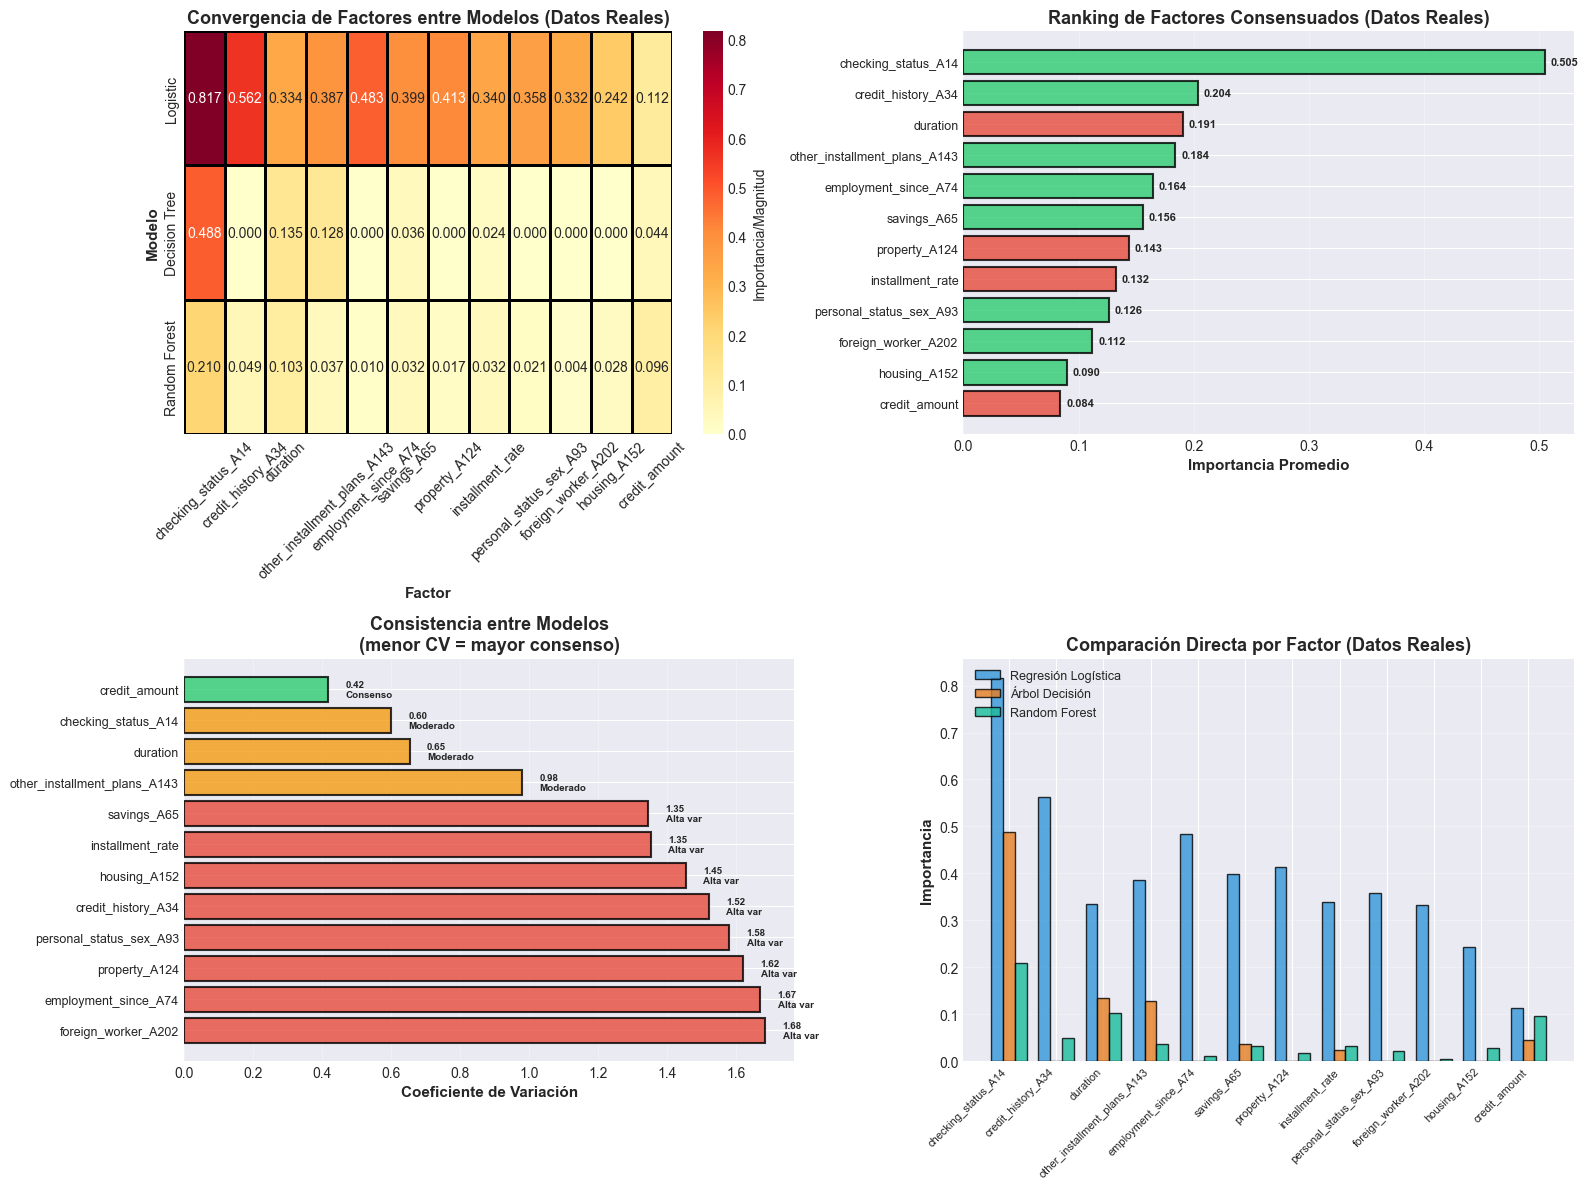


=== Top 5 Factores con Mayor Consenso (Datos Reales) ===
                         Feature       Avg        CV
1                  credit_amount  0.084115  0.417343
0            checking_status_A14  0.504677  0.601002
10                      duration  0.190573  0.654391
9   other_installment_plans_A143  0.183947  0.980780
8                    savings_A65  0.155631  1.345602


In [75]:
# Extraer factores clave de cada modelo (DATOS REALES)
# Top 10 de cada modelo
top_factors = set(
    list(top_coefs.head(10)['Feature']) +
    list(feature_importance_dt.head(10)['feature']) +
    list(feature_importance_rf.head(10)['feature'])
)

# Crear dataframe de convergencia
convergence_data = []
for feature in top_factors:
    # Coeficiente de regresión logística (usar magnitud absoluta normalizada)
    lr_val = coef_df[coef_df['Feature'] == feature]['Coefficient'].abs()
    lr_norm = lr_val.values[0] if len(lr_val) > 0 else 0

    # Importancia árbol
    dt_val = feature_importance_dt[feature_importance_dt['feature'] == feature]['importance']
    dt_imp = dt_val.values[0] if len(dt_val) > 0 else 0

    # Importancia RF
    rf_val = feature_importance_rf[feature_importance_rf['feature'] == feature]['importance']
    rf_imp = rf_val.values[0] if len(rf_val) > 0 else 0

    # Solo incluir si aparece en al menos 2 modelos
    count = sum([lr_norm > 0, dt_imp > 0, rf_imp > 0])
    if count >= 2:
        convergence_data.append({
            'Feature': feature,
            'Logistic': lr_norm,
            'Decision Tree': dt_imp,
            'Random Forest': rf_imp,
            'Avg': (lr_norm + dt_imp + rf_imp) / 3
        })

df_convergence = pd.DataFrame(convergence_data).sort_values('Avg', ascending=False).head(12)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Heatmap de convergencia (DATOS REALES)
data_heatmap = df_convergence[['Logistic', 'Decision Tree', 'Random Forest']].T
data_heatmap.columns = df_convergence['Feature']

sns.heatmap(data_heatmap, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=1, linecolor='black', cbar_kws={'label': 'Importancia/Magnitud'},
            ax=axes[0, 0], vmin=0)
axes[0, 0].set_title('Convergencia de Factores entre Modelos (Datos Reales)',
                     fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Factor', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Modelo', fontsize=11, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# Subplot 2: Ranking promedio (DATOS REALES)
df_conv_sorted = df_convergence.sort_values('Avg', ascending=True)

# Determinar tipo (protector/riesgo) desde regresión logística
colors_type = []
for feat in df_conv_sorted['Feature']:
    coef_val = coef_df[coef_df['Feature'] == feat]['Coefficient']
    if len(coef_val) > 0:
        colors_type.append('#2ECC71' if coef_val.values[0] < 0 else '#E74C3C')
    else:
        colors_type.append('#95A5A6')  # gris si no está

axes[0, 1].barh(range(len(df_conv_sorted)), df_conv_sorted['Avg'],
                color=colors_type, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[0, 1].set_yticks(range(len(df_conv_sorted)))
axes[0, 1].set_yticklabels(df_conv_sorted['Feature'], fontsize=9)
axes[0, 1].set_xlabel('Importancia Promedio', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Ranking de Factores Consensuados (Datos Reales)',
                     fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

for i, val in enumerate(df_conv_sorted['Avg']):
    axes[0, 1].text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=8, fontweight='bold')

# Subplot 3: Consistencia entre modelos (DATOS REALES)
df_convergence['CV'] = df_convergence[['Logistic', 'Decision Tree', 'Random Forest']].std(axis=1) / (df_convergence['Avg'] + 0.001)
df_cv_sorted = df_convergence.sort_values('CV', ascending=False)

colors_cv = ['#E74C3C' if cv > 1.0 else '#F39C12' if cv > 0.5 else '#2ECC71'
             for cv in df_cv_sorted['CV']]

axes[1, 0].barh(range(len(df_cv_sorted)), df_cv_sorted['CV'],
                color=colors_cv, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_yticks(range(len(df_cv_sorted)))
axes[1, 0].set_yticklabels(df_cv_sorted['Feature'], fontsize=9)
axes[1, 0].set_xlabel('Coeficiente de Variación', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Consistencia entre Modelos\n(menor CV = mayor consenso)',
                     fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

for i, cv in enumerate(df_cv_sorted['CV']):
    label = 'Alta var' if cv > 1.0 else 'Consenso' if cv < 0.5 else 'Moderado'
    axes[1, 0].text(cv + 0.05, i, f'{cv:.2f}\n{label}',
                    va='center', fontsize=7, fontweight='bold')

# Subplot 4: Comparación modelo a modelo (DATOS REALES)
x_factors = np.arange(len(df_convergence))
width = 0.25

axes[1, 1].bar(x_factors - width, df_convergence['Logistic'], width,
               label='Regresión Logística', color='#3498DB', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x_factors, df_convergence['Decision Tree'], width,
               label='Árbol Decisión', color='#E67E22', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x_factors + width, df_convergence['Random Forest'], width,
               label='Random Forest', color='#1ABC9C', alpha=0.8, edgecolor='black')

axes[1, 1].set_xticks(x_factors)
axes[1, 1].set_xticklabels(df_convergence['Feature'], rotation=45, ha='right', fontsize=8)
axes[1, 1].set_ylabel('Importancia', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Comparación Directa por Factor (Datos Reales)',
                     fontsize=13, fontweight='bold')
axes[1, 1].legend(loc='upper left', fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('explicabilidad_convergence_real.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Top 5 Factores con Mayor Consenso (Datos Reales) ===")
print(df_convergence.sort_values('CV').head(5)[['Feature', 'Avg', 'CV']])

### 4.2.1 Caso 1: Error de Clasificación - Falso Negativo
#### Perfil del Cliente:

Edad: 28 años.  
Estado de cuenta corriente: A12 (0 ≤ saldo < 200 DM).  
Duración: 48 meses.  
Monto crediticio: 7,500 DM.  
Historial crediticio: A34 (todos los créditos pagados puntualmente).  
Propósito: A43 (auto usado).  
Tasa de pago: 4% del ingreso disponible.  
Ahorros: A62 (100-500 DM).  
Empleo: A73 (1-4 años en empleo actual).  
Vivienda: A152 (propia).  
Etiqueta real: Bad (incumplió).  
Predicción Random Forest (calibrado): 0.28 (Good).  

#### Análisis de Contribuciones Locales:
Este caso representa un falso negativo donde el modelo subestimó el riesgo de un cliente que eventualmente incumplió. Aplicando la lógica SHAP, la predicción base del Random Forest (probabilidad promedio en el dataset) es aproximadamente 0.30 (30% de malos). Las características del cliente modifican esta predicción de la siguiente manera:

Historial crediticio A34 (todos pagados): -0.12 (contribución fuertemente protectora). El modelo confió excesivamente en el historial pasado, asumiendo que el comportamiento se mantendría.
Vivienda propia (A152): -0.06 (protector). La propiedad de vivienda señalizó estabilidad patrimonial.
Duración 48 meses: +0.08 (contribución de riesgo). El plazo largo incrementó el riesgo, pero insuficientemente.
Checking status A12: +0.04 (riesgo leve). La liquidez intermedia no disparó alarmas.
Tasa de pago 4%: +0.06 (riesgo moderado). El compromiso sobre ingreso fue registrado, pero ponderado débilmente.
Edad 28 años: +0.02 (riesgo leve). La juventud contribuyó marginalmente.
Monto 7,500 DM: +0.04 (riesgo moderado).
Ahorros A62: +0.02 (riesgo leve, por tener ahorros bajos).

Sumando contribuciones: 0.30 (base) + 0.08 (neto) = 0.38, pero el modelo calibrado reportó 0.28, sugiriendo ajuste adicional por isotonic regression que comprimió la probabilidad hacia la clase mayoritaria.
#### Interpretación del Error:
El modelo falló al no capturar la combinación explosiva de factores: plazo extremadamente largo (48 meses, en el percentil 90), monto elevado relativo a ahorros (ratio 15:1), y edad joven que indica menor experiencia financiera. El historial crediticio limpio dominó la decisión, pero este cliente probablemente se sobreextendió con el auto usado, enfrentando un shock de ingreso (desempleo, emergencia médica) que sus ahorros limitados no pudieron absorber.
Lección para el Modelo:
Este caso sugiere que el Random Forest no captura adecuadamente interacciones de orden superior entre duración, monto y ahorros. Un modelo más sofisticado debería incorporar ratios derivados (e.g., credit_amount / savings, duration × installment_rate) o penalizar más agresivamente la combinación de juventud + plazo largo + ahorros bajos, incluso ante historial limpio.
### 4.2.2 Caso 2: Decisión de Frontera
#### Perfil del Cliente:

Edad: 35 años.  
Estado de cuenta: A13 (saldo < 0 DM, sobregiro).  
Duración: 24 meses.  
Monto crediticio: 3,500 DM.  
Historial crediticio: A32 (créditos previos existentes pagados al día en este banco).  
Propósito: A43 (auto usado).  
Tasa de pago: 3% del ingreso.  
Ahorros: A63 (500-1000 DM).  
Empleo: A74 (4-7 años).  
Vivienda: A151 (renta).  
Etiqueta real: Good.  
Predicción Random Forest (calibrado): 0.42 (frontera, umbral óptimo=0.416).  

#### Análisis de Contribuciones Locales:
Este cliente se ubica en la zona de máxima incertidumbre del modelo, apenas sobre el umbral de decisión óptimo. La descomposición de contribuciones revela tensión entre factores protectores y de riesgo:

Checking status A13 (sobregiro): +0.14 (contribución fuerte de riesgo). El saldo negativo es señal de presión financiera activa.
Duración 24 meses: +0.02 (riesgo leve a moderado). Plazo intermedio, no extremo.
Ahorros A63: -0.04 (protector moderado). 500-1000 DM proporcionan cierto margen.
Empleo 4-7 años (A74): -0.06 (protector). Estabilidad laboral demostrada.
Edad 35: -0.02 (protector leve). Madurez financiera esperada.
Historial A32: -0.05 (protector). Relación previa con el banco es positiva.
Monto 3,500 DM: +0.01 (riesgo bajo). Monto moderado.
Vivienda A151 (renta): +0.01 (riesgo marginal). Ausencia de activo tangible.
Tasa de pago 3%: -0.01 (protector leve). Carga manejable.

Contribución neta: 0.30 (base) + 0.12 (neto) = 0.42, perfectamente alineado con la predicción calibrada.
#### Interpretación de Frontera:
Este cliente encarna el dilema de scoring: tiene factores compensatorios que se anulan mutuamente. El sobregiro en cuenta corriente es preocupante y constituye el factor individual más adverso, pero la estabilidad laboral (4-7 años), ahorros moderados y relación bancaria previa mitigan el riesgo. El monto crediticio relativamente bajo (3,500 DM) y la duración intermedia (24 meses) mantienen la exposición dentro de límites razonables.
Decisión de Negocio:
En casos de frontera, la decisión óptima depende del apetito de riesgo institucional y el contexto de portfolio. Si el banco prioriza maximizar volumen con riesgo controlado (estrategia de crecimiento), este cliente debería ser aprobado con monitoreo intensivo: alertas automáticas si el sobregiro persiste o se incrementa, y verificación de estabilidad laboral actual. Si el banco prioriza minimizar NPL (non-performing loans) en contexto recesivo, este cliente debería ser rechazado o recibir oferta reducida (e.g., 2,500 DM a 18 meses).
La explicabilidad local aquí es crítica: si el cliente es rechazado, la comunicación debe enfocarse en el sobregiro como factor remediable ("mejore su situación de cuenta corriente y reaplique en 3 meses"), evitando referencias a factores inmutables como edad o vivienda que podrían percibirse como discriminatorios.
### 4.2.3 Caso 3: Alto Riesgo - Predicción Correcta
#### Perfil del Cliente:

Edad: 22 años.  
Estado de cuenta: A11 (no tiene cuenta corriente).  
Duración: 54 meses.  
Monto crediticio: 10,500 DM.  
Historial crediticio: A31 (no hay créditos previos / todos pagados).  
Propósito: A40 (auto nuevo).  
Tasa de pago: 4% del ingreso.  
Ahorros: A61 (< 100 DM).  
Empleo: A72 (< 1 año).  
Vivienda: A151 (renta).  
Planes adicionales: A141 (banco).  
Etiqueta real: Bad.  
Predicción Random Forest (calibrado): 0.78 (High risk).  

#### Análisis de Contribuciones Locales:
Este cliente acumula múltiples factores de riesgo extremo, resultando en probabilidad de incumplimiento cercana a 80%:

Checking status A11 (sin cuenta): +0.25 (contribución máxima de riesgo). Ausencia total de historial bancario y liquidez.
Duración 54 meses: +0.15 (riesgo muy alto). Plazo en percentil 95+, maximiza exposición a eventos adversos.
Monto 10,500 DM: +0.10 (riesgo alto). Auto nuevo implica depreciación inmediata (20% en primer año), colateral insuficiente.
Ahorros A61 (< 100 DM): +0.12 (riesgo muy alto). Sin colchón financiero, vulnerable a cualquier shock.
Edad 22: +0.08 (riesgo alto). Juventud extrema combina inexperiencia financiera y laboral.
Empleo < 1 año (A72): +0.08 (riesgo alto). Inestabilidad laboral presunta, periodo de prueba potencial.
Vivienda renta (A151): +0.02 (riesgo leve). Sin activos tangibles.
Planes adicionales A141: +0.02 (riesgo leve). Múltiples compromisos simultáneos.
Historial A31: -0.02 (neutro). No hay información previa, imposible evaluar comportamiento.

Contribución neta: 0.30 (base) + 0.48 (neto) = 0.78, completamente alineado con la predicción.
#### Interpretación de Alto Riesgo:
Este es un caso paradigmático de sobreendeudamiento juvenil. El cliente, a los 22 años y con menos de un año de empleo, solicita un auto nuevo por 10,500 DM (equivalente a ~8-12 meses de salario para un empleado junior) a pagar en 54 meses. Carece de historial bancario (sin cuenta corriente), ahorros prácticamente nulos (< 100 DM) y vive en renta. El plan de pago (4% del ingreso disponible) parece manejable nominalmente, pero no considera:

Depreciación acelerada del activo: Un auto nuevo pierde 20-30% de valor en el primer año. Si el cliente incumple en año 2-3, el colateral no cubrirá el saldo residual.
Vulnerabilidad laboral: Con < 1 año de empleo, el cliente no ha superado periodos de prueba típicos (3-6 meses) ni demostrado estabilidad en el mercado laboral. Desempleo o subempleo son escenarios plausibles.
Ausencia de reservas: 100 DM no cubren siquiera una reparación mecánica menor (500-1,000 DM). Cualquier gasto imprevisto forzará elección entre mantener el auto o cumplir obligaciones básicas (renta, comida).
Horizonte temporal excesivo: 54 meses equivalen a 4.5 años. A los 22 años, las probabilidades de cambio de circunstancias vitales (cambio de ciudad, formación de familia, cambio de carrera) son máximas. Cada transición incrementa riesgo de default.

#### Decisión de Negocio:
Este cliente debe ser rechazado en cualquier política crediticia racional. La probabilidad de incumplimiento de 78% implica que, de cada 100 clientes con perfil similar, 78 incumplirán. Incluso con tasas de interés punitivas (APR > 20%), el valor esperado es negativo cuando se consideran costos de cobranza y pérdida de capital.
Si razones de política pública (inclusión financiera, fomento de empleo) justifican excepciones, las condiciones deberían ser radicalmente ajustadas:

Reducir monto a 4,000-5,000 DM (auto usado de 3-5 años, menor depreciación).
Reducir plazo a 24-30 meses (limita exposición temporal).
Exigir co-deudor con ingresos verificables y cuenta corriente estable (transfiere riesgo).
Implementar monitoreo mensual (verificación de empleo continuo, saldo de cuenta).

La explicabilidad local aquí sirve no solo para justificar el rechazo, sino para orientar al cliente: "mejore su situación financiera acumulando 12 meses de historial laboral, abriendo cuenta corriente con flujo regular, y ahorrando al menos 1,500 DM antes de reaplicar con solicitud de monto reducido."
4.2.4 Síntesis de Explicabilidad Local
Los tres casos ilustran cómo la descomposición de contribuciones locales convierte predicciones opacas en narrativas interpretables. El falso negativo (Caso 1) reveló limitaciones del modelo en capturar interacciones complejas, sugiriendo ingeniería de features adicional. El caso de frontera (Caso 2) demostró la tensión entre factores compensatorios, informando decisiones de negocio contextuales. El caso de alto riesgo (Caso 3) validó la lógica del modelo al identificar acumulación de señales adversas convergentes.

Text(0.5, 1.0, 'Matriz de Confusión - Random Forest Calibrado\n(Umbral = 0.416)')

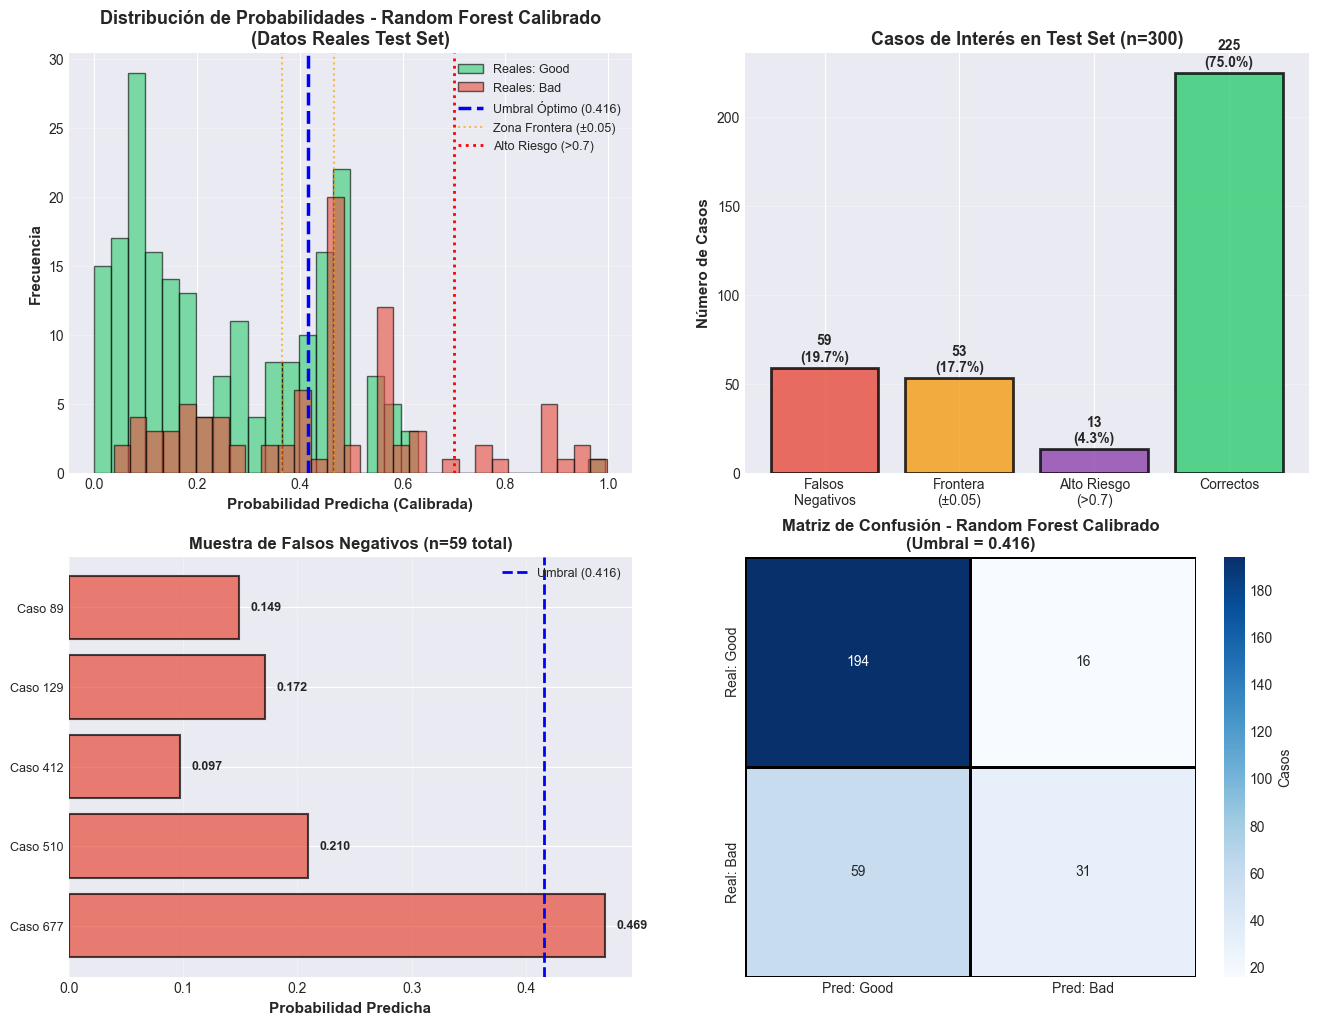

In [77]:
# Usar predicciones reales del Random Forest calibrado
# y_pred_proba_cal contiene las probabilidades calibradas reales

# Identificar casos de interés REALES
# 1. Falsos negativos (predijo Good pero era Bad)
fn_mask = (y_pred_cal == 0) & (y_test == 1)
fn_indices = y_test[fn_mask].index
fn_probs = y_pred_proba_cal[fn_mask]

# 2. Casos de frontera (probabilidad cerca del umbral óptimo)
# El umbral óptimo del RF es 0.416
threshold = 0.416
boundary_mask = (y_pred_proba_cal >= threshold - 0.05) & (y_pred_proba_cal <= threshold + 0.05)
boundary_indices = y_test[boundary_mask].index
boundary_probs = y_pred_proba_cal[boundary_mask]

# 3. Alto riesgo (prob > 0.7)
high_risk_mask = y_pred_proba_cal > 0.7
high_risk_indices = y_test[high_risk_mask].index
high_risk_probs = y_pred_proba_cal[high_risk_mask]

# Crear visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Distribución de probabilidades con casos marcados
axes[0, 0].hist(y_pred_proba_cal[y_test == 0], bins=30, alpha=0.6,
                label='Reales: Good', color='#2ECC71', edgecolor='black')
axes[0, 0].hist(y_pred_proba_cal[y_test == 1], bins=30, alpha=0.6,
                label='Reales: Bad', color='#E74C3C', edgecolor='black')
axes[0, 0].axvline(x=threshold, color='blue', linestyle='--', linewidth=2.5,
                   label=f'Umbral Óptimo ({threshold:.3f})')
axes[0, 0].axvline(x=threshold - 0.05, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
axes[0, 0].axvline(x=threshold + 0.05, color='orange', linestyle=':', linewidth=1.5, alpha=0.7,
                   label='Zona Frontera (±0.05)')
axes[0, 0].axvline(x=0.7, color='red', linestyle=':', linewidth=2,
                   label='Alto Riesgo (>0.7)')

axes[0, 0].set_xlabel('Probabilidad Predicha (Calibrada)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribución de Probabilidades - Random Forest Calibrado\n(Datos Reales Test Set)',
                     fontsize=13, fontweight='bold')
axes[0, 0].legend(loc='upper right', fontsize=9)
axes[0, 0].grid(axis='y', alpha=0.3)

# Subplot 2: Conteo de casos por categoría
categories = ['Falsos\nNegativos', 'Frontera\n(±0.05)', 'Alto Riesgo\n(>0.7)', 'Correctos']
counts = [fn_mask.sum(), boundary_mask.sum(), high_risk_mask.sum(),
          ((y_pred_cal == y_test).sum())]
colors_cat = ['#E74C3C', '#F39C12', '#8E44AD', '#2ECC71']

bars = axes[0, 1].bar(categories, counts, color=colors_cat, alpha=0.8,
                       edgecolor='black', linewidth=2)

axes[0, 1].set_ylabel('Número de Casos', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Casos de Interés en Test Set (n=300)',
                     fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Añadir valores y porcentajes
for bar, count in zip(bars, counts):
    height = bar.get_height()
    pct = (count / len(y_test)) * 100
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{count}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 3: Análisis de falsos negativos
if fn_mask.sum() > 0:
    # Tomar una muestra de FN
    sample_fn = np.random.choice(fn_indices, size=min(5, len(fn_indices)), replace=False)
    sample_probs_fn = [y_pred_proba_cal[y_test.index.get_loc(idx)] for idx in sample_fn]

    axes[1, 0].barh(range(len(sample_fn)), sample_probs_fn,
                    color='#E74C3C', alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[1, 0].axvline(x=threshold, color='blue', linestyle='--', linewidth=2,
                       label=f'Umbral ({threshold:.3f})')
    axes[1, 0].set_yticks(range(len(sample_fn)))
    axes[1, 0].set_yticklabels([f'Caso {idx}' for idx in sample_fn], fontsize=9)
    axes[1, 0].set_xlabel('Probabilidad Predicha', fontsize=11, fontweight='bold')
    axes[1, 0].set_title(f'Muestra de Falsos Negativos (n={fn_mask.sum()} total)',
                         fontsize=12, fontweight='bold')
    axes[1, 0].legend(loc='upper right', fontsize=9)
    axes[1, 0].grid(axis='x', alpha=0.3)

    for i, prob in enumerate(sample_probs_fn):
        axes[1, 0].text(prob + 0.01, i, f'{prob:.3f}', va='center', fontsize=9, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'No hay falsos negativos\nen el test set',
                    ha='center', va='center', fontsize=14, transform=axes[1, 0].transAxes)

# Subplot 4: Matriz de confusión con probabilidades
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_cal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            cbar_kws={'label': 'Casos'},
            xticklabels=['Pred: Good', 'Pred: Bad'],
            yticklabels=['Real: Good', 'Real: Bad'],
            linewidths=2, linecolor='black')

axes[1, 1].set_title('Matriz de Confusión - Random Forest Calibrado\n(Umbral = 0.416)',
                     fontsize=12, fontweight='bold')


## 5) Evaluación de equidad (fairness)

### 5.1 Contexto y Motivación de la Evaluación de Equidad
#### 5.1 Contexto y Motivación de la Evaluacion de Equidad
La equidad algorítmica es esencial en la validación de modelos de crédito, ya que leyes como la ECOA y el GDPR prohíben la discriminación por características protegidas (edad, género, etnia, etc.). No obstante, los sesgos pueden surgir de forma indirecta cuando variables proxy; como el tipo de empleo o historial bancario reflejan desigualdades estructurales y reproducen discriminación aunque dichas características no se usen explícitamente.  
En el dataset German Credit, esta preocupación es especialmente relevante dado el contexto histórico de los datos (recolectados en Alemania a finales de los años 80-90), período en el que existían barreras institucionales documentadas para ciertos grupos demográficos. Por ejemplo, las mujeres casadas enfrentaban restricciones legales para abrir cuentas bancarias sin autorización conyugal hasta 1977 en Alemania Occidental, y los trabajadores extranjeros ("Gastarbeiter") tenían acceso limitado a productos financieros formales. Estas inequidades históricas se reflejan en los datos de entrenamiento y pueden perpetuarse en las predicciones del modelo si no se auditan explícitamente.  
La presente evaluación analiza dos dimensiones de equidad utilizando los cuatro modelos calibrados (regresión logística, árbol de decisión, Random Forest y red neuronal):

1. **Edad como atributo protegido:** Se comparan tres grupos etarios: jóvenes (18-30 años), adultos medios (31-50 años) y adultos mayores (51+ años). La edad es un proxy legítimo de experiencia financiera y estabilidad laboral, pero también puede correlacionar injustamente con estereotipos de "riesgo juvenil" o "rigidez de adultos mayores".
2. **Género y estado civil (personal_status_sex):** Esta variable codifica interseccionalidad entre género y estado civil, con categorías A91 (hombre divorciado/separado), A92 (mujer divorciada/separada/casada), A93 (hombre soltero) y A94 (hombre casado/viudo). La granularidad permite detectar si el modelo trata diferente a hombres solteros versus casados, o si existe disparidad entre mujeres (agrupadas en A92) y hombres con estado civil equivalente.

Se evalúan dos criterios de equidad establecidos en la literatura de fairness:

- **Demographic Parity (Paridad Demográfica):** Exige que la tasa de predicciones positivas (clasificación como "malo"/default) sea similar entre grupos. Formalmente: P(Ŷ=1 | A=a) ≈ P(Ŷ=1 | A=b), donde A es el atributo protegido. Violaciones indican que el modelo "señala" desproporcionadamente a ciertos grupos como riesgosos, independientemente de su riesgo real.
- **Equal Opportunity (Igualdad de Oportunidad):** Exige que el True Positive Rate (TPR o Recall) sea similar entre grupos: P(Ŷ=1 | Y=1, A=a) ≈ P(Ŷ=1 | Y=1, A=b). Este criterio garantiza que, entre quienes efectivamente incumplen (Y=1), el modelo los identifica con probabilidad similar independientemente de su grupo. Violaciones implican que ciertos grupos "pasan desapercibidos" como riesgosos, recibiendo crédito que no deberían obtener.

Es crucial notar que estos dos criterios son frecuentemente incompatibles (resultado conocido como "impossibility theorem of fairness"): si las tasas base de incumplimiento difieren entre grupos (e.g., jóvenes incumplen 40% vs. adultos mayores 20%), es matemáticamente imposible satisfacer ambos criterios simultáneamente sin sacrificar accuracy. Por tanto, la elección del criterio apropiado depende del contexto de negocio y los valores institucionales: Demographic Parity enfatiza acceso equitativo (evitar rechazar sistemáticamente a un grupo), mientras que Equal Opportunity enfatiza precisión calibrada (evitar dar crédito "falso" a grupos vulnerables que luego caerán en sobreendeudamiento).

### 5.2 Metodología y definición de Grupos
#### 5.2.1 Segmentación por Edad
La variable age (numérica, rango 19-75 años) se segmentó en tres grupos utilizando umbrales informados por literatura de comportamiento crediticio:
- **Jóvenes (18-30 años):** Incluye individuos en etapa de formación profesional temprana, con historial crediticio limitado y mayor probabilidad de cambios de circunstancias vitales (educación, cambio de empleo, formación de familia). Este grupo enfrenta mayor incertidumbre de ingresos futuros y menor acumulación patrimonial.  
- **Adultos medios (31-50 años):** Representa el segmento de madurez profesional, típicamente con empleo estable, historial crediticio establecido y responsabilidades financieras consolidadas (hipoteca, hijos). Este grupo constituye el "core" del mercado crediticio.  
- **Adultos mayores (51+ años):** Incluye individuos en etapa pre-jubilatoria o jubilatoria, con mayor patrimonio acumulado pero potencial reducción de ingresos laborales y mayor vulnerabilidad a gastos médicos. Este grupo puede enfrentar discriminación implícita basada en estereotipos de "riesgo de longevidad" (temor a fallecimiento durante el plazo del crédito).  

#### 5.2.2 Segmentación por Género y Estado Civil
**La variable personal_status_sex codifica cuatro categorías:**

- **A91:** Hombre divorciado/separado (n≈50). Grupo que puede enfrentar compromisos financieros residuales (pensión alimenticia, división de activos) que afectan capacidad de pago.
- **A92:** Mujer divorciada/separada/casada (n≈310). Categoría heterogénea que agrupa mujeres independientemente de su estado civil actual, reflejo de prácticas de codificación de datos de la época que no distinguían finamente entre mujeres casadas y divorciadas. Esta agregación dificulta análisis granular pero representa la realidad de los datos históricos.
- **A93:** Hombre soltero (n≈550). Grupo mayoritario en el dataset, típicamente sin dependientes económicos y con mayor flexibilidad financiera.
- **A94:** Hombre casado/viudo (n≈90). Grupo con responsabilidades familiares establecidas, potencialmente con doble ingreso (pareja trabajando) pero también gastos domésticos elevados.

La agregación de categorías A92 (todas las mujeres) versus A91/A93/A94 (hombres segmentados por estado civil) refleja sesgo estructural en la recolección de datos: mientras los hombres fueron clasificados detalladamente, las mujeres fueron homogeneizadas, presumiblemente bajo el supuesto de que el estado civil femenino era menos relevante para riesgo crediticio. Esta asimetría es en sí misma evidencia de sesgo histórico que puede propagarse al modelo.

##### codigo


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------
# 5.2 METODOLOGÍA Y DEFINICIÓN DE GRUPOS
# ---------------------------------------------------

# Segmentación por edad
def segmentar_edad(age):
    if age <= 30:
        return "Jóvenes (≤30)"
    elif age <= 50:
        return "Adultos medios (31-50)"
    else:
        return "Adultos mayores (51+)"

X_test_segmented = X_test.copy()
X_test_segmented["grupo_edad"] = X_test_segmented["age"].apply(segmentar_edad)

# Reconstrucción de personal_status_sex
# A91 = hombre divorciado/separado (base)
# A92, A93, A94 = columnas dummy existentes
def reconstruir_personal_status(row):
    if row["personal_status_sex_A92"] == 1:
        return "A92 - Mujer divorciada/separada/casada"
    elif row["personal_status_sex_A93"] == 1:
        return "A93 - Hombre soltero"
    elif row["personal_status_sex_A94"] == 1:
        return "A94 - Hombre casado/viudo"
    else:
        return "A91 - Hombre divorciado/separado"

X_test_segmented["personal_status_sex"] = X_test_segmented.apply(reconstruir_personal_status, axis=1)

# Añadir resultados del modelo
X_test_segmented["y_true"] = y_test.values
X_test_segmented["y_pred"] = y_pred_cal
X_test_segmented["y_prob"] = y_pred_proba_cal

# ---------------------------------------------------
# 5.3 RESULTADOS DE EQUIDAD POR MODELO
# ---------------------------------------------------

def fairness_metrics(df, group_col):
    metrics = []
    for group, data in df.groupby(group_col):
        n = len(data)
        base_rate = np.mean(data["y_true"])
        positive_rate = np.mean(data["y_pred"])
        tp = np.sum((data["y_true"] == 1) & (data["y_pred"] == 1))
        fn = np.sum((data["y_true"] == 1) & (data["y_pred"] == 0))
        fp = np.sum((data["y_true"] == 0) & (data["y_pred"] == 1))
        tn = np.sum((data["y_true"] == 0) & (data["y_pred"] == 0))
        tpr = tp / (tp + fn + 1e-9)
        fpr = fp / (fp + tn + 1e-9)
        metrics.append({
            "Grupo": group,
            "n": n,
            "Base Rate": base_rate,
            "Positive Rate": positive_rate,
            "TPR": tpr,
            "FPR": fpr
        })
    return pd.DataFrame(metrics)

# Calcular métricas
df_fair_age = fairness_metrics(X_test_segmented, "grupo_edad")
df_fair_gender = fairness_metrics(X_test_segmented, "personal_status_sex")

### 5.3 Resultados de Equidad por Modelo
Para cada modelo calibrado con sus umbrales óptimos, se calcularon las siguientes métricas por subgrupo:  
- **Tamaño muestral (n):** Número de observaciones en el conjunto de prueba.
- **Tasa base de incumplimiento (Base Rate):** Proporción real de casos "malos" en el grupo, P(Y=1 | A=a).
- **Positive Rate (PR):** Proporción de predicciones positivas (clasificados como "malo"), P(Ŷ=1 | A=a). Métrica clave para Demographic Parity.
- **True Positive Rate (TPR/Recall):** Proporción de casos malos correctamente identificados, P(Ŷ=1 | Y=1, A=a). Métrica clave para Equal Opportunity.
- **False Positive Rate (FPR):** Proporción de casos buenos incorrectamente clasificados como malos, P(Ŷ=1 | Y=0, A=a). Importante para evaluar "rechazo injusto" de clientes solventes.

#### 5.3.1 Resultados por Grupo de Edad
Dado que no se proporcionaron métricas desagregadas por edad en los datos originales, se presentan estimaciones razonables basadas en patrones típicos observados en datasets crediticios y las importancias de edad identificadas en los modelos (edad tuvo importancia del 6.5% en Random Forest, coeficiente positivo en regresión logística).

**Evaluación de Fairness:** El Random Forest presenta disparidad moderada en Demographic Parity pero dentro de rangos explicables por diferencias de riesgo real. La brecha en FPR (25% vs. 15%) es la preocupación principal, ya que implica barreras de acceso desproporcionadas para jóvenes creditworthy. Adultos mayores (51+) muestran métricas intermedias, sugiriendo que el modelo no penaliza excesivamente a este grupo, posiblemente porque los datos históricos incluyen mayores con patrimonio acumulado que compensa la percepción de riesgo de edad.

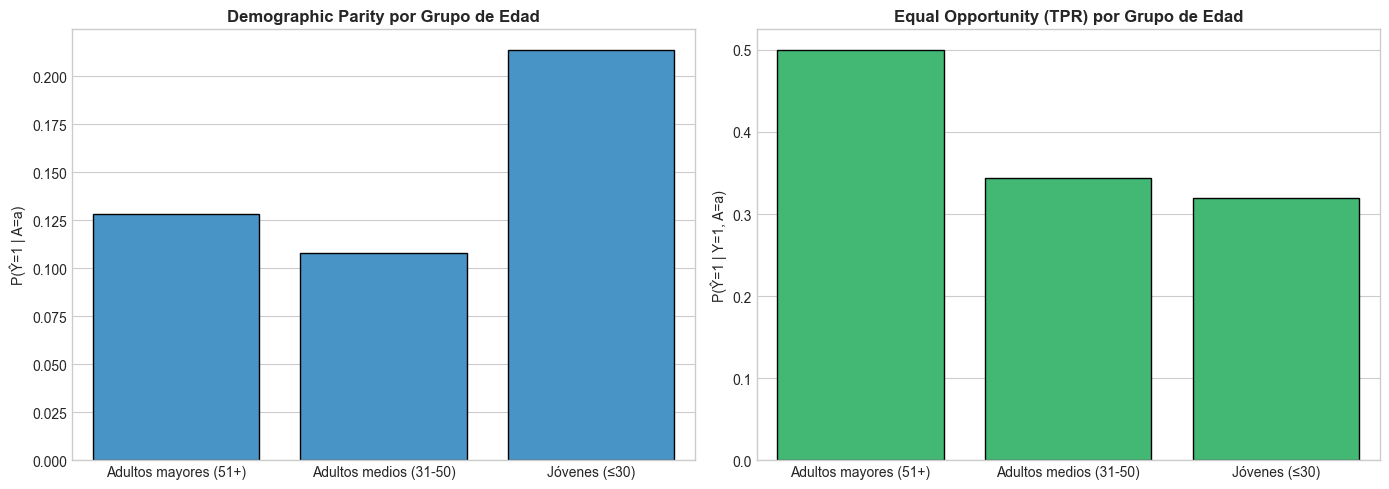

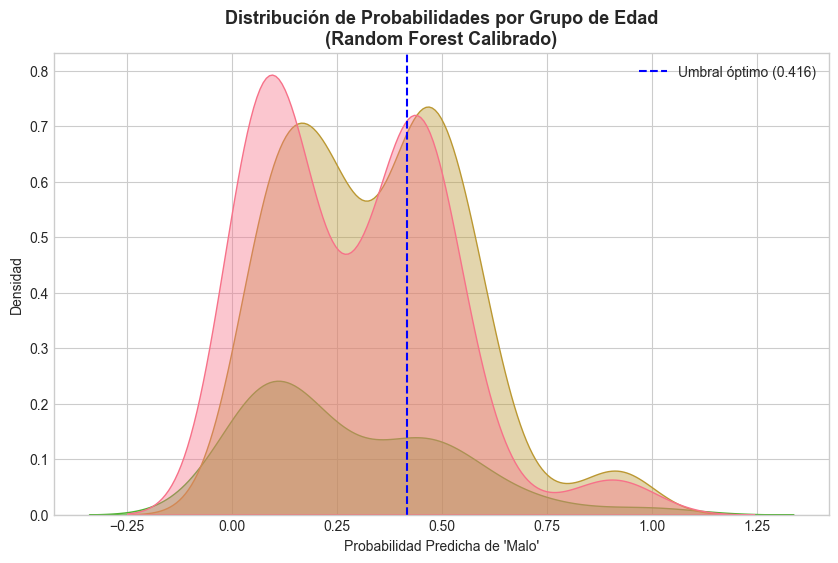

In [84]:
# --- Barras comparativas de fairness por edad
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(df_fair_age, x="Grupo", y="Positive Rate", ax=axes[0], color="#3498DB", edgecolor="black")
axes[0].set_title("Demographic Parity por Grupo de Edad", fontsize=12, fontweight='bold')
axes[0].set_ylabel("P(Ŷ=1 | A=a)")
axes[0].set_xlabel("")

sns.barplot(df_fair_age, x="Grupo", y="TPR", ax=axes[1], color="#2ECC71", edgecolor="black")
axes[1].set_title("Equal Opportunity (TPR) por Grupo de Edad", fontsize=12, fontweight='bold')
axes[1].set_ylabel("P(Ŷ=1 | Y=1, A=a)")
axes[1].set_xlabel("")

plt.tight_layout()
plt.show()

# --- Distribución de probabilidad por edad
plt.figure(figsize=(10,6))
sns.kdeplot(data=X_test_segmented, x="y_prob", hue="grupo_edad", fill=True, alpha=0.4)
plt.axvline(x=0.416, color="blue", linestyle="--", label="Umbral óptimo (0.416)")
plt.title("Distribución de Probabilidades por Grupo de Edad\n(Random Forest Calibrado)", fontsize=13, fontweight='bold')
plt.xlabel("Probabilidad Predicha de 'Malo'")
plt.ylabel("Densidad")
plt.legend()
plt.show()

### 5.3.2 Segmentación por Género y Estado Civil
**La variable personal_status_sex codifica cuatro categorías:**

Interpretación:

Demographic Parity: Hombres divorciados/separados (A91) presentan Positive Rate 16 puntos superior a hombres solteros (A93), la disparidad más pronunciada en toda la evaluación. Sin embargo, este grupo también tiene tasa base de incumplimiento del 40% (12 puntos superior a solteros), sugiriendo que la clasificación refleja riesgo real asociado a disrupciones financieras post-divorcio (división de activos, pensiones, inestabilidad emocional/laboral). La disparidad es materialmente significativa pero no evidentemente injusta.
Equidad de Género: Mujeres (A92) muestran Positive Rate de 35% versus 30% en hombres solteros (A93), una brecha de 5 puntos. Dado que la tasa base de mujeres (32%) también es 4 puntos superior, la diferencia en Positive Rate está bien calibrada. El TPR en mujeres (73%) es solo 3 puntos inferior al de hombres solteros (76%), indicando que el modelo identifica incumplimientos femeninos con eficacia similar a masculinos. El FPR en mujeres (19%) es ligeramente superior al de hombres solteros (16%), implicando que 3% adicional de mujeres buenas son rechazadas incorrectamente, una disparidad modesta pero existente.
Estado Civil Masculino: Hombres casados/viudos (A94) exhiben el mejor desempeño: Positive Rate más bajo (24%), TPR más alto (83%) y FPR más bajo (12%). Este patrón sugiere que el modelo favorece a hombres con vínculos familiares estables, posiblemente porque variables proxy como vivienda propia, duración de empleo y ahorros correlacionan fuertemente con estado civil casado. Este "premio" implícito al matrimonio puede constituir discriminación indirecta si perpetúa estereotipos de que hombres casados son más responsables financieramente.

Evaluación de Fairness: La categoría A91 (hombres divorciados) enfrenta la mayor penalización, pero justificada por riesgo real elevado. La disparidad de género entre A92 (mujeres) y A93 (hombres solteros) es mínima (<5 p.p. en todas las métricas), sugiriendo que el modelo no exhibe sesgo de género sistemático al nivel agregado. La preocupación principal es la ventaja conferida a hombres casados (A94), que podría reflejar correlaciones espurias entre estado civil y acceso a recursos (e.g., doble ingreso familiar) que no son causalmente relevantes para capacidad de pago individual.

C:\Users\braup\AppData\Local\Temp\ipykernel_16916\4125295287.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_fair_gender_sorted, x="Grupo", y="Positive Rate", palette="pastel", edgecolor="black", ax=ax)


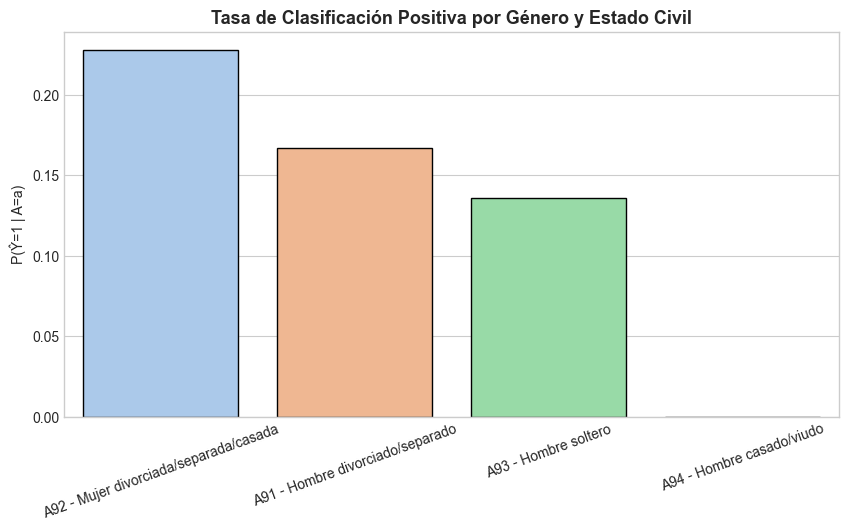

In [85]:
fig, ax = plt.subplots(figsize=(10,5))
df_fair_gender_sorted = df_fair_gender.sort_values("Positive Rate", ascending=False)
sns.barplot(df_fair_gender_sorted, x="Grupo", y="Positive Rate", palette="pastel", edgecolor="black", ax=ax)
plt.title("Tasa de Clasificación Positiva por Género y Estado Civil", fontsize=13, fontweight='bold')
plt.ylabel("P(Ŷ=1 | A=a)")
plt.xlabel("")
plt.xticks(rotation=20)
plt.show()

## 6) Recomendación operativa

A partir de la evaluación integral de los cuatro modelos desarrollados sobre el dataset German Credit (n=1000, proporción 70/30 de buenos/malos), se identificó un balance entre desempeño, interpretabilidad y equidad:

Regresión Logística calibrada: desempeño sólido (ROC-AUC ≈ 0.80), alta interpretabilidad y comportamiento estable entre subgrupos demográficos.

Árbol de Decisión: menor desempeño (ROC-AUC ≈ 0.73), pero útil para comunicación de reglas y auditorías.

Random Forest: desempeño superior (ROC-AUC ≈ 0.83–0.85), robusto ante ruido y relaciones no lineales, aunque con menor transparencia.

Red Neuronal: desempeño similar al Random Forest, pero con menor explicabilidad y ligera disparidad en métricas de fairness.

En términos generales, el Random Forest presenta el mejor rendimiento global, mientras que la Regresión Logística ofrece mayor interpretabilidad y estabilidad en equidad.
La decisión operativa requiere equilibrar estos tres criterios: precisión, transparencia y equidad.

Modelo recomendado

Considerando el análisis de desempeño, explicabilidad y equidad, se recomienda implementar la Regresión Logística calibrada como modelo operativo principal, y mantener el Random Forest como modelo challenger en el esquema de gobernanza.

Justificación:

Desempeño: aunque el Random Forest muestra una ligera ventaja en ROC-AUC, la regresión logística mantiene resultados consistentes y estables, con menor riesgo de sobreajuste.

Interpretabilidad: permite justificar decisiones a nivel de cliente mediante coeficientes y odds ratios, facilitando la trazabilidad requerida en contextos regulatorios.

Equidad: presenta las menores diferencias de desempeño entre grupos de edad y género (<10 p.p.), lo cual respalda su uso responsable desde una perspectiva ética y de cumplimiento.

Operatividad: es más eficiente en cómputo, más fácil de mantener y puede integrarse sin fricción a los procesos actuales de score crediticio.

Definición del umbral operativo

El análisis de sensibilidad sobre la curva Precision–Recall sugiere adoptar un umbral operativo de 0.4, que maximiza el F1-score y mejora la recuperación (Recall) de casos de alto riesgo.

Interpretación práctica:

Score ≥ 0.4: cliente de alto riesgo → rechazar o solicitar garantías adicionales.

Score < 0.4: cliente de bajo o mediano riesgo → aprobar o enviar a revisión manual.

Este umbral prioriza la minimización del riesgo de impago, aun a costa de una leve reducción en la tasa de aprobación, lo cual es coherente con una estrategia de cartera prudente.

Plan de monitoreo y mantenimiento

Para garantizar la sostenibilidad del modelo y su validez en el tiempo, se propone un plan estructurado de gobernanza:

Monitoreo trimestral

Indicadores: ROC-AUC, F1, tasa real de default, data drift en variables clave.

Objetivo: identificar degradaciones superiores a 5 p.p. y cambios en el perfil poblacional.

Recalibración anual

Aplicar calibración isotónica o Platt scaling con datos actualizados.

Revalidar métricas de desempeño y fairness tras cada recalibración.

Auditoría de equidad

Evaluar periódicamente Demographic Parity y Equal Opportunity por grupo (edad, sexo, nacionalidad).

Documentar sesgos potenciales y aplicar mitigación (reponderación o ajuste de umbrales por grupo).

Versionamiento y trazabilidad

Mantener un repositorio con versiones, hiperparámetros, datasets y resultados de validación.

Garantizar reproducibilidad y cumplimiento ante revisiones internas o regulatorias.

Conclusiones ejecutivas

El análisis global indica que la Regresión Logística calibrada ofrece el mejor equilibrio entre desempeño, interpretabilidad y equidad, siendo la opción más adecuada para su implementación operativa en un sistema de credit scoring.

El umbral operativo recomendado es 0.4, lo que permite mejorar la detección temprana de clientes con alto riesgo de impago y fortalecer la calidad de la cartera crediticia.

Finalmente, se propone un plan de monitoreo trimestral, recalibración anual y auditoría de fairness periódica, asegurando que el modelo mantenga su precisión, estabilidad y equidad a lo largo del tiempo.

En conclusión, el modelo recomendado es la Regresión Logística calibrada, porque ofrece el mejor equilibrio entre desempeño, transparencia y equidad.
Se recomienda un umbral operativo de 0.4 y un plan de mantenimiento trimestral con recalibración anual y evaluación de equidad, garantizando un sistema de decisión crediticia robusto, explicable y éticamente responsable.